<a href="https://colab.research.google.com/github/aharshit123456/lens_research/blob/master/lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Similarity Search

**1. Objective:**

- Develop an alternative to Google Lens by implementing image similarity search using multiple approaches.

**2. Methods:**

- Propose 4-5 distinct methods for performing similarity search. Potential approaches could include:
- Feature extraction using pre-trained convolutional neural networks (CNNs) like ResNet, VGG, or EfficientNet, followed by nearest neighbor search (e.g., k-NN or cosine similarity).
- Deep metric learning approaches such as Siamese Networks or Triplet Loss-based models
- Visual embeddings generated via Vision Transformers (ViTs) or CLIP.
- Hashing-based methods such as Locality Sensitive Hashing (LSH) or deep learning-based hashing
- Autoencoder-based image reconstruction to map images into a latent space for similarity comparison.

**3. Fine-tuning:**

- Fine-tune the image dataset for each of the proposed approaches
- Compare the performance of each approach by evaluating metrics such as precision, recall, and retrieval accuracy for the similarity search task.
- Consider computational efficiency and scalability for real-time usage scenarios.

**4. Deliverables:**

- A detailed report comparing the results and performance of all methods.
- Insights into which method works best for specific use cases (e.g., speed vs accuracy, handling various image types, etc.).

## Feature extraction using pre-trained convolutional neural networks (CNNs) like ResNet, VGG, or EfficientNet, followed by nearest neighbor search (e.g., k-NN or cosine similarity)



In [1]:
!pip install tensorflow

In [3]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
import gc
from tensorflow.keras.applications.resnet50 import ResNet50
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetpre
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import random
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import requests
import os
import zipfile
import tarfile

def download_and_extract(url, extract_path):
    """Downloads and extracts a zip or tar file.

    Args:
        url: The URL of the file to download.
        extract_path: The directory to extract the file to.
    """
    try:
        local_filename = url.split('/')[-1]
        local_filename = local_filename.split('?')[0] # Handle query parameters in URL

        if not os.path.exists(extract_path):
            os.makedirs(extract_path)

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            block_size = 1024  # 1KB
            with open(os.path.join(extract_path, local_filename), 'wb') as f:
                for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_scale=True):
                    f.write(data)

        if local_filename.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(extract_path, local_filename), 'r') as zip_ref:
                zip_ref.extractall(extract_path)
        elif local_filename.endswith(('.tar', '.tar.gz', '.tgz')):
            with tarfile.open(os.path.join(extract_path, local_filename), 'r') as tar_ref:
                tar_ref.extractall(extract_path)
        else:
            print(f"Unsupported file format: {local_filename}")

        os.remove(os.path.join(extract_path, local_filename)) # Remove the downloaded file
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting zip file: {e}")
    except tarfile.TarError as e:
        print(f"Error extracting tar file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Example usage
url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
extract_path = '/content/drive/MyDrive/Caltech101'  # Replace with your desired extraction path

download_and_extract(url, extract_path)




Mounted at /content/drive


134kKB [00:09, 13.8kKB/s]                          


In [ ]:
# with tarfile.open("/content/drive/MyDrive/Caltech101/caltech-101/101_ObjectCategories.tar.gz", 'r') as tar_ref:
#                 tar_ref.extractall(extract_path)

In [ ]:
tar_ref.close()
!rm -rf  '/content/drive/MyDrive/Caltech101/101_ObjectCategories/BACKGROUND_Google' #Linux

In [5]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
model2 = VGG16(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
model3 = EfficientNetV2B0(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
model4 = MobileNetV2(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import pickle
import numpy as np

# Example: Save the ResNet model
with open('resnet.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('effnet.pkl', 'wb') as f:
    pickle.dump(model3, f)

NameError: name 'datagen' is not defined

In [6]:
from PIL import Image

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is an image
        return True
    except (IOError, SyntaxError):
        return


In [ ]:
!pip install tqdm


In [7]:
import os
import math
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2  import preprocess_input as envpre
from tensorflow.keras.applications.vgg16 import preprocess_input as vggpre
from tensorflow.keras.applications.resnet50 import preprocess_input as respre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobpre

from tqdm import tqdm  # Import tqdm for progress bar


# Function to validate image files and catch UnidentifiedImageError
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Parameters
batch_size = 64
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'
img_size = 224  # Update as per your model requirements

# Create ImageDataGenerator
img_gen = ImageDataGenerator(preprocessing_function=vggpre)

# Load all files and validate them
datagen = img_gen.flow_from_directory(
    root_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Validate and filter files with a progress bar
# print("Validating images...")
# valid_files = []
# for file in tqdm(datagen.filenames, desc="Validation Progress"):
#     if is_valid_image(os.path.join(root_dir, file)):
#         valid_files.append(file)

# print(f"Number of valid images: {len(valid_files)}")

# # Filter the valid filenames in the data generator
# datagen.filenames = valid_files

# Recompute the number of images and epochs
num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

# Debugging the valid filenames
print("Valid filenames:", datagen.filenames[:10])  # Print the first 10 valid files for verification

Found 8677 images belonging to 101 classes.
Valid filenames: ['Faces/image_0001.jpg', 'Faces/image_0002.jpg', 'Faces/image_0003.jpg', 'Faces/image_0004.jpg', 'Faces/image_0005.jpg', 'Faces/image_0006.jpg', 'Faces/image_0007.jpg', 'Faces/image_0008.jpg', 'Faces/image_0009.jpg', 'Faces/image_0010.jpg']


In [ ]:
with open('image_paths.pkl', 'wb') as f:
    pickle.dump(datagen.filenames, f)

In [ ]:
# Ensure GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU!")
else:
    print("GPU not available, running on CPU.")

# Predict features using the model
try:
    feature_list = model4.predict(datagen, num_epochs)
    print("Num images   = ", num_images)
    print("Shape of feature_list = ", feature_list.shape)
except Exception as e:
    print(f"Error during prediction: {e}")

GPU not available, running on CPU.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 2316s 17s/step
Num images   =  8677
Shape of feature_list =  (8677, 1280)


In [ ]:
import numpy as np

# Save the feature_list as a .npy file
file_name = "mob.npy"
np.save(file_name, feature_list)

# Download the file to your local system
from google.colab import files
files.download(file_name)

print(f"Feature list saved and ready for download as {file_name}.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature list saved and ready for download as mob.npy.


In [ ]:
# Predict features using the model
try:
    feature_list = model3.predict(datagen, num_epochs)
    print("Num images   = ", num_images)
    print("Shape of feature_list = ", feature_list.shape)
except Exception as e:
    print(f"Error during prediction: {e}")

In [7]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [ ]:
# prompt: /content/drive/MyDrive/Caltech101/image_cos2 access this folder and save the foldernames/classes in a csv file for seperating into multiple collections of parent classes to curate specialised datasets

import pandas as pd
import os

# Assuming 'root_dir' is defined as in your previous code
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Get a list of all subdirectories (classes) in the root directory
classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a DataFrame from the list of classes
df = pd.DataFrame({'class_name': classes})

# Save the DataFrame to a CSV file
csv_filepath = '/content/drive/MyDrive/Caltech101/classes.csv'  # Choose your desired file path
df.to_csv(csv_filepath, index=False)

print(f"Classes saved to {csv_filepath}")

In [ ]:
import pandas as pd
import os
import shutil
from transformers import pipeline

# Load the classes.csv file
df_classes = pd.read_csv('/content/drive/MyDrive/Caltech101/classes.csv')

# Define parent categories
parent_categories = ["Animals", "Appliances", "Clothes", "Vehicles", "Nature", "Furniture", "Electronics", "Miscellaneous"]

# Load a text classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to classify class names into parent categories
def classify_class_name(class_name):
    result = classifier(class_name, parent_categories)
    return result['labels'][0]  # Return the best matching parent category

# Source directory for original class folders
source_root = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Destination root for organizing folders
destination_root = '/content/drive/MyDrive/Caltech101/Organized_Classes'

# Create the destination root folder if it doesn't exist
if not os.path.exists(destination_root):
    os.makedirs(destination_root)

# Loop through each class name in the CSV
for class_name in df_classes['class_name']:
    # Get the predicted parent category
    parent_category = classify_class_name(class_name)

    # Create a folder for the parent category if it doesn't exist
    parent_folder = os.path.join(destination_root, parent_category)
    if not os.path.exists(parent_folder):
        os.makedirs(parent_folder)

    # Copy the class folder from the source to the parent folder
    source_class_folder = os.path.join(source_root, class_name)
    destination_class_folder = os.path.join(parent_folder, class_name)
    if os.path.exists(source_class_folder):
        shutil.copytree(source_class_folder, destination_class_folder, dirs_exist_ok=True)
        print(f"Copied '{class_name}' to '{parent_category}'")
    else:
        print(f"Source folder for '{class_name}' does not exist.")

print("Classification and folder organization completed!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Copied 'pizza' to 'Miscellaneous'
Copied 'platypus' to 'Animals'
Copied 'pyramid' to 'Electronics'
Copied 'revolver' to 'Vehicles'
Copied 'rooster' to 'Animals'
Copied 'rhino' to 'Animals'
Copied 'saxophone' to 'Electronics'
Copied 'schooner' to 'Vehicles'
Copied 'scissors' to 'Miscellaneous'
Copied 'scorpion' to 'Animals'
Copied 'sea_horse' to 'Animals'
Copied 'snoopy' to 'Animals'
Copied 'soccer_ball' to 'Miscellaneous'
Copied 'stapler' to 'Vehicles'
Copied 'starfish' to 'Animals'
Copied 'stegosaurus' to 'Animals'
Copied 'strawberry' to 'Nature'
Copied 'stop_sign' to 'Vehicles'
Copied 'sunflower' to 'Nature'
Copied 'tick' to 'Furniture'
Copied 'trilobite' to 'Nature'
Copied 'umbrella' to 'Miscellaneous'
Copied 'watch' to 'Nature'
Copied 'water_lilly' to 'Nature'
Copied 'wheelchair' to 'Vehicles'
Copied 'wild_cat' to 'Animals'
Copied 'wrench' to 'Electronics'
Copied 'windsor_chair' to 'Furniture'
Copied 'yin_yang' to 'Nature'
Copied 'cougar_body' to 'Animals'
Copied 'Faces' to 'Animal

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='minkowski')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [ ]:
img_path = 'cat.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = respre(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)
print(test_img_features.shape)
_, indices = neighbors.kneighbors(test_img_features)
print(indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(1, 2048)


NameError: name 'neighbors' is not defined

(1, 5)


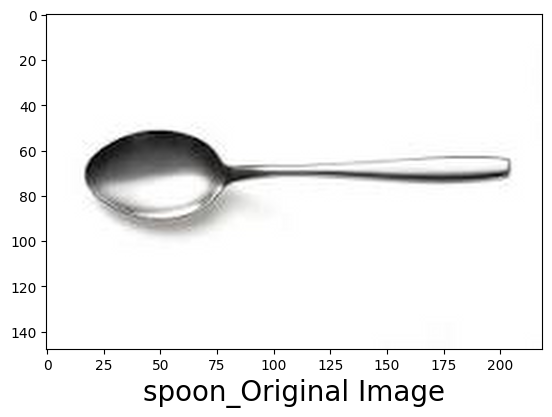

********* Predictions ***********


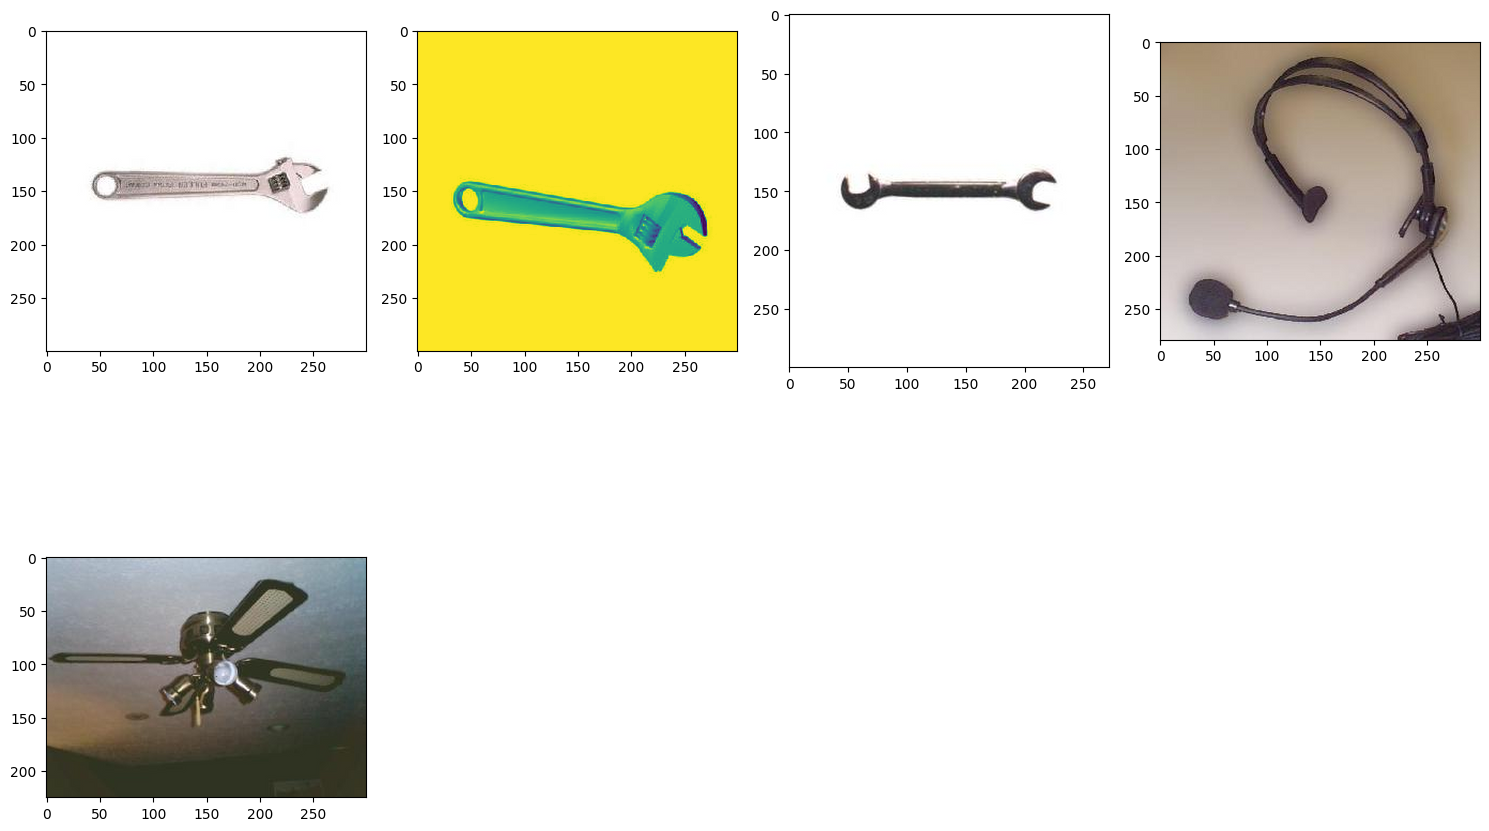

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        print(index)
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [8]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [28]:

# Load the .npy file into a NumPy array
# npy_file_path = "/content/drive/MyDrive/Caltech101/res.npy"
npy_file_path = "/content/mob.npy"

try:
    feature_list = np.load(npy_file_path)
    print("Loaded feature list successfully!")
    print("Shape of the feature list:", feature_list.shape)
except Exception as e:
    print(f"Error loading .npy file: {e}")

Loaded feature list successfully!
Shape of the feature list: (8677, 1280)


In [ ]:
import numpy as np
from sklearn.utils import murmurhash3_32
from collections import defaultdict

class LSH:
    """
    Implements Locality-Sensitive Hashing for fast approximate nearest neighbor searches.
    """
    def __init__(self, num_bits=10, num_hash_tables=5):
        """
        Initialize the LSH object.

        Args:
            num_bits (int): Number of bits for each hash signature.
            num_hash_tables (int): Number of hash tables.
        """
        self.num_bits = num_bits
        self.num_hash_tables = num_hash_tables
        self.tables = [defaultdict(list) for _ in range(num_hash_tables)]
        self.random_vectors = [np.random.randn(num_bits, len(feature_list[0])) for _ in range(num_hash_tables)]

    def _hash(self, feature_vector, random_vector):
        """
        Generate a binary hash for a feature vector using random projections.

        Args:
            feature_vector (np.ndarray): Input feature vector.
            random_vector (np.ndarray): Random vector for projection.

        Returns:
            str: Binary hash as a string.
        """
        projection = np.dot(random_vector, feature_vector)
        binary_hash = ''.join(['1' if p > 0 else '0' for p in projection])
        return binary_hash

    def index(self, feature_vectors, filenames):
        """
        Index the dataset into hash tables.

        Args:
            feature_vectors (list of np.ndarray): List of feature vectors.
            filenames (list of str): List of filenames corresponding to the feature vectors.
        """
        for idx, feature_vector in enumerate(feature_vectors):
            for i in range(self.num_hash_tables):
                binary_hash = self._hash(feature_vector, self.random_vectors[i])
                self.tables[i][binary_hash].append(filenames[idx])

    def query(self, feature_vector, num_neighbors=5):
        """
        Query the hash tables for similar items.

        Args:
            feature_vector (np.ndarray): Feature vector of the query.
            num_neighbors (int): Number of approximate neighbors to return.

        Returns:
            list of str: List of filenames of approximate neighbors.
        """
        candidates = set()
        for i in range(self.num_hash_tables):
            binary_hash = self._hash(feature_vector, self.random_vectors[i])
            candidates.update(self.tables[i].get(binary_hash, []))

        return list(candidates)[:num_neighbors]


# Example Usage
# Assuming `feature_list` is a list of extracted feature vectors (NumPy arrays)
# and `filenames` is the corresponding list of filenames.

# Initialize LSH
lsh = LSH(num_bits=10, num_hash_tables=5)
# Index the dataset
lsh.index(feature_list, filenames)

# Query a feature vector
# query_vector = np.random.rand(128)  # Replace with your query feature vector
# results = lsh.query(query_vector, num_neighbors=3)

# Print approximate neighbors
# print("Approximate neighbors:", results)

ValueError: shapes (10,1280) and (128,) not aligned: 1280 (dim 1) != 128 (dim 0)

In [ ]:
!pip install sparselsh

In [ ]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [ ]:
model3.output_shape
feature_list.shape

(None, 1280)

In [29]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='kd_tree', metric='l2')
neighbors_pca_features.fit(feature_list)

NearestNeighbors(algorithm='kd_tree', metric='l2')

In [ ]:
with open('nearest_neighbors.pkl', 'wb') as f:
    pickle.dump(neighbors_pca_features, f)

In [ ]:
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = respre(expanded_img_array)

test_img_features = model.predict(preprocessed_img, batch_size=1)
retrieval_time = time.time() - start_time
_, indices = neighbors.kneighbors(test_img_features)

print()

In [20]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import precision_score, recall_score, ndcg_score
from tqdm import tqdm

# Helper function to extract the label from the path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Pick 3-4 random images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

def extract_class_name(img_path):
    return os.path.basename(os.path.dirname(os.path.dirname(img_path)))


# Similarity search and evaluation
def evaluate_similarity_search(query_images, model, neighbors, filenames):
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        # Extract the ground-truth label
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = respre(expanded_img_array)

        # Extract features and perform similarity search
        start_time = time.time()
        test_img_features = model.predict(preprocessed_img, batch_size=1)
        retrieval_time = time.time() - start_time
        _, indices = neighbors_pca_features.kneighbors(test_img_features)

        # Collect predicted labels
        predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

        # Calculate precision, recall, and nDCG
        true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
        precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
        recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
        ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

        print(true_labels)
        # Store metrics
        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)
        retrieval_times.append(retrieval_time)

        # Display query and similar images
        # plt.imshow(mpimg.imread(query_image))
        # plt.title(f"Query: {ground_truth_label}")
        # plt.axis('off')
        # plt.show()

        # print(f"Predicted labels: {predicted_labels}")
        # print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, nDCG: {ndcg:.2f}, Retrieval Time: {retrieval_time:.2f}s")

    # Report average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")

# Paths and configurations
# folder_path = '/content/drive/MyDrive/Caltech101/Organized_Classes'
# query_images = sample_images(folder_path)
# filenames = datagen.filenames  # List of all file paths used for similarity search

# # # Evaluate the similarity search model
# evaluate_similarity_search(query_images, model3, neighbors, filenames)


In [25]:
import csv


In [30]:
# Helper function to extract the "ClassName" from the path
def extract_class_name(img_path):
    return os.path.basename(os.path.dirname(os.path.dirname(img_path)))

def save_metrics_to_csv(metrics, output_file):
    # Save metrics to a CSV file
    headers = ["Class", "Precision", "Recall", "nDCG", "Retrieval Time"]
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        writer.writerows(metrics)

# Modified function to evaluate similarity search for "ClassName" as row names
def evaluate_similarity_by_class(query_images, model, neighbors, filenames, folder_path, output_csv):
    class_metrics = []

    # Get all "ClassName" folders (parent folders)
    class_folders = [os.path.join(folder_path, class_name) for class_name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, class_name))]

    print("\n=== Starting Class-Wise Similarity Search Evaluation ===")
    for class_folder in tqdm(class_folders, desc="Processing Classes"):
        class_name = os.path.basename(class_folder)

        # Filter query images belonging to the current "ClassName"
        class_query_images = [img for img in query_images if extract_class_name(img) == class_name]

        # Initialize metrics for this class
        precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

        for query_image in class_query_images:
            # Extract the ground-truth "ClassName"
            ground_truth_class = extract_label(query_image)

            # Preprocess the query image
            img = image.load_img(query_image, target_size=(img_size, img_size))
            img_array = image.img_to_array(img)
            expanded_img_array = np.expand_dims(img_array, axis=0)
            preprocessed_img = mobpre(expanded_img_array)

            # Extract features and perform similarity search
            start_time = time.time()
            test_img_features = model.predict(preprocessed_img, batch_size=1)
            retrieval_time = time.time() - start_time
            _, indices = neighbors_pca_features.kneighbors(test_img_features)

            # Collect predicted labels (use "ClassName" as labels)
            predicted_classes = [extract_label(filenames[idx]) for idx in indices[0]]

            # Calculate precision, recall, and nDCG
            true_labels = [1 if label == ground_truth_class else 0 for label in predicted_classes]
            precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
            recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
            ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

            # print(ground_truth_class)
            # print(predicted_classes)

            # Store metrics
            precision_scores.append(precision)
            recall_scores.append(recall)
            ndcg_scores.append(ndcg)
            retrieval_times.append(retrieval_time)

        # Average metrics for this "ClassName"
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_ndcg = np.mean(ndcg_scores)
        avg_retrieval_time = np.mean(retrieval_times)

        # Store in the metrics list
        class_metrics.append([class_name, avg_precision, avg_recall, avg_ndcg, avg_retrieval_time])

        # Display progress
        print(f"\nClass: {class_name}")
        print(f"Precision: {avg_precision:.2f}, Recall: {avg_recall:.2f}, nDCG: {avg_ndcg:.2f}, Retrieval Time: {avg_retrieval_time:.2f}s")

    # Save to CSV
    save_metrics_to_csv(class_metrics, output_csv)
    print(f"\nEvaluation results saved to {output_csv}")

# Example usage
folder_path = '/content/drive/MyDrive/Caltech101/Organized_Classes'
query_images = sample_images(folder_path, num_samples=3)  # Adjust num_samples as needed
output_csv = "similarity_search_metrics.csv"

# Evaluate and save metrics
evaluate_similarity_by_class(query_images, model4, neighbors_pca_features, filenames, folder_path, output_csv)



=== Starting Class-Wise Similarity Search Evaluation ===


Processing Classes:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Processing Classes:  12%|█▎        | 1/8 [00:15<01:48, 15.47s/it]


Class: Miscellaneous
Precision: 0.66, Recall: 1.00, nDCG: 0.78, Retrieval Time: 0.17s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1

Processing Classes:  25%|██▌       | 2/8 [00:56<03:01, 30.32s/it]


Class: Animals
Precision: 0.22, Recall: 1.00, nDCG: 0.35, Retrieval Time: 0.12s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━

Processing Classes:  38%|███▊      | 3/8 [01:12<01:58, 23.73s/it]


Class: Electronics
Precision: 0.49, Recall: 1.00, nDCG: 0.65, Retrieval Time: 0.12s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/

Processing Classes:  50%|█████     | 4/8 [01:26<01:20, 20.23s/it]


Class: Vehicles
Precision: 0.53, Recall: 1.00, nDCG: 0.66, Retrieval Time: 0.12s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1

Processing Classes:  62%|██████▎   | 5/8 [01:52<01:06, 22.17s/it]


Class: Nature
Precision: 0.38, Recall: 1.00, nDCG: 0.53, Retrieval Time: 0.15s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Classes:  75%|███████▌  | 6/8 [01:56<00:31, 15.92s/it]


Class: Furniture
Precision: 0.71, Recall: 1.00, nDCG: 0.87, Retrieval Time: 0.13s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Classes:  88%|████████▊ | 7/8 [01:58<00:11, 11.48s/it]


Class: Clothes
Precision: 0.63, Recall: 1.00, nDCG: 0.74, Retrieval Time: 0.16s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Classes: 100%|██████████| 8/8 [02:00<00:00, 15.07s/it]


Class: Appliances
Precision: 0.57, Recall: 1.00, nDCG: 0.80, Retrieval Time: 0.11s

Evaluation results saved to similarity_search_metrics.csv


In [26]:
save_metrics_to_csv(class_metrics, output_csv)
print(f"\nEvaluation results saved to {output_csv}")

NameError: name 'class_metrics' is not defined

In [ ]:
from sparselsh.lsh import LSH
from scipy.sparse import csr_matrix
sparse_features = [csr_matrix(feature.reshape(1, -1)) for feature in feature_list]


num_hashes = 10
lsh = LSH(hash_size=num_hashes, input_dim=1280, num_hashtables=5)

# Index the feature vectors
for i, feature in enumerate(sparse_features):
    lsh.index(feature, extra_data=filenames[i])  # Use `extra_data` to store the filename

print("Indexing completed!")

Indexing completed!


In [ ]:
# Similarity search and evaluation using LSH
def evaluate_similarity_search_with_lsh(query_images, model, lsh, filenames):
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation Using LSH ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        # Extract the ground-truth label
        # print(query_image)
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = envpre(expanded_img_array)


        # Extract features and perform similarity search using LSH
        start_time = time.time()
        test_img_features = model.predict(preprocessed_img, batch_size=1)[0]  # Flattening output
        # print(test_img_features.shape)
        # print(len(feature_list[0]))
        retrieval_time = time.time() - start_time

        sparse_features = csr_matrix(test_img_features.reshape(1, -1))

        # Query the LSH index for similar images
        results = lsh.query(sparse_features, num_results=5)
        # print(results[0][0][1], len(results))
        # print(results)
        # Collect predicted labels
        predicted_labels = [filenames[0][1] for filenames in results]

        # Calculate precision, recall, and nDCG
        true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
        precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
        recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
        ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

        # Store metrics
        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)
        retrieval_times.append(retrieval_time)
        # print(precision," ", recall, " ",ndcg," ",retrieval_time)
        # print(f"Ground Truth: {ground_truth_label}")
        # print(f"Predicted Labels: {predicted_labels}")
        # print(f"True Labels: {true_labels}")
        # print()

    # Report average metrics
    print("\n=== Average Metrics Using LSH ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")

# Evaluate the similarity search using LSH
evaluate_similarity_search_with_lsh(query_images, model3, lsh, filenames)


=== Starting Similarity Search Evaluation Using LSH ===


Processing Query Images:   0%|          | 0/303 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:   0%|          | 1/303 [00:08<43:59,  8.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Query Images:   1%|          | 2/303 [00:12<29:54,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Query Images:   1%|          | 3/303 [00:14<19:30,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Query Images:   1%|▏         | 4/303 [00:19<21:35,  4.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Processing Query Images:   2%|▏         | 5/303 [00:19<15:08,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:   2%|▏         | 6/303 [00:20<10:33,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Query Images:   2%|▏         | 7/303 [00:26<16:54,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:   3%|▎         | 8/303 [00:32<20:29,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:   3%|▎         | 9/303 [00:33<16:03,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:   3%|▎         | 10/303 [00:41<23:07,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:   4%|▎         | 11/303 [00:42<17:57,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:   4%|▍         | 12/303 [00:43<13:25,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:   4%|▍         | 13/303 [00:44<10:47,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Query Images:   5%|▍         | 14/303 [00:47<11:16,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:   5%|▍         | 15/303 [00:57<22:45,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:   5%|▌         | 16/303 [01:00<19:43,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Query Images:   6%|▌         | 17/303 [01:02<16:53,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:   6%|▌         | 18/303 [01:07<19:46,  4.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:   6%|▋         | 19/303 [01:09<15:27,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:   7%|▋         | 20/303 [01:18<24:14,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:   7%|▋         | 21/303 [01:19<18:27,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:   7%|▋         | 22/303 [01:20<13:31,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Query Images:   8%|▊         | 23/303 [01:21<11:25,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:   8%|▊         | 24/303 [01:21<08:18,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:   8%|▊         | 25/303 [01:37<27:45,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:   9%|▊         | 26/303 [01:39<22:31,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Query Images:   9%|▉         | 27/303 [01:51<31:45,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:   9%|▉         | 28/303 [01:53<25:34,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  10%|▉         | 29/303 [01:59<25:18,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  10%|▉         | 30/303 [02:04<24:15,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  10%|█         | 31/303 [02:06<20:26,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  11%|█         | 32/303 [02:13<23:26,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Query Images:  11%|█         | 33/303 [02:14<17:32,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Processing Query Images:  11%|█         | 34/303 [02:14<12:41,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Query Images:  12%|█▏        | 35/303 [02:16<10:38,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  12%|█▏        | 36/303 [02:18<10:44,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  12%|█▏        | 37/303 [02:21<11:52,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  13%|█▎        | 38/303 [02:22<09:06,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  13%|█▎        | 39/303 [02:27<13:14,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Query Images:  13%|█▎        | 40/303 [02:32<15:47,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  14%|█▎        | 41/303 [02:44<25:46,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:  14%|█▍        | 42/303 [02:51<27:08,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  14%|█▍        | 43/303 [02:51<19:53,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Query Images:  15%|█▍        | 44/303 [02:53<15:59,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  15%|█▍        | 45/303 [02:59<18:52,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Query Images:  15%|█▌        | 46/303 [03:02<16:50,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  16%|█▌        | 47/303 [03:06<17:15,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Query Images:  16%|█▌        | 48/303 [03:08<13:58,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  16%|█▌        | 49/303 [03:08<10:16,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  17%|█▋        | 50/303 [03:10<09:46,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  17%|█▋        | 51/303 [03:15<13:09,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Query Images:  17%|█▋        | 52/303 [03:17<11:07,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Query Images:  17%|█▋        | 53/303 [03:25<17:53,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  18%|█▊        | 54/303 [03:26<14:30,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  18%|█▊        | 55/303 [03:27<11:19,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  18%|█▊        | 56/303 [03:28<08:07,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  19%|█▉        | 57/303 [03:28<06:28,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Query Images:  19%|█▉        | 58/303 [03:29<05:44,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:  19%|█▉        | 59/303 [03:30<04:24,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Query Images:  20%|█▉        | 60/303 [03:30<03:27,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  20%|██        | 61/303 [03:33<05:53,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Query Images:  20%|██        | 62/303 [03:34<05:14,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Query Images:  21%|██        | 63/303 [03:43<15:08,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  21%|██        | 64/303 [03:44<11:00,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  21%|██▏       | 65/303 [03:48<12:30,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:  22%|██▏       | 66/303 [03:48<09:18,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:  22%|██▏       | 67/303 [03:50<08:28,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Query Images:  22%|██▏       | 68/303 [03:50<06:22,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  23%|██▎       | 69/303 [03:51<04:53,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  23%|██▎       | 70/303 [03:52<04:28,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  23%|██▎       | 71/303 [03:58<09:58,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  24%|██▍       | 72/303 [03:58<07:29,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Processing Query Images:  24%|██▍       | 73/303 [03:59<05:51,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  24%|██▍       | 74/303 [04:00<05:20,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  25%|██▍       | 75/303 [04:00<04:32,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  25%|██▌       | 76/303 [04:10<13:29,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  25%|██▌       | 77/303 [04:14<14:17,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  26%|██▌       | 78/303 [04:14<10:12,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Query Images:  26%|██▌       | 79/303 [04:14<07:30,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  26%|██▋       | 80/303 [04:24<15:58,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  27%|██▋       | 81/303 [04:24<11:22,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  27%|██▋       | 82/303 [04:25<08:23,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  27%|██▋       | 83/303 [04:25<06:29,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  28%|██▊       | 84/303 [04:26<05:46,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  28%|██▊       | 85/303 [04:30<08:13,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  28%|██▊       | 86/303 [04:31<06:56,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Processing Query Images:  29%|██▊       | 87/303 [04:33<06:07,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Query Images:  29%|██▉       | 88/303 [04:33<04:49,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Query Images:  29%|██▉       | 89/303 [04:41<11:34,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Query Images:  30%|██▉       | 90/303 [04:50<17:43,  4.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Query Images:  30%|███       | 91/303 [04:50<12:50,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Processing Query Images:  30%|███       | 92/303 [05:01<19:50,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  31%|███       | 93/303 [05:08<21:32,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Processing Query Images:  31%|███       | 94/303 [05:11<18:32,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  31%|███▏      | 95/303 [05:24<26:16,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  32%|███▏      | 96/303 [05:26<19:59,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  32%|███▏      | 97/303 [05:27<14:52,  4.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  32%|███▏      | 98/303 [05:43<26:35,  7.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  33%|███▎      | 99/303 [05:44<19:30,  5.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  33%|███▎      | 100/303 [05:46<16:02,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Query Images:  33%|███▎      | 101/303 [05:48<13:40,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  34%|███▎      | 102/303 [05:50<10:48,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  34%|███▍      | 103/303 [05:57<15:10,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Query Images:  34%|███▍      | 104/303 [06:03<16:08,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  35%|███▍      | 105/303 [06:07<15:08,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Query Images:  35%|███▍      | 106/303 [06:07<11:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Processing Query Images:  35%|███▌      | 107/303 [06:08<08:39,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Query Images:  36%|███▌      | 108/303 [06:09<06:29,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Query Images:  36%|███▌      | 109/303 [06:10<05:41,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  36%|███▋      | 110/303 [06:12<06:13,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  37%|███▋      | 111/303 [06:13<04:47,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  37%|███▋      | 112/303 [06:14<04:14,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  37%|███▋      | 113/303 [06:18<07:16,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Query Images:  38%|███▊      | 114/303 [06:19<05:59,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  38%|███▊      | 115/303 [06:20<04:49,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Processing Query Images:  38%|███▊      | 116/303 [06:20<03:42,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  39%|███▊      | 117/303 [06:21<02:53,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  39%|███▉      | 118/303 [06:22<02:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Query Images:  39%|███▉      | 119/303 [06:24<04:02,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Query Images:  40%|███▉      | 120/303 [06:25<03:37,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:  40%|███▉      | 121/303 [06:28<05:00,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  40%|████      | 122/303 [06:28<04:03,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  41%|████      | 123/303 [06:30<04:07,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Query Images:  41%|████      | 124/303 [06:34<07:07,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Query Images:  41%|████▏     | 125/303 [06:40<10:13,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Query Images:  42%|████▏     | 126/303 [06:46<12:01,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  42%|████▏     | 127/303 [06:47<09:33,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  42%|████▏     | 128/303 [06:51<10:04,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Processing Query Images:  43%|████▎     | 129/303 [06:52<07:30,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Query Images:  43%|████▎     | 130/303 [06:52<05:41,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Query Images:  43%|████▎     | 131/303 [07:07<16:24,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  44%|████▎     | 132/303 [07:08<12:39,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  44%|████▍     | 133/303 [07:08<09:04,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  44%|████▍     | 134/303 [07:09<06:30,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  45%|████▍     | 135/303 [07:09<04:47,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  45%|████▍     | 136/303 [07:18<11:12,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  45%|████▌     | 137/303 [07:19<08:15,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  46%|████▌     | 138/303 [07:20<06:54,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  46%|████▌     | 139/303 [07:34<15:44,  5.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Query Images:  46%|████▌     | 140/303 [07:34<11:29,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Processing Query Images:  47%|████▋     | 141/303 [07:40<12:51,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  47%|████▋     | 142/303 [07:46<13:20,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  47%|████▋     | 143/303 [08:05<24:29,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Query Images:  48%|████▊     | 144/303 [08:16<26:06,  9.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  48%|████▊     | 145/303 [08:24<24:03,  9.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Processing Query Images:  48%|████▊     | 146/303 [08:39<28:34, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  49%|████▊     | 147/303 [08:47<26:07, 10.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  49%|████▉     | 148/303 [08:50<20:38,  7.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  49%|████▉     | 149/303 [08:57<19:40,  7.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  50%|████▉     | 150/303 [08:58<14:34,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  50%|████▉     | 151/303 [08:59<10:29,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  50%|█████     | 152/303 [08:59<07:25,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  50%|█████     | 153/303 [08:59<05:32,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  51%|█████     | 154/303 [09:02<05:44,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Query Images:  51%|█████     | 155/303 [09:05<06:33,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Query Images:  51%|█████▏    | 156/303 [09:07<05:59,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  52%|█████▏    | 157/303 [09:12<07:56,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  52%|█████▏    | 158/303 [09:14<07:02,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  52%|█████▏    | 159/303 [09:19<08:18,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Processing Query Images:  53%|█████▎    | 160/303 [09:22<07:43,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  53%|█████▎    | 161/303 [09:43<20:19,  8.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  53%|█████▎    | 162/303 [09:43<14:26,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  54%|█████▍    | 163/303 [09:47<12:25,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Query Images:  54%|█████▍    | 164/303 [09:54<13:47,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  54%|█████▍    | 165/303 [09:56<10:29,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  55%|█████▍    | 166/303 [09:58<09:01,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  55%|█████▌    | 167/303 [10:03<09:39,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Query Images:  55%|█████▌    | 168/303 [10:14<14:15,  6.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  56%|█████▌    | 169/303 [10:15<10:06,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  56%|█████▌    | 170/303 [10:15<07:19,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  56%|█████▋    | 171/303 [10:18<06:45,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  57%|█████▋    | 172/303 [10:19<05:27,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  57%|█████▋    | 173/303 [10:28<09:43,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  57%|█████▋    | 174/303 [10:31<08:52,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  58%|█████▊    | 175/303 [10:34<08:05,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  58%|█████▊    | 176/303 [10:39<09:01,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Query Images:  58%|█████▊    | 177/303 [10:50<12:39,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  59%|█████▊    | 178/303 [10:54<11:42,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  59%|█████▉    | 179/303 [11:03<13:20,  6.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Query Images:  59%|█████▉    | 180/303 [11:04<09:45,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Query Images:  60%|█████▉    | 181/303 [11:04<06:57,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Query Images:  60%|██████    | 182/303 [11:08<07:20,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Processing Query Images:  60%|██████    | 183/303 [11:09<05:57,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Query Images:  61%|██████    | 184/303 [11:11<05:07,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  61%|██████    | 185/303 [11:18<07:48,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  61%|██████▏   | 186/303 [11:24<08:56,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  62%|██████▏   | 187/303 [11:29<08:46,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  62%|██████▏   | 188/303 [11:34<09:22,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Query Images:  62%|██████▏   | 189/303 [11:38<08:43,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  63%|██████▎   | 190/303 [11:42<08:18,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  63%|██████▎   | 191/303 [11:45<07:07,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Query Images:  63%|██████▎   | 192/303 [11:49<07:11,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  64%|██████▎   | 193/303 [12:10<16:42,  9.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  64%|██████▍   | 194/303 [12:14<13:38,  7.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Query Images:  64%|██████▍   | 195/303 [12:17<11:18,  6.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  65%|██████▍   | 196/303 [12:21<09:43,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Query Images:  65%|██████▌   | 197/303 [12:21<06:56,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Query Images:  65%|██████▌   | 198/303 [12:22<05:01,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  66%|██████▌   | 199/303 [12:25<05:16,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Processing Query Images:  66%|██████▌   | 200/303 [12:27<04:35,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Query Images:  66%|██████▋   | 201/303 [12:28<03:53,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Query Images:  67%|██████▋   | 202/303 [12:36<06:47,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  67%|██████▋   | 203/303 [12:40<06:37,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  67%|██████▋   | 204/303 [12:42<05:32,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  68%|██████▊   | 205/303 [12:43<04:07,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Query Images:  68%|██████▊   | 206/303 [12:46<04:13,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Query Images:  68%|██████▊   | 207/303 [12:46<03:04,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Processing Query Images:  69%|██████▊   | 208/303 [12:54<05:58,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  69%|██████▉   | 209/303 [12:55<04:48,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  69%|██████▉   | 210/303 [13:05<07:54,  5.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  70%|██████▉   | 211/303 [13:10<07:35,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  70%|██████▉   | 212/303 [13:10<05:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  70%|███████   | 213/303 [13:10<03:48,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  71%|███████   | 214/303 [13:14<04:10,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  71%|███████   | 215/303 [13:15<03:35,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:  71%|███████▏  | 216/303 [13:17<03:21,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Query Images:  72%|███████▏  | 217/303 [13:25<05:34,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  72%|███████▏  | 218/303 [13:26<04:08,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  72%|███████▏  | 219/303 [13:26<03:03,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  73%|███████▎  | 220/303 [13:28<03:01,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  73%|███████▎  | 221/303 [13:38<06:12,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing Query Images:  73%|███████▎  | 222/303 [13:40<04:59,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  74%|███████▎  | 223/303 [13:44<05:16,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  74%|███████▍  | 224/303 [13:58<08:51,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  74%|███████▍  | 225/303 [14:03<08:17,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  75%|███████▍  | 226/303 [14:05<06:19,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Processing Query Images:  75%|███████▍  | 227/303 [14:10<06:30,  5.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  75%|███████▌  | 228/303 [14:11<04:38,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  76%|███████▌  | 229/303 [14:14<04:19,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  76%|███████▌  | 230/303 [14:16<03:36,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  76%|███████▌  | 231/303 [14:26<06:15,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  77%|███████▋  | 232/303 [14:27<04:46,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  77%|███████▋  | 233/303 [14:31<04:36,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  77%|███████▋  | 234/303 [14:36<04:48,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  78%|███████▊  | 235/303 [14:36<03:31,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  78%|███████▊  | 236/303 [14:37<02:43,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:  78%|███████▊  | 237/303 [14:38<01:58,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Query Images:  79%|███████▊  | 238/303 [14:38<01:31,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Processing Query Images:  79%|███████▉  | 239/303 [14:39<01:14,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Query Images:  79%|███████▉  | 240/303 [14:40<01:13,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Query Images:  80%|███████▉  | 241/303 [14:42<01:38,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  80%|███████▉  | 242/303 [14:45<02:01,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  80%|████████  | 243/303 [14:46<01:44,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  81%|████████  | 244/303 [14:54<03:27,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Query Images:  81%|████████  | 245/303 [14:57<03:11,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  81%|████████  | 246/303 [14:59<02:47,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  82%|████████▏ | 247/303 [15:00<02:11,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  82%|████████▏ | 248/303 [15:08<03:38,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Query Images:  82%|████████▏ | 249/303 [15:12<03:42,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  83%|████████▎ | 250/303 [15:13<02:46,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  83%|████████▎ | 251/303 [15:14<02:09,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  83%|████████▎ | 252/303 [15:16<02:05,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Query Images:  83%|████████▎ | 253/303 [15:20<02:17,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Query Images:  84%|████████▍ | 254/303 [15:21<01:44,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Query Images:  84%|████████▍ | 255/303 [15:21<01:24,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  84%|████████▍ | 256/303 [15:27<02:15,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Query Images:  85%|████████▍ | 257/303 [15:33<02:56,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  85%|████████▌ | 258/303 [15:41<03:54,  5.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  85%|████████▌ | 259/303 [15:42<02:54,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  86%|████████▌ | 260/303 [15:45<02:29,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  86%|████████▌ | 261/303 [15:51<02:58,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  86%|████████▋ | 262/303 [15:59<03:40,  5.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  87%|████████▋ | 263/303 [16:00<02:49,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Processing Query Images:  87%|████████▋ | 264/303 [16:11<03:54,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  87%|████████▋ | 265/303 [16:13<03:04,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Query Images:  88%|████████▊ | 266/303 [16:14<02:18,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  88%|████████▊ | 267/303 [16:14<01:37,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  88%|████████▊ | 268/303 [16:18<01:49,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Query Images:  89%|████████▉ | 269/303 [16:27<02:45,  4.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  89%|████████▉ | 270/303 [16:30<02:23,  4.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  89%|████████▉ | 271/303 [16:43<03:35,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Processing Query Images:  90%|████████▉ | 272/303 [16:50<03:35,  6.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Query Images:  90%|█████████ | 273/303 [16:50<02:29,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  90%|█████████ | 274/303 [16:54<02:13,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Query Images:  91%|█████████ | 275/303 [17:02<02:36,  5.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  91%|█████████ | 276/303 [17:06<02:13,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Processing Query Images:  91%|█████████▏| 277/303 [17:07<01:38,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing Query Images:  92%|█████████▏| 278/303 [17:08<01:15,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  92%|█████████▏| 279/303 [17:17<01:54,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:  92%|█████████▏| 280/303 [17:18<01:23,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Processing Query Images:  93%|█████████▎| 281/303 [17:20<01:09,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  93%|█████████▎| 282/303 [17:24<01:15,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images:  93%|█████████▎| 283/303 [17:25<00:54,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Query Images:  94%|█████████▎| 284/303 [17:27<00:45,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Query Images:  94%|█████████▍| 285/303 [17:27<00:33,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Query Images:  94%|█████████▍| 286/303 [17:34<00:55,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:  95%|█████████▍| 287/303 [17:37<00:52,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  95%|█████████▌| 288/303 [17:39<00:44,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  95%|█████████▌| 289/303 [17:40<00:30,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing Query Images:  96%|█████████▌| 290/303 [17:47<00:49,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  96%|█████████▌| 291/303 [17:48<00:33,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  96%|█████████▋| 292/303 [17:52<00:36,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Processing Query Images:  97%|█████████▋| 293/303 [17:54<00:28,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  97%|█████████▋| 294/303 [17:56<00:23,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing Query Images:  97%|█████████▋| 295/303 [18:02<00:30,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Processing Query Images:  98%|█████████▊| 296/303 [18:04<00:22,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Processing Query Images:  98%|█████████▊| 297/303 [18:11<00:25,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Processing Query Images:  98%|█████████▊| 298/303 [18:12<00:15,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Processing Query Images:  99%|█████████▊| 299/303 [18:17<00:15,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Query Images:  99%|█████████▉| 300/303 [18:17<00:08,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Processing Query Images:  99%|█████████▉| 301/303 [18:18<00:04,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images: 100%|█████████▉| 302/303 [18:20<00:02,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing Query Images: 100%|██████████| 303/303 [18:21<00:00,  3.63s/it]


=== Average Metrics Using LSH ===
Precision: 0.00
Recall: 1.00
nDCG: 0.00
Retrieval Time: 0.19s


(1, 5)


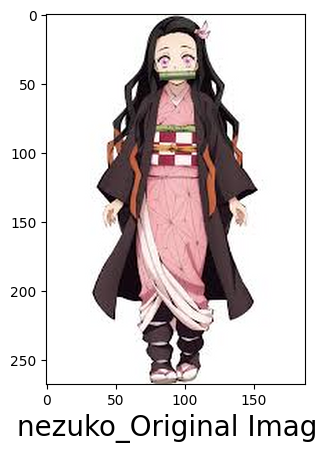

********* Predictions ***********


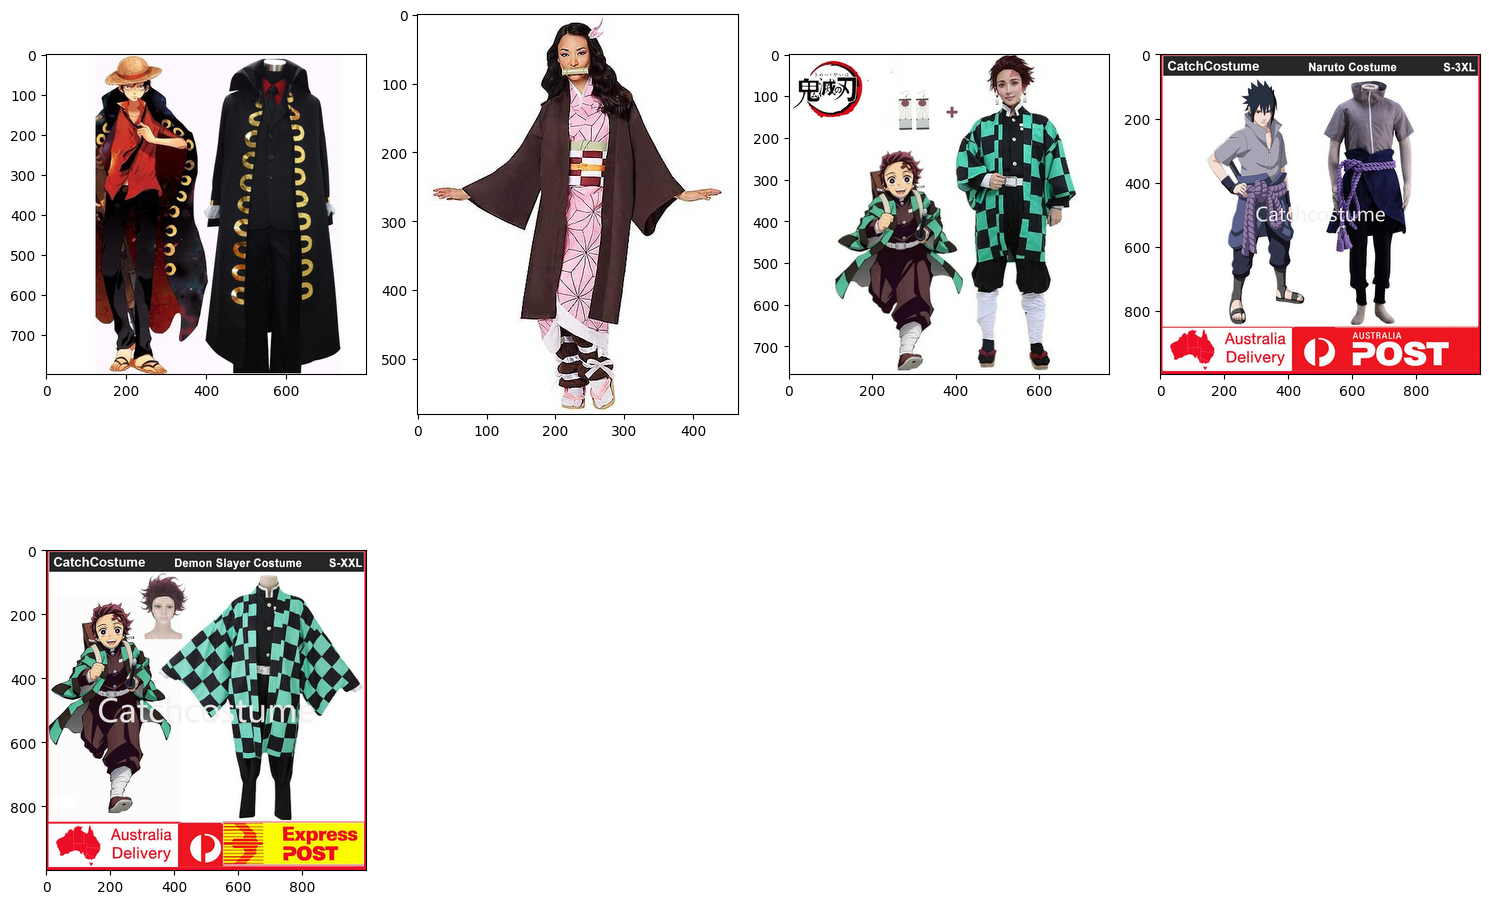

In [ ]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np

def evaluate_similarity_search(true_labels, retrieved_labels, k=5):

    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    for i in range(len(true_labels)):
        true_label = true_labels[i]

        correct_retrievals = sum([1 for label in retrieved_labels[i] if label == true_label])

        precision = correct_retrievals / k
        recall = correct_retrievals / 1  # Each query has one true label
        accuracy = 1 if true_label in retrieved_labels[i] else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_accuracy = np.mean(accuracy_scores)

    return avg_precision, avg_recall, avg_accuracy

true_labels = [filename.split('/')[-2] for filename in filenames]

_, original_indices = neighbors.kneighbors(feature_list)
original_retrieved_labels = [
    [true_labels[idx] for idx in original_indices[i]] for i in range(len(true_labels))
]

_, pca_indices = neighbors_pca_features.kneighbors(compressed_features)
pca_retrieved_labels = [
    [true_labels[idx] for idx in pca_indices[i]] for i in range(len(true_labels))
]

original_metrics = evaluate_similarity_search(true_labels, original_retrieved_labels, k=5)
pca_metrics = evaluate_similarity_search(true_labels, pca_retrieved_labels, k=5)




print("Original Features Metrics:")
print(f"Precision: {original_metrics[0]:.2f}, Recall: {original_metrics[1]:.2f}, Accuracy: {original_metrics[2]:.2f}")

print("\nPCA-Compressed Features Metrics:")
print(f"Precision: {pca_metrics[0]:.2f}, Recall: {pca_metrics[1]:.2f}, Accuracy: {pca_metrics[2]:.2f}")




NameError: name 'neighbors_pca_features' is not defined

Confusion Matrix for Original Features:



Confusion Matrix for PCA-Compressed Features:


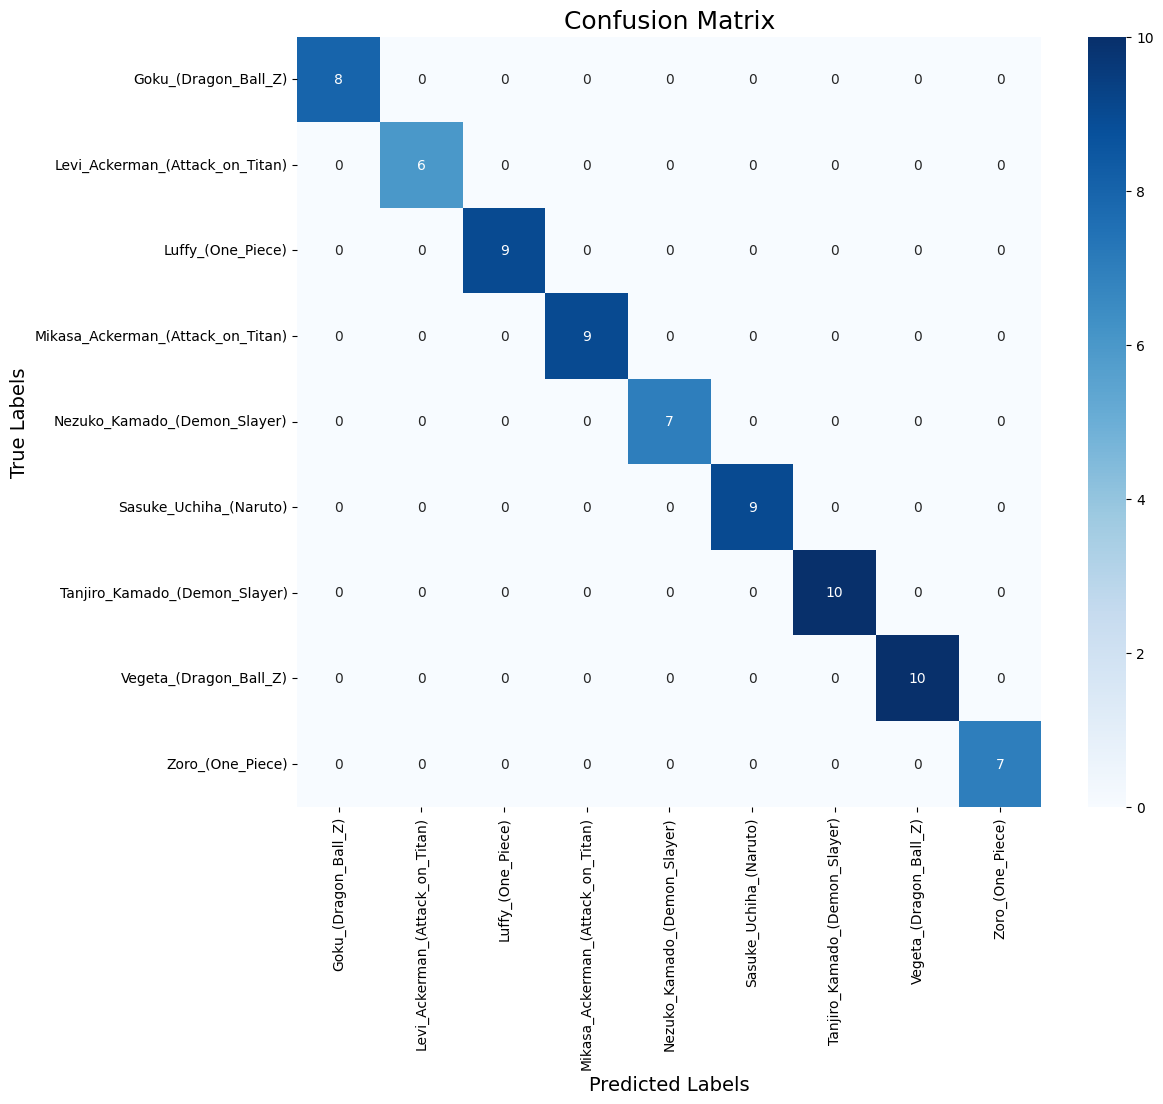

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, retrieved_labels, class_names):
    """
    Plot the confusion matrix for similarity search.
    true_labels: List of ground truth labels for the input images.
    retrieved_labels: List of predicted labels for the most similar image.
    class_names: List of all class names.
    """
    # For simplicity, consider the label of the most similar image
    predicted_labels = [retrieved[0] for retrieved in retrieved_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.show()

# Get unique class names
class_names = sorted(list(set(true_labels)))

# Plot confusion matrix for original features
print("Confusion Matrix for Original Features:")
plot_confusion_matrix(true_labels, original_retrieved_labels, class_names)

# Plot confusion matrix for PCA-compressed features
print("\nConfusion Matrix for PCA-Compressed Features:")
plot_confusion_matrix(true_labels, pca_retrieved_labels, class_names)


## Siamese and Triplets Network

https://medium.com/@hayagriva99999/exploring-siamese-networks-for-image-similarity-using-contrastive-loss-f5d5ae5a0cc6#:~:text=Siamese%20neural%20networks%20are%20a,the%20same%20set%20of%20weights.
https://elcaiseri.medium.com/image-similarity-estimation-using-a-siamese-network-with-triplet-loss-a-practical-guide-124938e24b3a


In [ ]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

from glob import glob

In [ ]:
anchor_images_path = []
positive_images_path = []

for class_ in os.listdir('/content/drive/MyDrive/Caltech101/101_ObjectCategories'):
    class_imgs_path = glob(f'/content/drive/MyDrive/Caltech101/101_ObjectCategories/{class_}/*.jpg')

    if (len(class_imgs_path) % 2):
        class_imgs_path = class_imgs_path[1:]

    n = len(class_imgs_path) // 2

    anchor_images_path.extend(class_imgs_path[:n]) # select some cats as anchors
    positive_images_path.extend(class_imgs_path[n:]) # select some cats as positive samples

    #break

In [ ]:
print('Anchor samples size:', len(anchor_images_path), 'images')
print('Positive samples size:', len(positive_images_path), 'images')

Anchor samples size: 4310 images
Positive samples size: 4310 images


In [ ]:
target_shape = (200,200);
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(anchor_images_path)

positive_images = sorted(positive_images_path)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

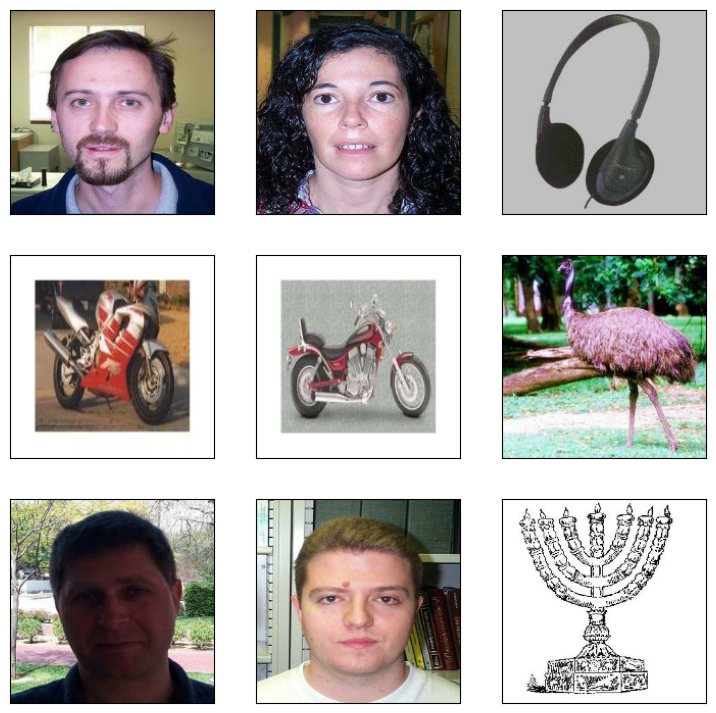

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        # print(anchor[i],positive[i],negative[i])
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
base_cnn = ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

# Freeze all layers until the layer conv5_block1_out
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [ ]:


class DistanceLayer(layers.Layer):
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(respre(anchor_input)),
    embedding(respre(positive_input)),
    embedding(respre(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2873s 26s/step - loss: 0.4484 - val_loss: 0.3357
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2729s 25s/step - loss: 0.2074 - val_loss: 0.3237
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2724s 25s/step - loss: 0.1938 - val_loss: 0.2788
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2552s 23s/step - loss: 0.1522 - val_loss: 0.2550
Epoch 5/10
 24/108 ━━━━━━━━━━━━━━━━━━━━ 27:45 20s/step - loss: 0.1148

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(respre(anchor)),
    embedding(respre(positive)),
    embedding(respre(negative)),
)

In [ ]:
siamese_model.save('siamese_model.h5')

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.neighbors import NearestNeighbors

# Helper function to extract the label from the path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Pick 3-4 random images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

# Generate embeddings using the Siamese model
def generate_embeddings_siamese(filenames, siamese_model):
    """Generate feature embeddings for all images using Siamese Model."""
    features = []
    print("\n=== Generating Feature Embeddings ===")
    for file in tqdm(filenames, desc="Processing Images"):
        # Preprocess the image
        img = image.load_img(file, target_size=(224, 224))  # Match input size
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = respre(expanded_img_array)  # Preprocessor for Siamese

        # Generate embedding
        embedding = siamese_model.siamese_network(preprocessed_img)
        features.append(embedding.numpy()[0])  # Convert to NumPy and flatten
    return np.array(features)

# Fit Nearest Neighbors on embeddings
def fit_knn(features, n_neighbors=5, metric="cosine"):
    """Fit a KNN model on extracted features."""
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    neighbors.fit(features)
    return neighbors

# Similarity search and evaluation
def evaluate_similarity_search(query_images, siamese_model, neighbors, filenames):
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        # Extract the ground-truth label
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(224, 224))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = respre(expanded_img_array)

        # Extract features and perform similarity search
        start_time = time.time()
        query_embedding = siamese_model.siamese_network(preprocessed_img)
        retrieval_time = time.time() - start_time
        _, indices = neighbors.kneighbors(query_embedding.numpy())

        # Collect predicted labels
        predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

        # Calculate precision, recall, and nDCG
        true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
        precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
        recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
        ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

        # Store metrics
        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)
        retrieval_times.append(retrieval_time)

    # Report average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")

# Paths and configurations
folder_path = '/content/drive/MyDrive/Caltech101/Organized_Classes'
query_images = sample_images(folder_path)
filenames = [os.path.join(dp, f) for dp, dn, fn in os.walk(folder_path) for f in fn]  # All filenames in dataset

# Generate embeddings and fit Nearest Neighbors
dataset_features = generate_embeddings_siamese(filenames, siamese_model)
neighbors = fit_knn(dataset_features)

# Evaluate the Siamese model with similarity search
evaluate_similarity_search(query_images, siamese_model, neighbors, filenames)


In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

Positive similarity: 0.9963672
Negative similarity: 0.9941685


In [ ]:
# prompt: # Calculate embeddings for all images in your dataset feature_list calculate it for images in /content/drive/MyDrive/Caltech101/image_cos2 featurelist, filenames datagen, nothing are deifned

import tarfile
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate embeddings for all images in the dataset
feature_list = []
filenames = []
for filename in tqdm(datagen.filenames):
    try:
        img_path = os.path.join(root_dir, filename)
        img = image.load_img(img_path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = respre(expanded_img_array)
        feature = model.predict(preprocessed_img, batch_size=1)
        feature_list.append(feature.flatten())  # Flatten the feature vector
        filenames.append(img_path)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

feature_list = np.array(feature_list)
print("Shape of feature_list:", feature_list.shape)

100%|██████████| 75/75 [00:00<00:00, 1515.74it/s]

Error processing Goku_(Dragon_Ball_Z)/image_1.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_1.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_10.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_10.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_2.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_2.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_3.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_3.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_4.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_4.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_5.jpeg: [Errno 2] No such file or directory: '/content

In [ ]:
# Predict embedding for test image
def predict_embedding(img_path):
    img = image.load_img(img_path, target_size=(target_shape[0], target_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    return embedding.predict(preprocessed_img, batch_size=1)

# Example usage: Upload and predict
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
test_img_features = predict_embedding(img_path)

# Ensure test_img_features has correct shape
print("Test image features shape:", test_img_features.shape)
test_img_features = np.squeeze(test_img_features, axis=0)
print("Test image features shape:", test_img_features.shape)


# Ensure feature_list has correct shape
if 'feature_list' not in locals():
    feature_list = embedding.predict(datagen, steps=len(datagen))
print("Feature list shape:", feature_list.shape)

# Fit NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

# Find similar images
distances, indices = neighbors.kneighbors([test_img_features])  # Add batch dimension
print("Indices of similar images:", indices)

# Display similar images
def similar_images(indices):
    plt.figure(figsize=(15, 10), facecolor='white')
    plotnumber = 1
    for index in indices[0]:  # Unpack first dimension
        if plotnumber <= len(indices[0]):
            ax = plt.subplot(2, 4, plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber += 1
    plt.tight_layout()

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image', fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices)


## Vision Transformer
https://pub.towardsai.net/vision-embedding-comparison-for-image-similarity-search-efficientnet-vs-4eac6bf553c4
https://medium.com/@tapanbabbar/build-an-image-similarity-search-with-transformers-vit-clip-efficientnet-dino-v2-and-blip-2-5040d1848c00
https://medium.com/red-buffer/diving-into-clip-by-creating-semantic-image-search-engines-834c8149de56


In [31]:
!pip install transformers timm torch torchvision


In [32]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
from PIL import Image



feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

def generate_vit_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)  # Send to GPU

        with torch.no_grad():
            outputs = vit_model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # (1, 768) -> (768)
        return cls_embedding.cpu().numpy()  # Move back to CPU for NumPy compatibility
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None



def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False



root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

image_paths = []
# embeddings = []
from tqdm import tqdm
import os

# Initialize tqdm
total_files = sum(len(files) for _, _, files in os.walk(root_dir))  # Count all files
progress_bar = tqdm(total=total_files, desc="Processing Files", unit="file")

image_paths = []

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            image_paths.append(file_path)
        progress_bar.update(1)  # Update progress for each file

progress_bar.close()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing Files: 100%|██████████| 8677/8677 [24:08<00:00,  5.99file/s] 


In [ ]:
print(image_paths)

NameError: name 'image_paths' is not defined

In [ ]:
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

image_paths = []
embeddings = []

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            image_paths.append(file_path)

In [ ]:
feature_list = np.array(embeddings)
print("Num images:", len(image_paths))
print("Shape of feature_list:", feature_list.shape)

Num images: 8677
Shape of feature_list: (8677, 768)


In [ ]:
from google.colab import files
np.save('image_paths.npy', image_paths)  # Save feature_list as a .npy file
files.download('image_paths.npy')  # Download the file to your local system

In [ ]:
# Reduce dimensionality with PCA (optional)
pca = PCA(n_components=128, random_state=42)  # Adjust components as needed
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
!pip install datasketch
from datasketch import MinHashLSH, MinHash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Create LSH index
print("Building LSH index...")
lsh = MinHashLSH(threshold=0.2, num_perm=128)

# Insert images into LSH buckets
for i, embedding in enumerate(reduced_embeddings):
    minhash = MinHash(num_perm=128)
    for value in embedding:
        minhash.update(value.tobytes())
    lsh.insert(f"image_{i}", minhash)


Building LSH index...


In [ ]:
# Query for similar images
def query_similar_images(query_image_path, top_n=5):
    query_embedding = generate_vit_embedding(query_image_path)
    if query_embedding is None:
        print("Error generating embedding for the query image.")
        return

    # Reduce dimensionality of the query embedding
    query_reduced = pca.transform(query_embedding.reshape(1, -1))

    # Create MinHash for the query image
    query_minhash = MinHash(num_perm=128)
    for value in query_reduced[0]:
        query_minhash.update(value.tobytes())

    # Retrieve similar items from LSH
    result_keys = list(lsh.query(query_minhash))
    if not result_keys:
        print("No similar images found.")
        return

    # Retrieve corresponding image paths
    similar_images = [image_paths[int(key.split("_")[1])] for key in result_keys[:top_n]]
    return similar_images

from google.colab import files
uploaded = files.upload()


Saving cat.jpg to cat (2).jpg


In [ ]:

# Example usage
query_image_path = 'cat.jpg'
print("Finding similar images...")
similar_images = query_similar_images(query_image_path)

# Display query and similar images
if similar_images:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 4, 1)
    plt.imshow(mpimg.imread(query_image_path))
    plt.title("Query Image")
    plt.axis('off')

    for i, img_path in enumerate(similar_images):
        plt.subplot(2, 4, i + 2)
        plt.imshow(mpimg.imread(img_path))
        plt.title(f"Similar {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Finding similar images...
No similar images found.


In [33]:

# Load the .npy file into a NumPy array
npy_file_path = "/content/drive/MyDrive/Caltech101/feature_list.npy"

try:
    feature_list = np.load(npy_file_path)
    print("Loaded feature list successfully!")
    print("Shape of the feature list:", feature_list.shape)
except Exception as e:
    print(f"Error loading .npy file: {e}")

Loaded feature list successfully!
Shape of the feature list: (8677, 768)


In [34]:

neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [39]:
from sklearn.metrics import precision_score, recall_score, ndcg_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image


def evaluate_vit_similarity_search(query_images, neighbors, filenames):
    """
    Function to evaluate similarity search using the ViT model and trained kNN.
    """
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation (ViT Model) ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        try:
            # Extract the ground-truth label
            ground_truth_label = extract_label(query_image)

            # Generate ViT embeddings for the query image
            start_time = time.time()
            test_img_features = generate_vit_embedding(query_image)
            if test_img_features is None:
                print(f"Skipping query image {query_image} due to embedding error.")
                continue

            # Perform similarity search
            retrieval_time = time.time() - start_time
            _, indices = neighbors.kneighbors([test_img_features])

            # Collect predicted labels
            predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

            # Calculate precision, recall, and nDCG
            true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
            precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
            recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
            ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])
            print(precision)
            # Store metrics
            precision_scores.append(precision)
            recall_scores.append(recall)
            ndcg_scores.append(ndcg)
            retrieval_times.append(retrieval_time)

            # Optional: Display query and top retrieved images
            # plt.figure(figsize=(15, 5))
            # plt.subplot(1, len(indices[0]) + 1, 1)
            # plt.imshow(Image.open(query_image))
            # plt.title(f"Query: {ground_truth_label}")
            # plt.axis('off')
            # for i, idx in enumerate(indices[0]):
            #     plt.subplot(1, len(indices[0]) + 1, i + 2)
            #     plt.imshow(Image.open(filenames[idx]))
            #     plt.title(f"Match {i + 1}")
            #     plt.axis('off')
            # plt.show()

        except Exception as e:
            print(f"Error processing {query_image}: {e}")
            continue

    # Report average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")


# Example Usage:
# Assuming query_images is a list of test image paths, neighbors is the trained kNN model,
# and filenames is the list of all file paths used for similarity search.

query_images = sample_images('/content/drive/MyDrive/Caltech101/101_ObjectCategories')
evaluate_vit_similarity_search(query_images, neighbors, image_paths)



=== Starting Similarity Search Evaluation (ViT Model) ===


Processing Query Images:   0%|          | 1/303 [00:01<05:22,  1.07s/it]

0.4


Processing Query Images:   1%|          | 2/303 [00:02<05:18,  1.06s/it]

1.0


Processing Query Images:   1%|          | 3/303 [00:03<06:34,  1.31s/it]

1.0


Processing Query Images:   1%|▏         | 4/303 [00:05<07:50,  1.57s/it]

1.0


Processing Query Images:   1%|▏         | 4/303 [00:06<08:07,  1.63s/it]


KeyboardInterrupt: 

In [43]:
import os
import csv
import time
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, ndcg_score
from PIL import Image

# Helper function to extract the "ClassName" from the path
def extract_class_name(img_path):
    return os.path.basename(os.path.dirname(os.path.dirname(img_path)))

def save_metrics_to_csv(metrics, output_file):
    """
    Save metrics to a CSV file.
    """
    headers = ["Class", "Precision", "Recall", "nDCG", "Retrieval Time"]
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        writer.writerows(metrics)

# Updated Function to Evaluate and Store Class-Wise Metrics
def evaluate_similarity_by_class(query_images, model, neighbors, filenames, folder_path, output_csv):
    """
    Evaluate similarity search using ViT or other models and save metrics for each class to a CSV file.
    """
    class_metrics = []

    # Get all "ClassName" folders (parent folders)
    class_folders = [os.path.join(folder_path, class_name)
                     for class_name in os.listdir(folder_path)
                     if os.path.isdir(os.path.join(folder_path, class_name))]

    print("\n=== Starting Class-Wise Similarity Search Evaluation ===")
    for class_folder in tqdm(class_folders, desc="Processing Classes"):
        class_name = os.path.basename(class_folder)

        # Filter query images belonging to the current "ClassName"
        class_query_images = [img for img in query_images if extract_class_name(img) == class_name]

        # Initialize metrics for this class
        precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

        for query_image in class_query_images:
            try:
                # Extract the ground-truth "ClassName"
                ground_truth_class = extract_label(query_image)

                # Generate ViT embeddings or preprocess the query image
                start_time = time.time()
                test_img_features = generate_vit_embedding(query_image)
                retrieval_time = time.time() - start_time

                # Perform similarity search
                _, indices = neighbors.kneighbors([test_img_features])

                # Collect predicted labels (use "ClassName" as labels)
                predicted_classes = [extract_label(filenames[idx]) for idx in indices[0]]

                # Calculate precision, recall, and nDCG
                true_labels = [1 if label == ground_truth_class else 0 for label in predicted_classes]
                precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
                recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
                ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

                # Store metrics
                precision_scores.append(precision)
                recall_scores.append(recall)
                ndcg_scores.append(ndcg)
                retrieval_times.append(retrieval_time)

            except Exception as e:
                print(f"Error processing query image {query_image}: {e}")
                continue

        # Average metrics for this "ClassName"
        avg_precision = np.mean(precision_scores) if precision_scores else 0
        avg_recall = np.mean(recall_scores) if recall_scores else 0
        avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0
        avg_retrieval_time = np.mean(retrieval_times) if retrieval_times else 0

        # Store in the metrics list
        class_metrics.append([class_name, avg_precision, avg_recall, avg_ndcg, avg_retrieval_time])

        # Display progress
        print(f"\nClass: {class_name}")
        print(f"Precision: {avg_precision:.2f}, Recall: {avg_recall:.2f}, nDCG: {avg_ndcg:.2f}, Retrieval Time: {avg_retrieval_time:.2f}s")

    # Save to CSV
    save_metrics_to_csv(class_metrics, output_csv)
    print(f"\nEvaluation results saved to {output_csv}")


# Example Usage
folder_path = '/content/drive/MyDrive/Caltech101/Organized_Classes'
query_images = sample_images(folder_path, num_samples=3)  # Adjust num_samples as needed
output_csv = "similarity_search_metrics.csv"

# Evaluate and save metrics
evaluate_similarity_by_class(query_images, vit_model, neighbors, image_paths, folder_path, output_csv)


=== Starting Class-Wise Similarity Search Evaluation ===


Processing Classes:  12%|█▎        | 1/8 [00:33<03:57, 33.90s/it]


Class: Miscellaneous
Precision: 0.96, Recall: 1.00, nDCG: 0.98, Retrieval Time: 0.92s


Processing Classes:  25%|██▌       | 2/8 [02:47<09:16, 92.80s/it]


Class: Animals
Precision: 0.90, Recall: 1.00, nDCG: 0.96, Retrieval Time: 1.21s


Processing Classes:  38%|███▊      | 3/8 [03:28<05:45, 69.03s/it]


Class: Electronics
Precision: 0.98, Recall: 1.00, nDCG: 0.99, Retrieval Time: 0.95s


Processing Classes:  50%|█████     | 4/8 [04:08<03:49, 57.38s/it]


Class: Vehicles
Precision: 0.97, Recall: 1.00, nDCG: 0.99, Retrieval Time: 0.99s


Processing Classes:  62%|██████▎   | 5/8 [05:01<02:48, 56.03s/it]


Class: Nature
Precision: 0.92, Recall: 1.00, nDCG: 0.96, Retrieval Time: 0.92s


Processing Classes:  75%|███████▌  | 6/8 [05:10<01:20, 40.02s/it]


Class: Furniture
Precision: 0.96, Recall: 1.00, nDCG: 0.98, Retrieval Time: 0.97s


Processing Classes:  88%|████████▊ | 7/8 [05:16<00:28, 28.81s/it]


Class: Clothes
Precision: 0.87, Recall: 1.00, nDCG: 0.95, Retrieval Time: 0.93s


Processing Classes: 100%|██████████| 8/8 [05:23<00:00, 40.41s/it]


Class: Appliances
Precision: 0.93, Recall: 1.00, nDCG: 0.97, Retrieval Time: 1.12s

Evaluation results saved to similarity_search_metrics.csv


In [44]:
files.download("similarity_search_metrics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Indices of similar images: [[5725 5726 5721 5723 5733]]


FileNotFoundError: [Errno 2] No such file or directory: '/content/joshua_tree/image_0001.jpg'

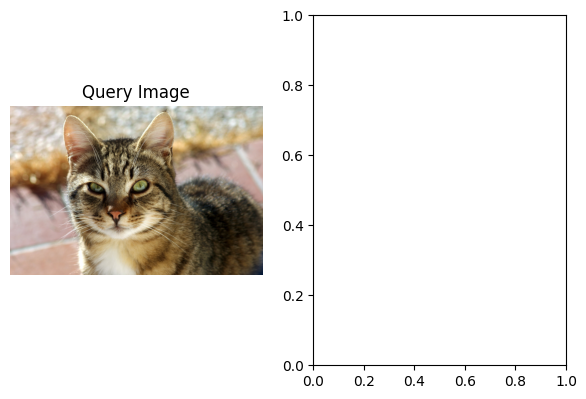

In [ ]:
# Predict similar images for a given query image
query_image_path = 'cat.jpg'
query_embedding = generate_vit_embedding(query_image_path)
if query_embedding is not None:
    distances, indices = neighbors.kneighbors([query_embedding])  # Add batch dimension
    print("Indices of similar images:", indices)

    # Display similar images
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    def display_similar_images(indices, query_image_path):
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(mpimg.imread(query_image_path))
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(indices[0]):
            plt.subplot(2, 4, i + 2)
            plt.imshow(mpimg.imread(datagen.filenames[idx]))
            plt.title(f"Similar {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    display_similar_images(indices, query_image_path)


In [ ]:
import os
import math
import numpy as np
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.neighbors import NearestNeighbors
from transformers import ViTFeatureExtractor, ViTModel
import torch
from sklearn.metrics import precision_score, recall_score, ndcg_score
import matplotlib.pyplot as plt



# Helper function to extract the label from the path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Pick 3-4 random images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# Function to validate image files and catch UnidentifiedImageError
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

def evaluate_vit_similarity_search(query_images, neighbors, filenames):
    """
    Evaluate similarity search using pre-trained ViT model and already trained kNN.

    Parameters:
    - query_images: List of query image paths.
    - neighbors: Pre-trained kNN model.
    - filenames: List of all file paths used in similarity search.

    Outputs:
    - Prints evaluation metrics: Precision, Recall, nDCG, and average retrieval time.
    """
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation (ViT Model) ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        try:
            # Extract the ground-truth label
            ground_truth_label = extract_label(query_image)
            print(ground_truth_label)
            # Generate ViT embedding for the query image
            start_time = time.time()
            test_img_features = generate_vit_embedding(query_image)  # Pre-trained ViT used here
            if test_img_features is None:
                print(f"Skipping query image {query_image} due to embedding error.")
                continue
            retrieval_time = time.time() - start_time

            # Perform similarity search using pre-trained kNN
            _, indices = neighbors.kneighbors([test_img_features])
            # print(indices)

            # Extract predicted labels from retrieved indices
            predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]
            # print(predicted_labels)
            # Calculate true labels for metrics
            true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
            # print(true_labels)
            # Calculate metrics
            precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
            recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
            ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

            # print(precision,recall, ndcg)
            # Store metrics and retrieval time
            precision_scores.append(precision)
            recall_scores.append(recall)
            ndcg_scores.append(ndcg)
            retrieval_times.append(retrieval_time)

        except Exception as e:
            print(f"Error processing {query_image}: {e}")
            continue

    # Report average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")


# Example Usage:
# Assuming `query_images` is a list of test image paths, `neighbors` is the pre-trained kNN model,
# and `filenames` is the list of all file paths used for similarity search.

query_images = sample_images('/content/drive/MyDrive/Caltech101/101_ObjectCategories')
evaluate_vit_similarity_search(query_images, neighbors, image_paths)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Starting Similarity Search Evaluation (ViT Model) ===


Processing Query Images:   0%|          | 0/303 [00:00<?, ?it/s]

anchor


Processing Query Images:   0%|          | 1/303 [00:00<03:57,  1.27it/s]

anchor


Processing Query Images:   1%|          | 2/303 [00:01<03:55,  1.28it/s]

anchor


Processing Query Images:   1%|          | 3/303 [00:02<03:53,  1.28it/s]

ant


Processing Query Images:   1%|▏         | 4/303 [00:03<03:49,  1.30it/s]

ant


Processing Query Images:   2%|▏         | 5/303 [00:04<04:19,  1.15it/s]

ant


Processing Query Images:   2%|▏         | 6/303 [00:05<04:52,  1.01it/s]

barrel


Processing Query Images:   2%|▏         | 7/303 [00:06<05:11,  1.05s/it]

barrel


Processing Query Images:   3%|▎         | 8/303 [00:07<05:23,  1.10s/it]

barrel


Processing Query Images:   3%|▎         | 9/303 [00:08<05:33,  1.13s/it]

bass


Processing Query Images:   3%|▎         | 10/303 [00:10<05:31,  1.13s/it]

bass


Processing Query Images:   4%|▎         | 11/303 [00:10<04:57,  1.02s/it]

bass


Processing Query Images:   4%|▍         | 12/303 [00:11<04:33,  1.07it/s]

beaver


Processing Query Images:   4%|▍         | 13/303 [00:12<04:17,  1.13it/s]

beaver


Processing Query Images:   5%|▍         | 14/303 [00:13<04:06,  1.17it/s]

beaver


Processing Query Images:   5%|▍         | 15/303 [00:13<03:57,  1.21it/s]

binocular


Processing Query Images:   5%|▌         | 16/303 [00:14<03:50,  1.24it/s]

binocular


Processing Query Images:   6%|▌         | 17/303 [00:15<03:47,  1.26it/s]

binocular


Processing Query Images:   6%|▌         | 18/303 [00:16<03:44,  1.27it/s]

bonsai


Processing Query Images:   6%|▋         | 19/303 [00:16<03:42,  1.28it/s]

bonsai


Processing Query Images:   7%|▋         | 20/303 [00:17<03:51,  1.22it/s]

bonsai


Processing Query Images:   7%|▋         | 21/303 [00:18<03:46,  1.24it/s]

brain


Processing Query Images:   7%|▋         | 22/303 [00:19<03:43,  1.26it/s]

brain


Processing Query Images:   8%|▊         | 23/303 [00:20<03:50,  1.21it/s]

brain


Processing Query Images:   8%|▊         | 24/303 [00:21<04:23,  1.06it/s]

brontosaurus


Processing Query Images:   8%|▊         | 25/303 [00:22<04:46,  1.03s/it]

brontosaurus


Processing Query Images:   9%|▊         | 26/303 [00:23<04:57,  1.08s/it]

brontosaurus


Processing Query Images:   9%|▉         | 27/303 [00:25<05:05,  1.11s/it]

buddha


Processing Query Images:   9%|▉         | 28/303 [00:26<05:06,  1.11s/it]

buddha


Processing Query Images:  10%|▉         | 29/303 [00:27<04:37,  1.01s/it]

buddha


Processing Query Images:  10%|▉         | 30/303 [00:27<04:17,  1.06it/s]

butterfly


Processing Query Images:  10%|█         | 31/303 [00:28<04:00,  1.13it/s]

butterfly


Processing Query Images:  11%|█         | 32/303 [00:29<03:51,  1.17it/s]

butterfly


Processing Query Images:  11%|█         | 33/303 [00:30<03:43,  1.21it/s]

camera


Processing Query Images:  11%|█         | 34/303 [00:30<03:38,  1.23it/s]

camera


Processing Query Images:  12%|█▏        | 35/303 [00:31<03:32,  1.26it/s]

camera


Processing Query Images:  12%|█▏        | 36/303 [00:32<03:32,  1.26it/s]

cannon


Processing Query Images:  12%|█▏        | 37/303 [00:33<03:29,  1.27it/s]

cannon


Processing Query Images:  13%|█▎        | 38/303 [00:34<03:29,  1.26it/s]

cannon


Processing Query Images:  13%|█▎        | 39/303 [00:34<03:26,  1.28it/s]

car_side


Processing Query Images:  13%|█▎        | 40/303 [00:35<03:24,  1.28it/s]

car_side


Processing Query Images:  14%|█▎        | 41/303 [00:36<03:29,  1.25it/s]

car_side


Processing Query Images:  14%|█▍        | 42/303 [00:37<04:01,  1.08it/s]

ceiling_fan


Processing Query Images:  14%|█▍        | 43/303 [00:38<04:23,  1.02s/it]

ceiling_fan


Processing Query Images:  15%|█▍        | 44/303 [00:40<04:37,  1.07s/it]

ceiling_fan


Processing Query Images:  15%|█▍        | 45/303 [00:41<04:44,  1.10s/it]

cellphone


Processing Query Images:  15%|█▌        | 46/303 [00:42<04:50,  1.13s/it]

cellphone


Processing Query Images:  16%|█▌        | 47/303 [00:43<04:31,  1.06s/it]

cellphone


Processing Query Images:  16%|█▌        | 48/303 [00:44<04:07,  1.03it/s]

chair


Processing Query Images:  16%|█▌        | 49/303 [00:44<03:50,  1.10it/s]

chair


Processing Query Images:  17%|█▋        | 50/303 [00:45<03:39,  1.15it/s]

chair


Processing Query Images:  17%|█▋        | 51/303 [00:46<03:31,  1.19it/s]

chandelier


Processing Query Images:  17%|█▋        | 52/303 [00:47<03:25,  1.22it/s]

chandelier


Processing Query Images:  17%|█▋        | 53/303 [00:47<03:21,  1.24it/s]

chandelier


Processing Query Images:  18%|█▊        | 54/303 [00:48<03:18,  1.26it/s]

cougar_face


Processing Query Images:  18%|█▊        | 55/303 [00:49<03:14,  1.27it/s]

cougar_face


Processing Query Images:  18%|█▊        | 56/303 [00:50<03:12,  1.28it/s]

cougar_face


Processing Query Images:  19%|█▉        | 57/303 [00:50<03:12,  1.28it/s]

crab


Processing Query Images:  19%|█▉        | 58/303 [00:51<03:10,  1.29it/s]

crab


Processing Query Images:  19%|█▉        | 59/303 [00:52<03:07,  1.30it/s]

crab


Processing Query Images:  20%|█▉        | 60/303 [00:53<03:26,  1.18it/s]

crayfish


Processing Query Images:  20%|██        | 61/303 [00:54<03:51,  1.05it/s]

crayfish


Processing Query Images:  20%|██        | 62/303 [00:55<04:08,  1.03s/it]

crayfish


Processing Query Images:  21%|██        | 63/303 [00:57<04:18,  1.08s/it]

crocodile


Processing Query Images:  21%|██        | 64/303 [00:58<04:29,  1.13s/it]

crocodile


Processing Query Images:  21%|██▏       | 65/303 [00:59<04:35,  1.16s/it]

crocodile


Processing Query Images:  22%|██▏       | 66/303 [01:00<04:10,  1.06s/it]

crocodile_head


Processing Query Images:  22%|██▏       | 67/303 [01:01<03:49,  1.03it/s]

crocodile_head


Processing Query Images:  22%|██▏       | 68/303 [01:01<03:34,  1.09it/s]

crocodile_head


Processing Query Images:  23%|██▎       | 69/303 [01:02<03:23,  1.15it/s]

cup


Processing Query Images:  23%|██▎       | 70/303 [01:03<03:16,  1.18it/s]

cup


Processing Query Images:  23%|██▎       | 71/303 [01:04<03:10,  1.22it/s]

cup


Processing Query Images:  24%|██▍       | 72/303 [01:05<03:06,  1.24it/s]

dalmatian


Processing Query Images:  24%|██▍       | 73/303 [01:05<03:03,  1.26it/s]

dalmatian


Processing Query Images:  24%|██▍       | 74/303 [01:06<03:00,  1.27it/s]

dalmatian


Processing Query Images:  25%|██▍       | 75/303 [01:07<02:58,  1.28it/s]

dollar_bill


Processing Query Images:  25%|██▌       | 76/303 [01:08<02:56,  1.28it/s]

dollar_bill


Processing Query Images:  25%|██▌       | 77/303 [01:08<02:55,  1.29it/s]

dollar_bill


Processing Query Images:  26%|██▌       | 78/303 [01:09<03:05,  1.21it/s]

dolphin


Processing Query Images:  26%|██▌       | 79/303 [01:11<03:31,  1.06it/s]

dolphin


Processing Query Images:  26%|██▋       | 80/303 [01:12<03:48,  1.02s/it]

dolphin


Processing Query Images:  27%|██▋       | 81/303 [01:13<03:57,  1.07s/it]

dragonfly


Processing Query Images:  27%|██▋       | 82/303 [01:14<04:04,  1.11s/it]

dragonfly


Processing Query Images:  27%|██▋       | 83/303 [01:15<04:07,  1.13s/it]

dragonfly


Processing Query Images:  28%|██▊       | 84/303 [01:16<03:43,  1.02s/it]

electric_guitar


Processing Query Images:  28%|██▊       | 85/303 [01:17<03:25,  1.06it/s]

electric_guitar


Processing Query Images:  28%|██▊       | 86/303 [01:18<03:14,  1.12it/s]

electric_guitar


Processing Query Images:  29%|██▊       | 87/303 [01:18<03:04,  1.17it/s]

elephant


Processing Query Images:  29%|██▉       | 88/303 [01:19<02:59,  1.20it/s]

elephant


Processing Query Images:  29%|██▉       | 89/303 [01:20<02:54,  1.23it/s]

elephant


Processing Query Images:  30%|██▉       | 90/303 [01:21<02:51,  1.24it/s]

emu


Processing Query Images:  30%|███       | 91/303 [01:22<02:47,  1.26it/s]

emu


Processing Query Images:  30%|███       | 92/303 [01:22<02:45,  1.27it/s]

emu


Processing Query Images:  31%|███       | 93/303 [01:23<02:44,  1.27it/s]

euphonium


Processing Query Images:  31%|███       | 94/303 [01:24<02:43,  1.28it/s]

euphonium


Processing Query Images:  31%|███▏      | 95/303 [01:25<02:41,  1.29it/s]

euphonium


Processing Query Images:  32%|███▏      | 96/303 [01:25<02:41,  1.28it/s]

ewer


Processing Query Images:  32%|███▏      | 97/303 [01:27<03:06,  1.11it/s]

ewer


Processing Query Images:  32%|███▏      | 98/303 [01:28<03:25,  1.00s/it]

ewer


Processing Query Images:  33%|███▎      | 99/303 [01:29<03:37,  1.07s/it]

ferry


Processing Query Images:  33%|███▎      | 100/303 [01:30<03:43,  1.10s/it]

ferry


Processing Query Images:  33%|███▎      | 101/303 [01:31<03:47,  1.13s/it]

ferry


Processing Query Images:  34%|███▎      | 102/303 [01:32<03:32,  1.06s/it]

flamingo


Processing Query Images:  34%|███▍      | 103/303 [01:33<03:14,  1.03it/s]

flamingo


Processing Query Images:  34%|███▍      | 104/303 [01:34<03:03,  1.09it/s]

flamingo


Processing Query Images:  35%|███▍      | 105/303 [01:35<02:53,  1.14it/s]

garfield


Processing Query Images:  35%|███▍      | 106/303 [01:35<02:46,  1.18it/s]

garfield


Processing Query Images:  35%|███▌      | 107/303 [01:36<02:40,  1.22it/s]

garfield


Processing Query Images:  36%|███▌      | 108/303 [01:37<02:37,  1.24it/s]

flamingo_head


Processing Query Images:  36%|███▌      | 109/303 [01:38<02:35,  1.25it/s]

flamingo_head


Processing Query Images:  36%|███▋      | 110/303 [01:39<02:33,  1.25it/s]

flamingo_head


Processing Query Images:  37%|███▋      | 111/303 [01:39<02:31,  1.27it/s]

gerenuk


Processing Query Images:  37%|███▋      | 112/303 [01:40<02:30,  1.27it/s]

gerenuk


Processing Query Images:  37%|███▋      | 113/303 [01:41<02:30,  1.26it/s]

gerenuk


Processing Query Images:  38%|███▊      | 114/303 [01:42<02:30,  1.26it/s]

gramophone


Processing Query Images:  38%|███▊      | 115/303 [01:43<02:51,  1.10it/s]

gramophone


Processing Query Images:  38%|███▊      | 116/303 [01:44<03:07,  1.00s/it]

gramophone


Processing Query Images:  39%|███▊      | 117/303 [01:45<03:17,  1.06s/it]

grand_piano


Processing Query Images:  39%|███▉      | 118/303 [01:46<03:23,  1.10s/it]

grand_piano


Processing Query Images:  39%|███▉      | 119/303 [01:48<03:28,  1.13s/it]

grand_piano


Processing Query Images:  40%|███▉      | 120/303 [01:49<03:18,  1.08s/it]

hawksbill


Processing Query Images:  40%|███▉      | 121/303 [01:49<03:00,  1.01it/s]

hawksbill


Processing Query Images:  40%|████      | 122/303 [01:50<02:47,  1.08it/s]

hawksbill


Processing Query Images:  41%|████      | 123/303 [01:51<02:38,  1.14it/s]

headphone


Processing Query Images:  41%|████      | 124/303 [01:52<02:31,  1.18it/s]

headphone


Processing Query Images:  41%|████▏     | 125/303 [01:53<02:26,  1.21it/s]

headphone


Processing Query Images:  42%|████▏     | 126/303 [01:53<02:23,  1.24it/s]

hedgehog


Processing Query Images:  42%|████▏     | 127/303 [01:54<02:19,  1.26it/s]

hedgehog


Processing Query Images:  42%|████▏     | 128/303 [01:55<02:17,  1.27it/s]

hedgehog


Processing Query Images:  43%|████▎     | 129/303 [01:56<02:16,  1.28it/s]

helicopter


Processing Query Images:  43%|████▎     | 130/303 [01:56<02:14,  1.29it/s]

helicopter


Processing Query Images:  43%|████▎     | 131/303 [01:57<02:12,  1.30it/s]

helicopter


Processing Query Images:  44%|████▎     | 132/303 [01:58<02:11,  1.30it/s]

ibis


Processing Query Images:  44%|████▍     | 133/303 [01:59<02:19,  1.21it/s]

ibis


Processing Query Images:  44%|████▍     | 134/303 [02:00<02:39,  1.06it/s]

ibis


Processing Query Images:  45%|████▍     | 135/303 [02:01<02:52,  1.03s/it]

inline_skate


Processing Query Images:  45%|████▍     | 136/303 [02:02<02:59,  1.08s/it]

inline_skate


Processing Query Images:  45%|████▌     | 137/303 [02:04<03:02,  1.10s/it]

inline_skate


Processing Query Images:  46%|████▌     | 138/303 [02:05<03:00,  1.10s/it]

joshua_tree


Processing Query Images:  46%|████▌     | 139/303 [02:05<02:43,  1.00it/s]

joshua_tree


Processing Query Images:  46%|████▌     | 140/303 [02:06<02:31,  1.08it/s]

joshua_tree


Processing Query Images:  47%|████▋     | 141/303 [02:07<02:22,  1.14it/s]

kangaroo


Processing Query Images:  47%|████▋     | 142/303 [02:08<02:15,  1.19it/s]

kangaroo


Processing Query Images:  47%|████▋     | 143/303 [02:09<02:11,  1.22it/s]

kangaroo


Processing Query Images:  48%|████▊     | 144/303 [02:09<02:07,  1.25it/s]

ketch


Processing Query Images:  48%|████▊     | 145/303 [02:10<02:04,  1.27it/s]

ketch


Processing Query Images:  48%|████▊     | 146/303 [02:11<02:02,  1.29it/s]

ketch


Processing Query Images:  49%|████▊     | 147/303 [02:12<02:01,  1.29it/s]

lamp


Processing Query Images:  49%|████▉     | 148/303 [02:12<02:00,  1.29it/s]

lamp


Processing Query Images:  49%|████▉     | 149/303 [02:13<01:59,  1.29it/s]

lamp


Processing Query Images:  50%|████▉     | 150/303 [02:14<01:57,  1.30it/s]

laptop


Processing Query Images:  50%|████▉     | 151/303 [02:15<02:01,  1.25it/s]

laptop


Processing Query Images:  50%|█████     | 152/303 [02:16<02:19,  1.08it/s]

laptop


Processing Query Images:  50%|█████     | 153/303 [02:17<02:32,  1.01s/it]

llama


Processing Query Images:  51%|█████     | 154/303 [02:18<02:40,  1.07s/it]

llama


Processing Query Images:  51%|█████     | 155/303 [02:20<02:46,  1.12s/it]

llama


Processing Query Images:  51%|█████▏    | 156/303 [02:21<02:43,  1.12s/it]

lobster


Processing Query Images:  52%|█████▏    | 157/303 [02:22<02:27,  1.01s/it]

lobster


Processing Query Images:  52%|█████▏    | 158/303 [02:22<02:16,  1.06it/s]

lobster


Processing Query Images:  52%|█████▏    | 159/303 [02:23<02:08,  1.12it/s]

lotus


Processing Query Images:  53%|█████▎    | 160/303 [02:24<02:02,  1.17it/s]

lotus


Processing Query Images:  53%|█████▎    | 161/303 [02:25<01:57,  1.21it/s]

lotus


Processing Query Images:  53%|█████▎    | 162/303 [02:25<01:54,  1.23it/s]

mandolin


Processing Query Images:  54%|█████▍    | 163/303 [02:26<01:52,  1.25it/s]

mandolin


Processing Query Images:  54%|█████▍    | 164/303 [02:27<01:49,  1.26it/s]

mandolin


Processing Query Images:  54%|█████▍    | 165/303 [02:28<01:47,  1.28it/s]

mayfly


Processing Query Images:  55%|█████▍    | 166/303 [02:28<01:47,  1.28it/s]

mayfly


Processing Query Images:  55%|█████▌    | 167/303 [02:29<01:46,  1.28it/s]

mayfly


Processing Query Images:  55%|█████▌    | 168/303 [02:30<01:44,  1.29it/s]

menorah


Processing Query Images:  56%|█████▌    | 169/303 [02:31<01:47,  1.24it/s]

menorah


Processing Query Images:  56%|█████▌    | 170/303 [02:32<02:04,  1.07it/s]

menorah


Processing Query Images:  56%|█████▋    | 171/303 [02:33<02:14,  1.02s/it]

metronome


Processing Query Images:  57%|█████▋    | 172/303 [02:35<02:21,  1.08s/it]

metronome


Processing Query Images:  57%|█████▋    | 173/303 [02:36<02:24,  1.11s/it]

metronome


Processing Query Images:  57%|█████▋    | 174/303 [02:37<02:21,  1.10s/it]

minaret


Processing Query Images:  58%|█████▊    | 175/303 [02:38<02:08,  1.00s/it]

minaret


Processing Query Images:  58%|█████▊    | 176/303 [02:38<01:58,  1.07it/s]

minaret


Processing Query Images:  58%|█████▊    | 177/303 [02:39<01:51,  1.13it/s]

nautilus


Processing Query Images:  59%|█████▊    | 178/303 [02:40<01:47,  1.16it/s]

nautilus


Processing Query Images:  59%|█████▉    | 179/303 [02:41<01:44,  1.19it/s]

nautilus


Processing Query Images:  59%|█████▉    | 180/303 [02:42<01:41,  1.22it/s]

octopus


Processing Query Images:  60%|█████▉    | 181/303 [02:42<01:39,  1.23it/s]

octopus


Processing Query Images:  60%|██████    | 182/303 [02:43<01:37,  1.24it/s]

octopus


Processing Query Images:  60%|██████    | 183/303 [02:44<01:35,  1.26it/s]

okapi


Processing Query Images:  61%|██████    | 184/303 [02:45<01:34,  1.26it/s]

okapi


Processing Query Images:  61%|██████    | 185/303 [02:45<01:32,  1.27it/s]

okapi


Processing Query Images:  61%|██████▏   | 186/303 [02:46<01:31,  1.28it/s]

panda


Processing Query Images:  62%|██████▏   | 187/303 [02:47<01:37,  1.19it/s]

panda


Processing Query Images:  62%|██████▏   | 188/303 [02:48<01:49,  1.05it/s]

panda


Processing Query Images:  62%|██████▏   | 189/303 [02:50<01:57,  1.03s/it]

pagoda


Processing Query Images:  63%|██████▎   | 190/303 [02:51<02:01,  1.07s/it]

pagoda


Processing Query Images:  63%|██████▎   | 191/303 [02:52<02:03,  1.11s/it]

pagoda


Processing Query Images:  63%|██████▎   | 192/303 [02:53<02:05,  1.13s/it]

pigeon


Processing Query Images:  64%|██████▎   | 193/303 [02:54<01:51,  1.02s/it]

pigeon


Processing Query Images:  64%|██████▍   | 194/303 [02:55<01:43,  1.06it/s]

pigeon


Processing Query Images:  64%|██████▍   | 195/303 [02:55<01:36,  1.12it/s]

pizza


Processing Query Images:  65%|██████▍   | 196/303 [02:56<01:31,  1.17it/s]

pizza


Processing Query Images:  65%|██████▌   | 197/303 [02:57<01:28,  1.20it/s]

pizza


Processing Query Images:  65%|██████▌   | 198/303 [02:58<01:25,  1.23it/s]

platypus


Processing Query Images:  66%|██████▌   | 199/303 [02:59<01:23,  1.25it/s]

platypus


Processing Query Images:  66%|██████▌   | 200/303 [02:59<01:21,  1.27it/s]

platypus


Processing Query Images:  66%|██████▋   | 201/303 [03:00<01:20,  1.27it/s]

pyramid


Processing Query Images:  67%|██████▋   | 202/303 [03:01<01:19,  1.28it/s]

pyramid


Processing Query Images:  67%|██████▋   | 203/303 [03:02<01:18,  1.27it/s]

pyramid


Processing Query Images:  67%|██████▋   | 204/303 [03:02<01:16,  1.29it/s]

revolver


Processing Query Images:  68%|██████▊   | 205/303 [03:03<01:17,  1.26it/s]

revolver


Processing Query Images:  68%|██████▊   | 206/303 [03:04<01:28,  1.09it/s]

revolver


Processing Query Images:  68%|██████▊   | 207/303 [03:06<01:36,  1.01s/it]

rhino


Processing Query Images:  69%|██████▊   | 208/303 [03:07<01:41,  1.07s/it]

rhino


Processing Query Images:  69%|██████▉   | 209/303 [03:08<01:44,  1.11s/it]

rhino


Processing Query Images:  69%|██████▉   | 210/303 [03:09<01:44,  1.12s/it]

rooster


Processing Query Images:  70%|██████▉   | 211/303 [03:10<01:34,  1.03s/it]

rooster


Processing Query Images:  70%|██████▉   | 212/303 [03:11<01:26,  1.05it/s]

rooster


Processing Query Images:  70%|███████   | 213/303 [03:12<01:20,  1.12it/s]

saxophone


Processing Query Images:  71%|███████   | 214/303 [03:12<01:16,  1.16it/s]

saxophone


Processing Query Images:  71%|███████   | 215/303 [03:13<01:13,  1.20it/s]

saxophone


Processing Query Images:  71%|███████▏  | 216/303 [03:14<01:10,  1.23it/s]

schooner


Processing Query Images:  72%|███████▏  | 217/303 [03:15<01:09,  1.25it/s]

schooner


Processing Query Images:  72%|███████▏  | 218/303 [03:15<01:07,  1.26it/s]

schooner


Processing Query Images:  72%|███████▏  | 219/303 [03:16<01:06,  1.26it/s]

scissors


Processing Query Images:  73%|███████▎  | 220/303 [03:17<01:05,  1.26it/s]

scissors


Processing Query Images:  73%|███████▎  | 221/303 [03:18<01:05,  1.26it/s]

scissors


Processing Query Images:  73%|███████▎  | 222/303 [03:19<01:04,  1.26it/s]

scorpion


Processing Query Images:  74%|███████▎  | 223/303 [03:19<01:03,  1.25it/s]

scorpion


Processing Query Images:  74%|███████▍  | 224/303 [03:21<01:12,  1.09it/s]

scorpion


Processing Query Images:  74%|███████▍  | 225/303 [03:22<01:18,  1.01s/it]

sea_horse


Processing Query Images:  75%|███████▍  | 226/303 [03:23<01:21,  1.06s/it]

sea_horse


Processing Query Images:  75%|███████▍  | 227/303 [03:24<01:24,  1.11s/it]

sea_horse


Processing Query Images:  75%|███████▌  | 228/303 [03:25<01:25,  1.14s/it]

snoopy


Processing Query Images:  76%|███████▌  | 229/303 [03:26<01:19,  1.07s/it]

snoopy


Processing Query Images:  76%|███████▌  | 230/303 [03:27<01:11,  1.01it/s]

snoopy


Processing Query Images:  76%|███████▌  | 231/303 [03:28<01:06,  1.08it/s]

soccer_ball


Processing Query Images:  77%|███████▋  | 232/303 [03:29<01:02,  1.14it/s]

soccer_ball


Processing Query Images:  77%|███████▋  | 233/303 [03:29<00:59,  1.18it/s]

soccer_ball


Processing Query Images:  77%|███████▋  | 234/303 [03:30<00:56,  1.21it/s]

stapler


Processing Query Images:  78%|███████▊  | 235/303 [03:31<00:55,  1.23it/s]

stapler


Processing Query Images:  78%|███████▊  | 236/303 [03:32<00:53,  1.25it/s]

stapler


Processing Query Images:  78%|███████▊  | 237/303 [03:33<00:52,  1.26it/s]

starfish


Processing Query Images:  79%|███████▊  | 238/303 [03:33<00:51,  1.27it/s]

starfish


Processing Query Images:  79%|███████▉  | 239/303 [03:34<00:51,  1.25it/s]

starfish


Processing Query Images:  79%|███████▉  | 240/303 [03:35<00:50,  1.26it/s]

stegosaurus


Processing Query Images:  80%|███████▉  | 241/303 [03:36<00:48,  1.27it/s]

stegosaurus


Processing Query Images:  80%|███████▉  | 242/303 [03:37<00:54,  1.12it/s]

stegosaurus


Processing Query Images:  80%|████████  | 243/303 [03:38<00:59,  1.00it/s]

strawberry


Processing Query Images:  81%|████████  | 244/303 [03:39<01:03,  1.07s/it]

strawberry


Processing Query Images:  81%|████████  | 245/303 [03:41<01:04,  1.11s/it]

strawberry


Processing Query Images:  81%|████████  | 246/303 [03:42<01:05,  1.14s/it]

stop_sign


Processing Query Images:  82%|████████▏ | 247/303 [03:43<01:01,  1.10s/it]

stop_sign


Processing Query Images:  82%|████████▏ | 248/303 [03:44<00:55,  1.00s/it]

stop_sign


Processing Query Images:  82%|████████▏ | 249/303 [03:44<00:50,  1.07it/s]

sunflower


Processing Query Images:  83%|████████▎ | 250/303 [03:45<00:46,  1.13it/s]

sunflower


Processing Query Images:  83%|████████▎ | 251/303 [03:46<00:44,  1.17it/s]

sunflower


Processing Query Images:  83%|████████▎ | 252/303 [03:47<00:42,  1.21it/s]

tick


Processing Query Images:  83%|████████▎ | 253/303 [03:47<00:40,  1.24it/s]

tick


Processing Query Images:  84%|████████▍ | 254/303 [03:48<00:39,  1.25it/s]

tick


Processing Query Images:  84%|████████▍ | 255/303 [03:49<00:37,  1.26it/s]

trilobite


Processing Query Images:  84%|████████▍ | 256/303 [03:50<00:36,  1.27it/s]

trilobite


Processing Query Images:  85%|████████▍ | 257/303 [03:50<00:35,  1.28it/s]

trilobite


Processing Query Images:  85%|████████▌ | 258/303 [03:51<00:35,  1.28it/s]

umbrella


Processing Query Images:  85%|████████▌ | 259/303 [03:52<00:34,  1.29it/s]

umbrella


Processing Query Images:  86%|████████▌ | 260/303 [03:53<00:35,  1.20it/s]

umbrella


Processing Query Images:  86%|████████▌ | 261/303 [03:54<00:39,  1.07it/s]

watch


Processing Query Images:  86%|████████▋ | 262/303 [03:55<00:42,  1.03s/it]

watch


Processing Query Images:  87%|████████▋ | 263/303 [03:57<00:42,  1.07s/it]

watch


Processing Query Images:  87%|████████▋ | 264/303 [03:58<00:43,  1.11s/it]

water_lilly


Processing Query Images:  87%|████████▋ | 265/303 [03:59<00:43,  1.13s/it]

water_lilly


Processing Query Images:  88%|████████▊ | 266/303 [04:00<00:38,  1.03s/it]

water_lilly


Processing Query Images:  88%|████████▊ | 267/303 [04:01<00:34,  1.05it/s]

wheelchair


Processing Query Images:  88%|████████▊ | 268/303 [04:01<00:31,  1.11it/s]

wheelchair


Processing Query Images:  89%|████████▉ | 269/303 [04:02<00:29,  1.16it/s]

wheelchair


Processing Query Images:  89%|████████▉ | 270/303 [04:03<00:27,  1.20it/s]

wild_cat


Processing Query Images:  89%|████████▉ | 271/303 [04:04<00:26,  1.23it/s]

wild_cat


Processing Query Images:  90%|████████▉ | 272/303 [04:04<00:25,  1.24it/s]

wild_cat


Processing Query Images:  90%|█████████ | 273/303 [04:05<00:23,  1.26it/s]

windsor_chair


Processing Query Images:  90%|█████████ | 274/303 [04:06<00:22,  1.27it/s]

windsor_chair


Processing Query Images:  91%|█████████ | 275/303 [04:07<00:21,  1.28it/s]

windsor_chair


Processing Query Images:  91%|█████████ | 276/303 [04:07<00:20,  1.30it/s]

wrench


Processing Query Images:  91%|█████████▏| 277/303 [04:08<00:20,  1.30it/s]

wrench


Processing Query Images:  92%|█████████▏| 278/303 [04:09<00:19,  1.30it/s]

wrench


Processing Query Images:  92%|█████████▏| 279/303 [04:10<00:21,  1.12it/s]

yin_yang


Processing Query Images:  92%|█████████▏| 280/303 [04:11<00:23,  1.00s/it]

yin_yang


Processing Query Images:  93%|█████████▎| 281/303 [04:13<00:23,  1.06s/it]

yin_yang


Processing Query Images:  93%|█████████▎| 282/303 [04:14<00:23,  1.10s/it]

cougar_body


Processing Query Images:  93%|█████████▎| 283/303 [04:15<00:22,  1.13s/it]

cougar_body


Processing Query Images:  94%|█████████▎| 284/303 [04:16<00:19,  1.03s/it]

cougar_body


Processing Query Images:  94%|█████████▍| 285/303 [04:17<00:17,  1.05it/s]

Faces


Processing Query Images:  94%|█████████▍| 286/303 [04:17<00:15,  1.11it/s]

Faces


Processing Query Images:  95%|█████████▍| 287/303 [04:18<00:13,  1.17it/s]

Faces


Processing Query Images:  95%|█████████▌| 288/303 [04:19<00:12,  1.21it/s]

Faces_easy


Processing Query Images:  95%|█████████▌| 289/303 [04:20<00:11,  1.22it/s]

Faces_easy


Processing Query Images:  96%|█████████▌| 290/303 [04:20<00:10,  1.25it/s]

Faces_easy


Processing Query Images:  96%|█████████▌| 291/303 [04:21<00:09,  1.27it/s]

Leopards


Processing Query Images:  96%|█████████▋| 292/303 [04:22<00:08,  1.29it/s]

Leopards


Processing Query Images:  97%|█████████▋| 293/303 [04:23<00:07,  1.30it/s]

Leopards


Processing Query Images:  97%|█████████▋| 294/303 [04:23<00:06,  1.30it/s]

Motorbikes


Processing Query Images:  97%|█████████▋| 295/303 [04:24<00:06,  1.29it/s]

Motorbikes


Processing Query Images:  98%|█████████▊| 296/303 [04:25<00:05,  1.28it/s]

Motorbikes


Processing Query Images:  98%|█████████▊| 297/303 [04:26<00:05,  1.12it/s]

accordion


Processing Query Images:  98%|█████████▊| 298/303 [04:27<00:04,  1.01it/s]

accordion


Processing Query Images:  99%|█████████▊| 299/303 [04:29<00:04,  1.05s/it]

accordion


Processing Query Images:  99%|█████████▉| 300/303 [04:30<00:03,  1.09s/it]

airplanes


Processing Query Images:  99%|█████████▉| 301/303 [04:31<00:02,  1.13s/it]

airplanes


Processing Query Images: 100%|█████████▉| 302/303 [04:32<00:01,  1.08s/it]

airplanes


Processing Query Images: 100%|██████████| 303/303 [04:33<00:00,  1.11it/s]


=== Average Metrics ===
Precision: 0.95
Recall: 1.00
nDCG: 0.98
Retrieval Time: 0.88s


## Dino



In [1]:
from transformers import AutoImageProcessor, AutoModel
import torch
from PIL import Image
from tqdm import tqdm
import os

# Load the DINOv2 processor and model
image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

# Configure device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate embeddings using DINOv2
def generate_dino_embedding(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        inputs = image_processor(images=image, return_tensors="pt").to(device)  # Send to GPU

        # Forward pass to get embeddings
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the CLS token embedding (DINOv2 base produces 768-dim embeddings)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
        return cls_embedding.cpu().numpy()  # Move to CPU for NumPy compatibility
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Root directory of the dataset
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# List to store valid image paths and feature embeddings
image_paths = []
feature_list = []

# Initialize tqdm for progress tracking
total_files = sum(len(files) for _, _, files in os.walk(root_dir))  # Count all files
progress_bar = tqdm(total=total_files, desc="Processing Files", unit="file")

# Process each file in the directory
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            # Add valid image path
            image_paths.append(file_path)

            # Generate and append embedding
            embedding = generate_dino_embedding(file_path)
            if embedding is not None:
                feature_list.append(embedding)
        progress_bar.update(1)  # Update progress for each file

progress_bar.close()

# Convert feature list to a NumPy array if required
import numpy as np
feature_list = np.array(feature_list)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Processing Files: 0file [00:00, ?file/s]


In [ ]:
print("Num images:", len(image_paths))
print("Shape of feature_list:", feature_list.shape)

Num images: 8677
Shape of feature_list: (8677, 768)


In [ ]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [ ]:
import os
import random
import time
import numpy as np
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.neighbors import NearestNeighbors
from transformers import AutoImageProcessor, AutoModel
import torch
from sklearn.metrics import precision_score, recall_score, ndcg_score

# Load pre-trained DINOv2 model and processor
image_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Helper function to extract the label from the image path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Function to randomly sample 3-4 images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

# Function to validate image files
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Function to generate embeddings using DINOv2
def generate_dino_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = image_processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the CLS token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # Shape: (768,)
        return cls_embedding.cpu().numpy()
    except Exception as e:
        print(f"Error generating embedding for {image_path}: {e}")
        return None

# Function to evaluate similarity search
def evaluate_similarity_search(query_images, neighbors, filenames):
    """
    Evaluate similarity search using pre-trained DINOv2 model and trained kNN.

    Parameters:
    - query_images: List of query image paths.
    - neighbors: Trained kNN model.
    - filenames: List of all file paths used in similarity search.

    Outputs:
    - Prints evaluation metrics: Precision, Recall, nDCG, and average retrieval time.
    """
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation (DINOv2 Model) ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        try:
            # Extract ground-truth label
            ground_truth_label = extract_label(query_image)

            # Generate DINOv2 embedding for the query image
            start_time = time.time()
            query_embedding = generate_dino_embedding(query_image)
            if query_embedding is None:
                print(f"Skipping query image {query_image} due to embedding error.")
                continue
            retrieval_time = time.time() - start_time

            # Perform similarity search using kNN
            _, indices = neighbors.kneighbors([query_embedding])

            # Get predicted labels from retrieved indices
            predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

            # Calculate true labels for evaluation metrics
            true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]

            # Compute metrics
            precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
            recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
            ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

            # Append metrics and retrieval time
            precision_scores.append(precision)
            recall_scores.append(recall)
            ndcg_scores.append(ndcg)
            retrieval_times.append(retrieval_time)

        except Exception as e:
            print(f"Error processing {query_image}: {e}")
            continue

    # Print average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")


# Example Usage
if __name__ == "__main__":
    # Specify dataset folder path
    dataset_folder = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

    # Sample query images
    query_images = sample_images(dataset_folder)
    # Evaluate similarity search
    evaluate_similarity_search(query_images, neighbors, image_paths)


=== Starting Similarity Search Evaluation (DINOv2 Model) ===


Processing Query Images: 100%|██████████| 303/303 [00:14<00:00, 21.33it/s]


=== Average Metrics ===
Precision: 0.96
Recall: 1.00
nDCG: 0.98
Retrieval Time: 0.03s


## CLIP

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import os
import numpy as np

# Load the CLIP processor and model
image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Configure device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate embeddings using CLIP
def generate_clip_embedding(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        inputs = image_processor(images=image, return_tensors="pt", padding=True).to(device)  # Send to GPU

        # Forward pass to get image features
        with torch.no_grad():
            embedding = model.get_image_features(**inputs)  # Shape: (1, 512)

        return embedding.squeeze(0).cpu().numpy()  # Convert to NumPy array
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to check if a file is a valid image
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Root directory of the dataset
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# List to store valid image paths and feature embeddings
image_paths = []
feature_list = []

# Initialize tqdm for progress tracking
total_files = sum(len(files) for _, _, files in os.walk(root_dir))  # Count all files
progress_bar = tqdm(total=total_files, desc="Processing Files", unit="file")

# Process each file in the directory
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            # Add valid image path
            image_paths.append(file_path)

            # Generate and append embedding
            embedding = generate_clip_embedding(file_path)
            if embedding is not None:
                feature_list.append(embedding)
        progress_bar.update(1)  # Update progress for each file

progress_bar.close()

# Convert feature list to a NumPy array if required
feature_list = np.array(feature_list)


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Processing Files: 100%|██████████| 8677/8677 [03:46<00:00, 38.32file/s]


In [ ]:
print("Num images:", len(image_paths))
print("Shape of feature_list:", feature_list.shape)

Num images: 8677
Shape of feature_list: (8677, 512)


In [ ]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [ ]:
import os
import random
import time
import numpy as np
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.neighbors import NearestNeighbors
from transformers import CLIPProcessor, CLIPModel
import torch
from sklearn.metrics import precision_score, recall_score, ndcg_score

# Load pre-trained CLIP model and processor
image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Helper function to extract the label from the image path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Function to randomly sample 3-4 images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

# Function to validate image files
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Function to generate embeddings using CLIP
def generate_clip_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = image_processor(images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            embedding = model.get_image_features(**inputs)  # Shape: (1, 512)

        return embedding.squeeze(0).cpu().numpy()  # Convert to NumPy array
    except Exception as e:
        print(f"Error generating embedding for {image_path}: {e}")
        return None

# Function to evaluate similarity search
def evaluate_similarity_search(query_images, neighbors, filenames):
    """
    Evaluate similarity search using pre-trained CLIP model and trained kNN.

    Parameters:
    - query_images: List of query image paths.
    - neighbors: Trained kNN model.
    - filenames: List of all file paths used in similarity search.

    Outputs:
    - Prints evaluation metrics: Precision, Recall, nDCG, and average retrieval time.
    """
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation (CLIP Model) ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        try:
            # Extract ground-truth label
            ground_truth_label = extract_label(query_image)

            # Generate CLIP embedding for the query image
            start_time = time.time()
            query_embedding = generate_clip_embedding(query_image)
            if query_embedding is None:
                print(f"Skipping query image {query_image} due to embedding error.")
                continue
            retrieval_time = time.time() - start_time

            # Perform similarity search using kNN
            _, indices = neighbors.kneighbors([query_embedding])

            # Get predicted labels from retrieved indices
            predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

            # Calculate true labels for evaluation metrics
            true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]

            # Compute metrics
            precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
            recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
            ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

            # Append metrics and retrieval time
            precision_scores.append(precision)
            recall_scores.append(recall)
            ndcg_scores.append(ndcg)
            retrieval_times.append(retrieval_time)

        except Exception as e:
            print(f"Error processing {query_image}: {e}")
            continue

    # Print average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")


# Example Usage
if __name__ == "__main__":
    # Specify dataset folder path
    dataset_folder = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

    # Sample query images
    query_images = sample_images(dataset_folder)
    # Evaluate similarity search
    evaluate_similarity_search(query_images, neighbors, image_paths)



=== Starting Similarity Search Evaluation (CLIP Model) ===


Processing Query Images: 100%|██████████| 303/303 [00:10<00:00, 29.07it/s]


=== Average Metrics ===
Precision: 0.89
Recall: 1.00
nDCG: 0.95
Retrieval Time: 0.02s


# Other approaches for CBIR





## Autoencoder

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.spatial.distance import cdist

In [ ]:
input_size=()

In [ ]:
def build_autoencoder():
    """Build and compile the CNN-based autoencoder."""
    input_img = Input(shape=(377, 510, 1))

    # Encoder
    # Convolutional layer with 32 filters, each 3x3, using 'relu' activation. 'same' padding ensures output size matches input size.
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    # Max pooling layer to reduce spatial dimensions by half, improving computational efficiency and helping encode positional information.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Another convolutional layer with 16 filters to further extract features from the image.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Reducing spatial dimensions again to further compress the representation.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Final convolutional layer in the encoder with 8 filters, focusing on the most abstract features of the image.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    # Last max pooling layer in the encoder to achieve the final compressed representation.
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    # Convolutional layer with 8 filters, starting the process of decoding the compressed representation.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    # Upsampling layer to start expanding the spatial dimensions back to the original size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 16 filters to further refine the decoded features.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Upsampling again to get closer to the original image size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 32 filters, nearly restoring the original depth of features.
    x = Conv2D(32, (3, 3), activation='relu')(x)  # Note: No padding here, changes size slightly.
    # Final upsampling to match the original image dimensions.
    x = UpSampling2D((2, 2))(x)
    # Output layer to reconstruct the original image. Uses 'sigmoid' activation to output pixel values between 0 and 1.
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Compiling the autoencoder model with Adam optimizer and binary cross-entropy loss.
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


In [ ]:
def build_autoencoder():
    """Build and compile the CNN-based autoencoder."""
    input_img = Input(shape=(377, 510, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Added padding='same' here
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Compiling the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


In [ ]:
def train_autoencoder(autoencoder, x_train, x_test):
    """Train the autoencoder."""
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

def generate_embeddings(encoder, x_test):
    """Generate embeddings for the test set."""
    return encoder.predict(x_test)

In [ ]:
# Function to preprocess images for autoencoder input
def preprocess_image(file_path):
    """Load and preprocess a single image for autoencoder."""
    try:
        from PIL import Image
        image = Image.open(file_path).convert('L')  # Convert to grayscale
        image = image.resize((28, 28))  # Resize to match autoencoder input
        image_array = np.array(image).astype('float32') / 255.  # Normalize pixel values
        return np.expand_dims(image_array, axis=-1)  # Add channel dimension
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np

def preprocess_image(image_path, image_size=(64, 64)):
    """
    Preprocess a single image by loading, resizing, and normalizing.

    Args:
        image_path (str): Path to the image file.
        image_size (tuple): Target size to resize the image.

    Returns:
        np.ndarray: Preprocessed image array.
    """
    try:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)  # Resize to the target size
        return np.array(img).astype('float32') / 255.0  # Normalize pixel values
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def image_generator(image_paths, batch_size=32, image_size=(64, 64)):
    """
    A generator that yields batches of preprocessed images.

    Args:
        image_paths (list): List of image paths to load and preprocess.
        batch_size (int): Number of images per batch.
        image_size (tuple): Target size to resize the images.

    Yields:
        np.ndarray: Batch of preprocessed image arrays.
    """
    batch_images = []
    for path in tqdm(image_paths, total=len(image_paths), desc="Processing Images"):
        processed_img = preprocess_image(path, image_size)
        if processed_img is not None:
            batch_images.append(processed_img)

        if len(batch_images) == batch_size:
            yield np.expand_dims(np.array(batch_images), axis=-1)  # Add channel dimension for grayscale images
            batch_images = []  # Reset batch after yielding

    if batch_images:  # Yield remaining images if batch size isn't a perfect multiple
        yield np.expand_dims(np.array(batch_images), axis=-1)

def prepare_data_for_autoencoder(root_dir, test_size=0.2, image_size=(510, 377), batch_size=32):
    """
    Prepares the training and test sets for autoencoder input by loading, resizing, and normalizing images.

    Args:
        root_dir (str): Path to the root directory containing folders of images.
        test_size (float): Proportion of the dataset to include in the test split.
        image_size (tuple): Target size to resize the images.
        batch_size (int): Batch size for generator.

    Returns:
        tuple: x_train, x_test (NumPy arrays of training and test images).
    """
    # Gather all image paths
    image_paths = glob(f"{root_dir}/**/*.jpg", recursive=True)

    # Split the dataset into training and testing sets (based on file paths, not images)
    train_paths, test_paths = train_test_split(image_paths, test_size=test_size, random_state=42)

    # Use generators for training and testing images
    train_gen = image_generator(train_paths, batch_size=batch_size, image_size=image_size)
    test_gen = image_generator(test_paths, batch_size=batch_size, image_size=image_size)

    # Load all batches from the generator into NumPy arrays
    x_train, x_test = [], []
    for batch in train_gen:
        x_train.append(batch)
    for batch in test_gen:
        x_test.append(batch)

    # Convert lists to NumPy arrays
    x_train = np.concatenate(x_train, axis=0)
    x_test = np.concatenate(x_test, axis=0)

    return x_train, x_test

# Example usage
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'
x_train, x_test = prepare_data_for_autoencoder(root_dir)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")


Processing Images: 100%|██████████| 1736/1736 [00:12<00:00, 141.78it/s]


In [ ]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

# Enable GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def preprocess_image(image_path, image_size=(510, 377)):
    """
    Preprocess a single image by loading, resizing, and normalizing on GPU.

    Args:
        image_path (str): Path to the image file.
        image_size (tuple): Target size to resize the image.

    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    try:
        # Open the image and convert to grayscale
        img = Image.open(image_path).convert('L')
        img = img.resize(image_size)  # Resize to target size

        # Convert image to numpy array and normalize
        img_array = np.array(img).astype('float32') / 255.0

        # Return as a Tensor
        return tf.convert_to_tensor(img_array)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def image_generator(image_paths, batch_size=32, image_size=(510, 377)):
    """
    A generator that yields batches of preprocessed images, processed on GPU.

    Args:
        image_paths (list): List of image paths to load and preprocess.
        batch_size (int): Number of images per batch.
        image_size (tuple): Target size to resize the images.

    Yields:
        tf.Tensor: Batch of preprocessed image tensors.
    """
    batch_images = []
    for path in tqdm(image_paths, total=len(image_paths), desc="Processing Images"):
        processed_img = preprocess_image(path, image_size)
        if processed_img is not None:
            batch_images.append(processed_img)

        if len(batch_images) == batch_size:
            yield tf.stack(batch_images)  # Stack the images into a single tensor
            batch_images = []  # Reset batch after yielding

    if batch_images:  # Yield remaining images if batch size isn't a perfect multiple
        yield tf.stack(batch_images)

def prepare_data_for_autoencoder(root_dir, test_size=0.2, image_size=(510, 377), batch_size=32):
    """
    Prepares the training and test sets for autoencoder input by loading, resizing, and normalizing images.

    Args:
        root_dir (str): Path to the root directory containing folders of images.
        test_size (float): Proportion of the dataset to include in the test split.
        image_size (tuple): Target size to resize the images.
        batch_size (int): Batch size for generator.

    Returns:
        tuple: x_train, x_test (TensorFlow tensors for training and test images).
    """
    # Gather all image paths
    image_paths = glob(f"{root_dir}/**/*.jpg", recursive=True)

    # Split the dataset into training and testing sets (based on file paths, not images)
    train_paths, test_paths = train_test_split(image_paths, test_size=test_size, random_state=42)

    # Use generators for training and testing images
    train_gen = image_generator(train_paths, batch_size=batch_size, image_size=image_size)
    test_gen = image_generator(test_paths, batch_size=batch_size, image_size=image_size)

    # Load all batches from the generator into TensorFlow tensors
    x_train, x_test = [], []
    for batch in train_gen:
        x_train.append(batch)
    for batch in test_gen:
        x_test.append(batch)

    # Concatenate tensors (move to GPU if not done already)
    x_train = tf.concat(x_train, axis=0)
    x_test = tf.concat(x_test, axis=0)

    return x_train, x_test

# Example usage
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'
x_train, x_test = prepare_data_for_autoencoder(root_dir)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")


Processing Images: 100%|██████████| 1736/1736 [00:12<00:00, 138.40it/s]


Training set shape: (6941, 377, 510)
Test set shape: (1736, 377, 510)


In [ ]:
print(x_train.shape, x_test.shape)

(6941, 377, 510) (1736, 377, 510)


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Define root directory
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Initialize lists to store image paths and embeddings
image_paths = []
feature_list = []
# Load pre-trained autoencoder
autoencoder = build_autoencoder()
train_autoencoder(autoencoder, x_train, x_test)
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)  # Extract encoder part of autoencoder

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 377, 510), output.shape=(None, 384, 512)

In [ ]:
# Initialize tqdm for progress tracking
total_files = sum(len(files) for _, _, files in os.walk(root_dir))  # Count all files
progress_bar = tqdm(total=total_files, desc="Processing Files", unit="file")

# Process each file in the directory
for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            # Add valid image path
            image_paths.append(file_path)

            # Preprocess image and generate embedding
            preprocessed_image = preprocess_image(file_path)
            if preprocessed_image is not None:
                embedding = encoder.predict(np.expand_dims(preprocessed_image, axis=0))  # Predict embedding
                feature_list.append(embedding.flatten())  # Flatten the embedding
        progress_bar.update(1)  # Update progress for each file

progress_bar.close()

# Convert feature list to a NumPy array
feature_list = np.array(feature_list)

# Print summary
print(f"Processed {len(image_paths)} images.")
print(f"Feature list shape: {feature_list.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step



Processing Files:   0%|          | 1/8677 [01:06<160:24:39, 66.56s/file]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   0%|          | 3/8677 [01:06<41:41:14, 17.30s/file] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   0%|          | 5/8677 [01:06<20:19:51,  8.44s/file]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   0%|          | 7/8677 [01:06<11:46:46,  4.89s/file]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   0%|          | 9/8677 [01:07<7:23:50,  3.07s/file] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   0%|          | 11/8677 [01:07<4:51:22,  2.02s/file]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   0%|          | 13/8677 [01:07<3:17:13,  1.37s/file]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   0%|          | 15/8677 [01:07<2:16:37,  1.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   0%|          | 17/8677 [01:07<1:36:40,  1.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   0%|          | 19/8677 [01:07<1:09:26,  2.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   0%|          | 21/8677 [01:07<52:43,  2.74file/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   0%|          | 23/8677 [01:08<40:40,  3.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   0%|          | 25/8677 [01:08<31:48,  4.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   0%|          | 27/8677 [01:08<25:46,  5.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   0%|          | 29/8677 [01:08<21:43,  6.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   0%|          | 31/8677 [01:08<18:46,  7.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   0%|          | 33/8677 [01:08<17:06,  8.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   0%|          | 35/8677 [01:09<15:41,  9.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   0%|          | 37/8677 [01:09<14:41,  9.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   0%|          | 39/8677 [01:09<13:46, 10.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   0%|          | 41/8677 [01:09<13:25, 10.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:   0%|          | 43/8677 [01:09<13:21, 10.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 45/8677 [01:09<13:02, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   1%|          | 47/8677 [01:10<12:22, 11.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   1%|          | 49/8677 [01:10<12:19, 11.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   1%|          | 51/8677 [01:10<12:30, 11.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:   1%|          | 53/8677 [01:10<12:35, 11.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 55/8677 [01:10<12:50, 11.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 57/8677 [01:11<12:55, 11.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 59/8677 [01:11<12:46, 11.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 61/8677 [01:11<12:31, 11.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   1%|          | 63/8677 [01:11<12:29, 11.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:   1%|          | 65/8677 [01:11<13:09, 10.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:   1%|          | 67/8677 [01:11<14:12, 10.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   1%|          | 69/8677 [01:12<13:32, 10.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   1%|          | 71/8677 [01:12<13:22, 10.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|          | 73/8677 [01:12<12:34, 11.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|          | 75/8677 [01:12<11:27, 12.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|          | 77/8677 [01:12<10:39, 13.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   1%|          | 79/8677 [01:12<10:52, 13.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 81/8677 [01:13<10:27, 13.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 83/8677 [01:13<09:48, 14.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 85/8677 [01:13<09:43, 14.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   1%|          | 87/8677 [01:13<09:25, 15.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 89/8677 [01:13<09:33, 14.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   1%|          | 91/8677 [01:13<09:26, 15.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   1%|          | 93/8677 [01:13<09:32, 15.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   1%|          | 95/8677 [01:13<10:02, 14.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 97/8677 [01:14<09:48, 14.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 99/8677 [01:14<09:27, 15.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   1%|          | 101/8677 [01:14<09:16, 15.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 103/8677 [01:14<09:04, 15.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 105/8677 [01:14<08:59, 15.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|          | 107/8677 [01:14<08:57, 15.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   1%|▏         | 109/8677 [01:14<09:41, 14.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   1%|▏         | 111/8677 [01:14<09:49, 14.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|▏         | 113/8677 [01:15<09:33, 14.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|▏         | 115/8677 [01:15<09:17, 15.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|▏         | 117/8677 [01:15<09:04, 15.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|▏         | 119/8677 [01:15<09:04, 15.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|▏         | 121/8677 [01:15<08:55, 15.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|▏         | 123/8677 [01:15<08:55, 15.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   1%|▏         | 125/8677 [01:15<09:51, 14.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   1%|▏         | 127/8677 [01:16<09:52, 14.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   1%|▏         | 129/8677 [01:16<09:35, 14.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   2%|▏         | 131/8677 [01:16<09:36, 14.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   2%|▏         | 133/8677 [01:16<09:28, 15.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 135/8677 [01:16<09:20, 15.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 137/8677 [01:16<09:09, 15.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   2%|▏         | 139/8677 [01:16<09:22, 15.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   2%|▏         | 141/8677 [01:16<10:19, 13.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   2%|▏         | 143/8677 [01:17<09:51, 14.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 145/8677 [01:17<09:28, 15.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 147/8677 [01:17<09:24, 15.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 149/8677 [01:17<09:19, 15.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 151/8677 [01:17<09:06, 15.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   2%|▏         | 153/8677 [01:17<09:07, 15.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   2%|▏         | 155/8677 [01:17<09:33, 14.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 157/8677 [01:18<09:46, 14.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 159/8677 [01:18<09:23, 15.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 161/8677 [01:18<09:18, 15.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 163/8677 [01:18<09:09, 15.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 165/8677 [01:18<08:58, 15.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 167/8677 [01:18<08:57, 15.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   2%|▏         | 169/8677 [01:18<09:08, 15.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   2%|▏         | 171/8677 [01:18<09:59, 14.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 173/8677 [01:19<09:43, 14.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   2%|▏         | 175/8677 [01:19<09:26, 15.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 177/8677 [01:19<09:12, 15.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 179/8677 [01:19<09:05, 15.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   2%|▏         | 181/8677 [01:19<09:05, 15.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:   2%|▏         | 183/8677 [01:19<12:24, 11.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:   2%|▏         | 185/8677 [01:20<16:39,  8.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:   2%|▏         | 187/8677 [01:20<19:56,  7.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   2%|▏         | 188/8677 [01:20<19:39,  7.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:   2%|▏         | 189/8677 [01:20<20:58,  6.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:   2%|▏         | 190/8677 [01:21<23:59,  5.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step



Processing Files:   2%|▏         | 191/8677 [01:21<27:15,  5.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:   2%|▏         | 192/8677 [01:21<26:25,  5.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step



Processing Files:   2%|▏         | 193/8677 [01:21<27:46,  5.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:   2%|▏         | 194/8677 [01:21<25:28,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   2%|▏         | 195/8677 [01:22<24:21,  5.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:   2%|▏         | 196/8677 [01:22<22:15,  6.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   2%|▏         | 197/8677 [01:22<21:12,  6.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step



Processing Files:   2%|▏         | 198/8677 [01:22<26:27,  5.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step



Processing Files:   2%|▏         | 199/8677 [01:22<29:42,  4.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step



Processing Files:   2%|▏         | 200/8677 [01:23<33:07,  4.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step



Processing Files:   2%|▏         | 201/8677 [01:23<38:45,  3.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:   2%|▏         | 202/8677 [01:23<40:50,  3.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:   2%|▏         | 203/8677 [01:24<36:40,  3.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:   2%|▏         | 204/8677 [01:24<32:51,  4.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   2%|▏         | 205/8677 [01:24<28:31,  4.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:   2%|▏         | 206/8677 [01:24<28:32,  4.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step



Processing Files:   2%|▏         | 207/8677 [01:24<30:05,  4.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:   2%|▏         | 208/8677 [01:25<27:22,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step



Processing Files:   2%|▏         | 209/8677 [01:25<27:33,  5.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:   2%|▏         | 210/8677 [01:25<25:58,  5.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:   2%|▏         | 211/8677 [01:25<24:52,  5.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:   2%|▏         | 212/8677 [01:25<24:44,  5.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:   2%|▏         | 213/8677 [01:25<26:12,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



Processing Files:   2%|▏         | 214/8677 [01:26<28:14,  4.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:   2%|▏         | 215/8677 [01:26<27:21,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   2%|▏         | 216/8677 [01:26<25:06,  5.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:   3%|▎         | 217/8677 [01:26<25:23,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:   3%|▎         | 218/8677 [01:26<26:07,  5.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:   3%|▎         | 219/8677 [01:26<24:23,  5.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:   3%|▎         | 220/8677 [01:27<24:38,  5.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:   3%|▎         | 221/8677 [01:27<25:23,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:   3%|▎         | 222/8677 [01:27<25:25,  5.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:   3%|▎         | 223/8677 [01:27<25:33,  5.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:   3%|▎         | 224/8677 [01:27<26:31,  5.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:   3%|▎         | 225/8677 [01:28<24:55,  5.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:   3%|▎         | 226/8677 [01:28<24:41,  5.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:   3%|▎         | 227/8677 [01:28<25:52,  5.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 228/8677 [01:28<23:15,  6.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   3%|▎         | 230/8677 [01:28<18:33,  7.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   3%|▎         | 231/8677 [01:28<17:52,  7.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 232/8677 [01:28<17:05,  8.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 233/8677 [01:29<16:27,  8.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   3%|▎         | 234/8677 [01:29<15:59,  8.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 235/8677 [01:29<15:36,  9.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 237/8677 [01:29<14:44,  9.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 238/8677 [01:29<15:03,  9.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   3%|▎         | 239/8677 [01:29<15:03,  9.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:   3%|▎         | 240/8677 [01:29<16:11,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 241/8677 [01:29<16:50,  8.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:   3%|▎         | 242/8677 [01:30<17:42,  7.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 243/8677 [01:30<17:07,  8.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   3%|▎         | 245/8677 [01:30<15:27,  9.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 246/8677 [01:30<15:11,  9.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   3%|▎         | 247/8677 [01:30<15:04,  9.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   3%|▎         | 248/8677 [01:30<15:22,  9.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:   3%|▎         | 249/8677 [01:30<16:33,  8.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   3%|▎         | 250/8677 [01:30<15:57,  8.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 251/8677 [01:31<15:37,  8.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 252/8677 [01:31<15:52,  8.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 253/8677 [01:31<15:35,  9.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 255/8677 [01:31<14:20,  9.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:   3%|▎         | 256/8677 [01:31<14:42,  9.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   3%|▎         | 257/8677 [01:31<15:45,  8.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:   3%|▎         | 258/8677 [01:31<17:21,  8.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 259/8677 [01:32<16:49,  8.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 260/8677 [01:32<16:22,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   3%|▎         | 261/8677 [01:32<15:43,  8.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   3%|▎         | 262/8677 [01:32<15:26,  9.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:   3%|▎         | 263/8677 [01:32<16:12,  8.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:   3%|▎         | 264/8677 [01:32<19:00,  7.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:   3%|▎         | 265/8677 [01:32<18:34,  7.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   3%|▎         | 266/8677 [01:33<26:04,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 268/8677 [01:33<18:20,  7.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   3%|▎         | 270/8677 [01:33<14:40,  9.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   3%|▎         | 272/8677 [01:33<12:49, 10.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   3%|▎         | 274/8677 [01:33<11:38, 12.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   3%|▎         | 276/8677 [01:33<10:53, 12.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   3%|▎         | 278/8677 [01:33<11:12, 12.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 280/8677 [01:34<10:47, 12.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   3%|▎         | 282/8677 [01:34<10:16, 13.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 284/8677 [01:34<09:52, 14.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   3%|▎         | 286/8677 [01:34<09:29, 14.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 288/8677 [01:34<09:12, 15.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 290/8677 [01:34<09:09, 15.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   3%|▎         | 292/8677 [01:34<09:37, 14.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   3%|▎         | 294/8677 [01:34<09:52, 14.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   3%|▎         | 296/8677 [01:35<09:40, 14.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 298/8677 [01:35<09:24, 14.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 300/8677 [01:35<09:08, 15.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   3%|▎         | 302/8677 [01:35<09:32, 14.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   4%|▎         | 304/8677 [01:35<09:19, 14.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▎         | 306/8677 [01:35<09:40, 14.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   4%|▎         | 308/8677 [01:35<10:22, 13.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▎         | 310/8677 [01:36<10:00, 13.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▎         | 312/8677 [01:36<09:32, 14.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   4%|▎         | 314/8677 [01:36<09:23, 14.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▎         | 316/8677 [01:36<09:12, 15.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   4%|▎         | 318/8677 [01:36<09:20, 14.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   4%|▎         | 320/8677 [01:36<09:24, 14.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   4%|▎         | 322/8677 [01:36<10:12, 13.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   4%|▎         | 324/8677 [01:37<10:07, 13.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▍         | 326/8677 [01:37<09:52, 14.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▍         | 328/8677 [01:37<09:28, 14.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   4%|▍         | 330/8677 [01:37<09:32, 14.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▍         | 332/8677 [01:37<09:14, 15.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   4%|▍         | 334/8677 [01:37<09:25, 14.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   4%|▍         | 336/8677 [01:37<09:58, 13.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▍         | 338/8677 [01:38<09:55, 14.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   4%|▍         | 340/8677 [01:38<09:35, 14.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   4%|▍         | 342/8677 [01:38<09:24, 14.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   4%|▍         | 344/8677 [01:38<09:32, 14.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   4%|▍         | 346/8677 [01:38<10:02, 13.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   4%|▍         | 348/8677 [01:38<10:59, 12.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   4%|▍         | 350/8677 [01:39<12:27, 11.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   4%|▍         | 352/8677 [01:39<12:25, 11.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▍         | 354/8677 [01:39<12:29, 11.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▍         | 356/8677 [01:39<12:19, 11.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   4%|▍         | 358/8677 [01:39<12:33, 11.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   4%|▍         | 360/8677 [01:39<13:08, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   4%|▍         | 362/8677 [01:40<13:17, 10.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▍         | 364/8677 [01:40<12:46, 10.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   4%|▍         | 366/8677 [01:40<12:44, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▍         | 368/8677 [01:40<12:39, 10.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   4%|▍         | 370/8677 [01:40<12:55, 10.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   4%|▍         | 372/8677 [01:41<13:13, 10.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   4%|▍         | 374/8677 [01:41<12:51, 10.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   4%|▍         | 376/8677 [01:41<12:55, 10.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   4%|▍         | 378/8677 [01:41<12:57, 10.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:   4%|▍         | 380/8677 [01:41<13:25, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   4%|▍         | 382/8677 [01:42<13:39, 10.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   4%|▍         | 384/8677 [01:42<13:45, 10.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   4%|▍         | 386/8677 [01:42<13:20, 10.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   4%|▍         | 388/8677 [01:42<13:01, 10.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   4%|▍         | 390/8677 [01:42<12:41, 10.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   5%|▍         | 392/8677 [01:42<13:21, 10.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   5%|▍         | 394/8677 [01:43<13:11, 10.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▍         | 396/8677 [01:43<12:31, 11.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▍         | 398/8677 [01:43<11:18, 12.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   5%|▍         | 400/8677 [01:43<10:29, 13.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▍         | 402/8677 [01:43<10:08, 13.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   5%|▍         | 404/8677 [01:43<10:25, 13.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   5%|▍         | 406/8677 [01:44<10:16, 13.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▍         | 408/8677 [01:44<09:48, 14.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   5%|▍         | 410/8677 [01:44<09:48, 14.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   5%|▍         | 412/8677 [01:44<09:23, 14.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   5%|▍         | 414/8677 [01:44<09:23, 14.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▍         | 416/8677 [01:44<09:18, 14.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   5%|▍         | 418/8677 [01:44<09:32, 14.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▍         | 420/8677 [01:44<09:49, 14.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▍         | 422/8677 [01:45<09:27, 14.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▍         | 424/8677 [01:45<09:09, 15.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▍         | 426/8677 [01:45<09:31, 14.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   5%|▍         | 428/8677 [01:45<09:33, 14.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   5%|▍         | 430/8677 [01:45<09:31, 14.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   5%|▍         | 432/8677 [01:45<09:36, 14.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   5%|▌         | 434/8677 [01:45<09:58, 13.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▌         | 436/8677 [01:46<09:41, 14.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 438/8677 [01:46<09:32, 14.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 440/8677 [01:46<09:30, 14.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   5%|▌         | 442/8677 [01:46<09:24, 14.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▌         | 444/8677 [01:46<09:17, 14.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   5%|▌         | 446/8677 [01:46<09:20, 14.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   5%|▌         | 448/8677 [01:46<10:00, 13.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   5%|▌         | 450/8677 [01:47<09:44, 14.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 452/8677 [01:47<09:44, 14.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 454/8677 [01:47<09:29, 14.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 456/8677 [01:47<09:48, 13.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▌         | 458/8677 [01:47<09:29, 14.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   5%|▌         | 460/8677 [01:47<09:26, 14.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   5%|▌         | 462/8677 [01:47<10:22, 13.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 464/8677 [01:48<09:52, 13.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   5%|▌         | 466/8677 [01:48<09:55, 13.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   5%|▌         | 468/8677 [01:48<09:35, 14.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   5%|▌         | 470/8677 [01:48<09:32, 14.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   5%|▌         | 472/8677 [01:48<09:29, 14.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   5%|▌         | 474/8677 [01:48<09:39, 14.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   5%|▌         | 476/8677 [01:48<10:08, 13.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   6%|▌         | 478/8677 [01:49<09:59, 13.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



Processing Files:   6%|▌         | 480/8677 [01:49<11:10, 12.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



Processing Files:   6%|▌         | 482/8677 [01:49<16:41,  8.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step



Processing Files:   6%|▌         | 484/8677 [01:50<21:30,  6.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   6%|▌         | 485/8677 [01:50<21:40,  6.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   6%|▌         | 487/8677 [01:50<17:32,  7.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   6%|▌         | 489/8677 [01:50<15:03,  9.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   6%|▌         | 491/8677 [01:50<13:16, 10.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   6%|▌         | 493/8677 [01:50<12:17, 11.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   6%|▌         | 495/8677 [01:51<11:28, 11.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   6%|▌         | 497/8677 [01:51<10:39, 12.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step



Processing Files:   6%|▌         | 499/8677 [01:51<16:43,  8.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step



Processing Files:   6%|▌         | 501/8677 [01:52<21:39,  6.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step



Processing Files:   6%|▌         | 502/8677 [01:52<23:26,  5.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:   6%|▌         | 503/8677 [01:52<23:32,  5.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   6%|▌         | 505/8677 [01:52<18:17,  7.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   6%|▌         | 507/8677 [01:52<15:46,  8.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   6%|▌         | 509/8677 [01:52<13:58,  9.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   6%|▌         | 511/8677 [01:53<12:21, 11.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   6%|▌         | 513/8677 [01:53<11:15, 12.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   6%|▌         | 515/8677 [01:53<11:51, 11.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   6%|▌         | 517/8677 [01:53<12:17, 11.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   6%|▌         | 519/8677 [01:53<12:38, 10.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   6%|▌         | 521/8677 [01:54<13:37,  9.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   6%|▌         | 523/8677 [01:54<13:09, 10.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   6%|▌         | 525/8677 [01:54<12:54, 10.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:   6%|▌         | 527/8677 [01:54<12:58, 10.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   6%|▌         | 529/8677 [01:54<13:25, 10.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   6%|▌         | 531/8677 [01:55<13:16, 10.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   6%|▌         | 533/8677 [01:55<12:59, 10.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   6%|▌         | 535/8677 [01:55<12:45, 10.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   6%|▌         | 537/8677 [01:55<12:32, 10.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   6%|▌         | 539/8677 [01:55<12:59, 10.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:   6%|▌         | 541/8677 [01:55<13:36,  9.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   6%|▋         | 543/8677 [01:56<13:00, 10.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   6%|▋         | 545/8677 [01:56<12:49, 10.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   6%|▋         | 547/8677 [01:56<13:08, 10.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   6%|▋         | 549/8677 [01:56<13:45,  9.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:   6%|▋         | 550/8677 [01:56<14:29,  9.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   6%|▋         | 551/8677 [01:57<14:31,  9.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   6%|▋         | 553/8677 [01:57<13:24, 10.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   6%|▋         | 554/8677 [01:57<13:36,  9.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   6%|▋         | 556/8677 [01:57<13:23, 10.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   6%|▋         | 557/8677 [01:57<13:38,  9.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:   6%|▋         | 558/8677 [01:57<13:50,  9.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:   6%|▋         | 559/8677 [01:57<14:56,  9.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:   6%|▋         | 560/8677 [01:57<15:53,  8.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   6%|▋         | 561/8677 [01:58<15:30,  8.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:   6%|▋         | 562/8677 [01:58<15:03,  8.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   6%|▋         | 563/8677 [01:58<15:13,  8.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 565/8677 [01:58<12:48, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 567/8677 [01:58<11:25, 11.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 569/8677 [01:58<10:40, 12.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   7%|▋         | 571/8677 [01:58<10:51, 12.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   7%|▋         | 573/8677 [01:59<10:53, 12.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 575/8677 [01:59<10:16, 13.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 577/8677 [01:59<09:54, 13.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 579/8677 [01:59<09:29, 14.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 581/8677 [01:59<09:38, 13.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   7%|▋         | 583/8677 [01:59<09:43, 13.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   7%|▋         | 585/8677 [01:59<10:12, 13.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 587/8677 [02:00<10:25, 12.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   7%|▋         | 589/8677 [02:00<10:41, 12.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 591/8677 [02:00<10:36, 12.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 593/8677 [02:00<10:12, 13.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   7%|▋         | 595/8677 [02:00<09:55, 13.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   7%|▋         | 597/8677 [02:00<10:09, 13.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 599/8677 [02:00<10:10, 13.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 601/8677 [02:01<10:02, 13.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 603/8677 [02:01<09:38, 13.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 605/8677 [02:01<09:24, 14.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 607/8677 [02:01<09:25, 14.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 609/8677 [02:01<09:20, 14.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   7%|▋         | 611/8677 [02:01<09:42, 13.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   7%|▋         | 613/8677 [02:01<10:09, 13.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 615/8677 [02:02<10:04, 13.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 617/8677 [02:02<09:43, 13.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 619/8677 [02:02<09:40, 13.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 621/8677 [02:02<09:30, 14.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 623/8677 [02:02<09:14, 14.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   7%|▋         | 625/8677 [02:02<09:36, 13.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   7%|▋         | 627/8677 [02:02<09:46, 13.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   7%|▋         | 629/8677 [02:03<09:45, 13.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 631/8677 [02:03<09:53, 13.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 633/8677 [02:03<09:53, 13.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 635/8677 [02:03<09:31, 14.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 637/8677 [02:03<09:29, 14.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   7%|▋         | 639/8677 [02:03<09:42, 13.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   7%|▋         | 641/8677 [02:03<10:02, 13.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   7%|▋         | 643/8677 [02:04<09:49, 13.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 645/8677 [02:04<09:38, 13.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   7%|▋         | 647/8677 [02:04<09:26, 14.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   7%|▋         | 649/8677 [02:04<09:38, 13.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   8%|▊         | 651/8677 [02:04<09:21, 14.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   8%|▊         | 653/8677 [02:04<09:54, 13.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 655/8677 [02:05<09:58, 13.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   8%|▊         | 657/8677 [02:05<09:43, 13.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 659/8677 [02:05<09:47, 13.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 661/8677 [02:05<09:32, 13.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 663/8677 [02:05<09:20, 14.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   8%|▊         | 665/8677 [02:05<09:21, 14.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   8%|▊         | 667/8677 [02:05<09:52, 13.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 669/8677 [02:06<09:59, 13.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 671/8677 [02:06<09:42, 13.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 673/8677 [02:06<09:52, 13.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 675/8677 [02:06<09:39, 13.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 677/8677 [02:06<09:29, 14.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   8%|▊         | 679/8677 [02:06<09:25, 14.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   8%|▊         | 681/8677 [02:06<09:54, 13.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   8%|▊         | 683/8677 [02:07<09:51, 13.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 685/8677 [02:07<09:31, 14.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 687/8677 [02:07<09:32, 13.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 689/8677 [02:07<09:19, 14.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 691/8677 [02:07<09:15, 14.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 693/8677 [02:07<09:11, 14.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   8%|▊         | 695/8677 [02:07<09:49, 13.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   8%|▊         | 697/8677 [02:08<09:50, 13.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   8%|▊         | 699/8677 [02:08<09:33, 13.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   8%|▊         | 701/8677 [02:08<09:42, 13.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   8%|▊         | 703/8677 [02:08<10:32, 12.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   8%|▊         | 705/8677 [02:08<11:30, 11.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   8%|▊         | 707/8677 [02:08<12:33, 10.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   8%|▊         | 709/8677 [02:09<12:48, 10.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:   8%|▊         | 711/8677 [02:09<12:50, 10.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   8%|▊         | 713/8677 [02:09<12:31, 10.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:   8%|▊         | 715/8677 [02:09<12:31, 10.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:   8%|▊         | 717/8677 [02:09<13:12, 10.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   8%|▊         | 719/8677 [02:10<12:55, 10.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   8%|▊         | 721/8677 [02:10<12:39, 10.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:   8%|▊         | 723/8677 [02:10<12:35, 10.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   8%|▊         | 725/8677 [02:10<12:44, 10.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   8%|▊         | 727/8677 [02:10<13:06, 10.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   8%|▊         | 729/8677 [02:11<13:30,  9.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   8%|▊         | 730/8677 [02:11<13:43,  9.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   8%|▊         | 732/8677 [02:11<12:37, 10.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   8%|▊         | 734/8677 [02:11<12:46, 10.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   8%|▊         | 736/8677 [02:11<13:04, 10.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   9%|▊         | 738/8677 [02:12<13:46,  9.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   9%|▊         | 739/8677 [02:12<13:43,  9.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:   9%|▊         | 741/8677 [02:12<13:18,  9.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:   9%|▊         | 742/8677 [02:12<13:34,  9.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:   9%|▊         | 743/8677 [02:12<13:50,  9.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:   9%|▊         | 744/8677 [02:12<14:23,  9.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:   9%|▊         | 746/8677 [02:12<13:39,  9.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   9%|▊         | 747/8677 [02:12<14:24,  9.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:   9%|▊         | 749/8677 [02:13<13:46,  9.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:   9%|▊         | 750/8677 [02:13<14:00,  9.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:   9%|▊         | 751/8677 [02:13<14:06,  9.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   9%|▊         | 752/8677 [02:13<13:57,  9.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▊         | 754/8677 [02:13<12:33, 10.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   9%|▊         | 756/8677 [02:13<11:56, 11.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   9%|▊         | 758/8677 [02:13<11:26, 11.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   9%|▉         | 760/8677 [02:14<10:31, 12.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 762/8677 [02:14<10:10, 12.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 764/8677 [02:14<09:49, 13.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 766/8677 [02:14<09:36, 13.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 768/8677 [02:14<09:43, 13.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:   9%|▉         | 770/8677 [02:14<09:57, 13.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 772/8677 [02:14<10:06, 13.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 774/8677 [02:15<09:46, 13.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 776/8677 [02:15<09:34, 13.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 778/8677 [02:15<09:24, 14.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 780/8677 [02:15<09:12, 14.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 782/8677 [02:15<09:20, 14.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   9%|▉         | 784/8677 [02:15<09:39, 13.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 786/8677 [02:16<09:50, 13.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   9%|▉         | 788/8677 [02:16<09:36, 13.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 790/8677 [02:16<09:23, 14.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 792/8677 [02:16<09:13, 14.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 794/8677 [02:16<09:06, 14.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 796/8677 [02:16<09:18, 14.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:   9%|▉         | 798/8677 [02:16<10:03, 13.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 800/8677 [02:17<10:06, 12.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 802/8677 [02:17<09:47, 13.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:   9%|▉         | 804/8677 [02:17<13:11,  9.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 806/8677 [02:17<12:01, 10.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:   9%|▉         | 808/8677 [02:17<11:34, 11.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 810/8677 [02:17<11:15, 11.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 812/8677 [02:18<10:43, 12.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 814/8677 [02:18<10:08, 12.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:   9%|▉         | 816/8677 [02:18<09:58, 13.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:   9%|▉         | 818/8677 [02:18<09:43, 13.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:   9%|▉         | 820/8677 [02:18<09:24, 13.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:   9%|▉         | 822/8677 [02:18<09:49, 13.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:   9%|▉         | 824/8677 [02:18<10:17, 12.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 826/8677 [02:19<09:49, 13.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  10%|▉         | 828/8677 [02:19<09:37, 13.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 830/8677 [02:19<09:21, 13.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 832/8677 [02:19<09:13, 14.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  10%|▉         | 834/8677 [02:19<09:12, 14.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  10%|▉         | 836/8677 [02:19<10:07, 12.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 838/8677 [02:20<10:00, 13.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  10%|▉         | 840/8677 [02:20<09:38, 13.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 842/8677 [02:20<09:20, 13.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Processing Files:  10%|▉         | 844/8677 [02:20<09:05, 14.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  10%|▉         | 846/8677 [02:20<09:20, 13.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 848/8677 [02:20<09:13, 14.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  10%|▉         | 850/8677 [02:20<09:59, 13.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  10%|▉         | 852/8677 [02:21<10:07, 12.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 854/8677 [02:21<09:41, 13.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|▉         | 856/8677 [02:21<09:17, 14.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  10%|▉         | 858/8677 [02:21<09:17, 14.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  10%|▉         | 860/8677 [02:21<09:08, 14.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  10%|▉         | 862/8677 [02:21<09:06, 14.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  10%|▉         | 864/8677 [02:21<09:56, 13.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  10%|▉         | 866/8677 [02:22<10:02, 12.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|█         | 868/8677 [02:22<09:32, 13.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|█         | 870/8677 [02:22<09:28, 13.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|█         | 872/8677 [02:22<09:15, 14.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  10%|█         | 874/8677 [02:22<09:14, 14.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  10%|█         | 876/8677 [02:22<09:14, 14.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  10%|█         | 878/8677 [02:22<09:52, 13.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  10%|█         | 880/8677 [02:23<09:45, 13.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  10%|█         | 882/8677 [02:23<18:22,  7.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  10%|█         | 884/8677 [02:23<16:59,  7.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  10%|█         | 886/8677 [02:24<15:47,  8.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  10%|█         | 888/8677 [02:24<14:50,  8.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  10%|█         | 890/8677 [02:24<13:53,  9.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  10%|█         | 892/8677 [02:24<12:41, 10.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  10%|█         | 894/8677 [02:24<12:25, 10.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  10%|█         | 896/8677 [02:25<13:12,  9.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  10%|█         | 898/8677 [02:25<13:02,  9.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  10%|█         | 900/8677 [02:25<13:01,  9.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  10%|█         | 902/8677 [02:25<12:54, 10.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  10%|█         | 904/8677 [02:25<13:11,  9.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  10%|█         | 905/8677 [02:25<13:40,  9.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  10%|█         | 906/8677 [02:26<13:40,  9.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  10%|█         | 907/8677 [02:26<13:47,  9.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  10%|█         | 909/8677 [02:26<12:57,  9.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  10%|█         | 910/8677 [02:26<12:58,  9.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  11%|█         | 912/8677 [02:26<12:34, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  11%|█         | 914/8677 [02:26<12:53, 10.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█         | 916/8677 [02:27<13:32,  9.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  11%|█         | 917/8677 [02:27<13:54,  9.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  11%|█         | 918/8677 [02:27<13:57,  9.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█         | 919/8677 [02:27<13:46,  9.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█         | 920/8677 [02:27<14:02,  9.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 921/8677 [02:27<13:52,  9.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█         | 922/8677 [02:27<13:43,  9.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  11%|█         | 923/8677 [02:27<14:02,  9.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  11%|█         | 924/8677 [02:27<14:43,  8.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█         | 926/8677 [02:28<13:23,  9.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  11%|█         | 927/8677 [02:28<13:38,  9.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  11%|█         | 928/8677 [02:28<14:42,  8.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  11%|█         | 930/8677 [02:28<13:26,  9.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  11%|█         | 932/8677 [02:28<13:11,  9.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  11%|█         | 934/8677 [02:28<13:28,  9.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  11%|█         | 935/8677 [02:29<13:32,  9.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  11%|█         | 936/8677 [02:29<13:48,  9.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  11%|█         | 938/8677 [02:29<12:31, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  11%|█         | 940/8677 [02:29<11:22, 11.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  11%|█         | 942/8677 [02:29<11:37, 11.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  11%|█         | 944/8677 [02:30<14:48,  8.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█         | 945/8677 [02:30<16:38,  7.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step



Processing Files:  11%|█         | 946/8677 [02:30<21:05,  6.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  11%|█         | 947/8677 [02:30<23:55,  5.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  11%|█         | 948/8677 [02:30<24:32,  5.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  11%|█         | 949/8677 [02:31<22:43,  5.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  11%|█         | 950/8677 [02:31<21:25,  6.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  11%|█         | 951/8677 [02:31<24:34,  5.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 952/8677 [02:31<22:01,  5.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█         | 953/8677 [02:31<20:04,  6.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█         | 954/8677 [02:31<19:47,  6.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 955/8677 [02:32<18:34,  6.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  11%|█         | 956/8677 [02:32<19:46,  6.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  11%|█         | 957/8677 [02:32<18:45,  6.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  11%|█         | 958/8677 [02:32<18:33,  6.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 959/8677 [02:32<17:52,  7.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 960/8677 [02:32<16:42,  7.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█         | 961/8677 [02:32<17:10,  7.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 962/8677 [02:32<17:45,  7.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█         | 963/8677 [02:33<17:49,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 964/8677 [02:33<18:11,  7.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 965/8677 [02:33<17:51,  7.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 966/8677 [02:33<17:33,  7.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█         | 967/8677 [02:33<17:27,  7.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  11%|█         | 968/8677 [02:33<18:30,  6.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 969/8677 [02:33<18:26,  6.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 970/8677 [02:34<17:52,  7.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 971/8677 [02:34<16:42,  7.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  11%|█         | 972/8677 [02:34<16:21,  7.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  11%|█         | 973/8677 [02:34<16:07,  7.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█         | 974/8677 [02:34<16:42,  7.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█         | 975/8677 [02:34<16:22,  7.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  11%|█         | 976/8677 [02:34<17:07,  7.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█▏        | 977/8677 [02:35<17:02,  7.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 978/8677 [02:35<16:50,  7.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  11%|█▏        | 979/8677 [02:35<16:20,  7.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  11%|█▏        | 980/8677 [02:35<16:10,  7.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  11%|█▏        | 981/8677 [02:35<16:37,  7.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  11%|█▏        | 982/8677 [02:35<17:08,  7.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  11%|█▏        | 983/8677 [02:35<17:27,  7.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  11%|█▏        | 984/8677 [02:35<18:54,  6.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█▏        | 985/8677 [02:36<18:20,  6.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█▏        | 986/8677 [02:36<17:46,  7.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█▏        | 987/8677 [02:36<17:55,  7.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█▏        | 988/8677 [02:36<17:45,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  11%|█▏        | 989/8677 [02:36<17:38,  7.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  11%|█▏        | 990/8677 [02:36<18:13,  7.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 991/8677 [02:36<18:56,  6.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 992/8677 [02:37<18:12,  7.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 993/8677 [02:37<17:07,  7.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  11%|█▏        | 994/8677 [02:37<16:29,  7.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 995/8677 [02:37<16:43,  7.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  11%|█▏        | 996/8677 [02:37<16:50,  7.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  11%|█▏        | 997/8677 [02:37<17:43,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  12%|█▏        | 998/8677 [02:37<19:04,  6.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 999/8677 [02:38<18:59,  6.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1000/8677 [02:38<17:25,  7.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1001/8677 [02:38<16:44,  7.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1002/8677 [02:38<16:41,  7.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  12%|█▏        | 1003/8677 [02:38<17:00,  7.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1004/8677 [02:38<17:03,  7.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  12%|█▏        | 1005/8677 [02:38<17:55,  7.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1006/8677 [02:39<18:59,  6.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1007/8677 [02:39<17:54,  7.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  12%|█▏        | 1008/8677 [02:39<18:23,  6.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step



Processing Files:  12%|█▏        | 1009/8677 [02:39<22:40,  5.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  12%|█▏        | 1010/8677 [02:39<29:27,  4.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step



Processing Files:  12%|█▏        | 1011/8677 [02:40<33:01,  3.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  12%|█▏        | 1012/8677 [02:40<33:41,  3.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step



Processing Files:  12%|█▏        | 1013/8677 [02:40<34:03,  3.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  12%|█▏        | 1014/8677 [02:40<32:36,  3.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  12%|█▏        | 1015/8677 [02:41<30:23,  4.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step



Processing Files:  12%|█▏        | 1016/8677 [02:41<32:50,  3.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  12%|█▏        | 1017/8677 [02:41<30:50,  4.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  12%|█▏        | 1018/8677 [02:41<31:31,  4.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step



Processing Files:  12%|█▏        | 1019/8677 [02:42<33:35,  3.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1020/8677 [02:42<29:07,  4.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  12%|█▏        | 1021/8677 [02:42<25:32,  4.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  12%|█▏        | 1023/8677 [02:42<18:51,  6.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step



Processing Files:  12%|█▏        | 1024/8677 [02:42<20:15,  6.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  12%|█▏        | 1025/8677 [02:43<24:23,  5.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  12%|█▏        | 1026/8677 [02:43<25:26,  5.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  12%|█▏        | 1027/8677 [02:43<26:29,  4.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  12%|█▏        | 1028/8677 [02:43<26:51,  4.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  12%|█▏        | 1029/8677 [02:44<29:04,  4.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  12%|█▏        | 1030/8677 [02:44<26:32,  4.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  12%|█▏        | 1031/8677 [02:44<27:59,  4.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step



Processing Files:  12%|█▏        | 1032/8677 [02:44<30:22,  4.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  12%|█▏        | 1033/8677 [02:45<29:39,  4.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  12%|█▏        | 1034/8677 [02:45<28:07,  4.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  12%|█▏        | 1035/8677 [02:45<26:17,  4.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  12%|█▏        | 1036/8677 [02:45<25:20,  5.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step



Processing Files:  12%|█▏        | 1037/8677 [02:45<24:59,  5.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  12%|█▏        | 1038/8677 [02:46<27:31,  4.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1039/8677 [02:46<25:03,  5.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1040/8677 [02:46<22:23,  5.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1041/8677 [02:46<20:00,  6.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  12%|█▏        | 1042/8677 [02:46<19:16,  6.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1043/8677 [02:46<17:22,  7.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  12%|█▏        | 1044/8677 [02:46<18:08,  7.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1045/8677 [02:46<18:42,  6.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1046/8677 [02:47<18:43,  6.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1047/8677 [02:47<17:36,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  12%|█▏        | 1048/8677 [02:47<17:50,  7.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1049/8677 [02:47<17:17,  7.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  12%|█▏        | 1050/8677 [02:47<16:04,  7.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  12%|█▏        | 1051/8677 [02:47<17:16,  7.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  12%|█▏        | 1052/8677 [02:47<19:07,  6.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  12%|█▏        | 1053/8677 [02:48<18:26,  6.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  12%|█▏        | 1054/8677 [02:48<18:05,  7.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  12%|█▏        | 1055/8677 [02:48<17:21,  7.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  12%|█▏        | 1056/8677 [02:48<17:08,  7.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1057/8677 [02:48<16:43,  7.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  12%|█▏        | 1058/8677 [02:48<16:52,  7.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  12%|█▏        | 1059/8677 [02:48<18:26,  6.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  12%|█▏        | 1060/8677 [02:49<18:32,  6.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  12%|█▏        | 1061/8677 [02:49<17:21,  7.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1062/8677 [02:49<17:01,  7.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  12%|█▏        | 1063/8677 [02:49<17:09,  7.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  12%|█▏        | 1064/8677 [02:49<16:41,  7.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  12%|█▏        | 1065/8677 [02:49<16:39,  7.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  12%|█▏        | 1066/8677 [02:49<17:13,  7.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1067/8677 [02:50<19:17,  6.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  12%|█▏        | 1068/8677 [02:50<19:25,  6.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1069/8677 [02:50<18:40,  6.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  12%|█▏        | 1070/8677 [02:50<18:28,  6.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1071/8677 [02:50<17:54,  7.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  12%|█▏        | 1072/8677 [02:50<17:47,  7.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1073/8677 [02:50<19:20,  6.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  12%|█▏        | 1074/8677 [02:51<19:11,  6.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  12%|█▏        | 1075/8677 [02:51<17:58,  7.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1076/8677 [02:51<17:46,  7.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1077/8677 [02:51<17:14,  7.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  12%|█▏        | 1078/8677 [02:51<16:43,  7.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1079/8677 [02:51<16:32,  7.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  12%|█▏        | 1080/8677 [02:51<19:28,  6.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  12%|█▏        | 1081/8677 [02:52<18:54,  6.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1082/8677 [02:52<17:57,  7.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1083/8677 [02:52<17:58,  7.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  12%|█▏        | 1084/8677 [02:52<17:38,  7.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  13%|█▎        | 1085/8677 [02:52<17:41,  7.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step



Processing Files:  13%|█▎        | 1086/8677 [02:52<23:43,  5.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step



Processing Files:  13%|█▎        | 1087/8677 [02:53<26:34,  4.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  13%|█▎        | 1088/8677 [02:53<24:01,  5.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  13%|█▎        | 1089/8677 [02:53<22:56,  5.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  13%|█▎        | 1090/8677 [02:53<22:23,  5.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  13%|█▎        | 1091/8677 [02:53<23:15,  5.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  13%|█▎        | 1092/8677 [02:54<22:46,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  13%|█▎        | 1093/8677 [02:54<21:50,  5.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  13%|█▎        | 1094/8677 [02:54<20:36,  6.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  13%|█▎        | 1095/8677 [02:54<27:22,  4.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  13%|█▎        | 1096/8677 [02:54<26:44,  4.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  13%|█▎        | 1097/8677 [02:54<24:42,  5.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  13%|█▎        | 1098/8677 [02:55<22:49,  5.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  13%|█▎        | 1099/8677 [02:55<23:04,  5.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  13%|█▎        | 1100/8677 [02:55<21:34,  5.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  13%|█▎        | 1101/8677 [02:55<20:29,  6.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  13%|█▎        | 1102/8677 [02:55<22:13,  5.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  13%|█▎        | 1103/8677 [02:56<24:03,  5.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  13%|█▎        | 1104/8677 [02:56<24:02,  5.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  13%|█▎        | 1105/8677 [02:56<25:11,  5.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step



Processing Files:  13%|█▎        | 1106/8677 [02:56<28:25,  4.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:  13%|█▎        | 1107/8677 [02:56<28:29,  4.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  13%|█▎        | 1108/8677 [02:57<26:44,  4.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step



Processing Files:  13%|█▎        | 1109/8677 [02:57<27:22,  4.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  13%|█▎        | 1110/8677 [02:57<26:06,  4.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  13%|█▎        | 1111/8677 [02:57<25:18,  4.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



Processing Files:  13%|█▎        | 1112/8677 [02:58<27:33,  4.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  13%|█▎        | 1113/8677 [02:58<26:01,  4.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  13%|█▎        | 1114/8677 [02:58<24:27,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step



Processing Files:  13%|█▎        | 1115/8677 [02:58<25:09,  5.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step



Processing Files:  13%|█▎        | 1116/8677 [02:58<30:56,  4.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step



Processing Files:  13%|█▎        | 1117/8677 [02:59<38:25,  3.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step



Processing Files:  13%|█▎        | 1118/8677 [02:59<45:03,  2.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



Processing Files:  13%|█▎        | 1119/8677 [03:00<48:02,  2.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step



Processing Files:  13%|█▎        | 1120/8677 [03:00<52:30,  2.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  13%|█▎        | 1121/8677 [03:00<45:01,  2.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  13%|█▎        | 1122/8677 [03:01<36:14,  3.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  13%|█▎        | 1123/8677 [03:01<29:16,  4.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  13%|█▎        | 1125/8677 [03:01<22:04,  5.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  13%|█▎        | 1126/8677 [03:01<19:52,  6.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  13%|█▎        | 1127/8677 [03:01<18:44,  6.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  13%|█▎        | 1128/8677 [03:01<18:24,  6.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  13%|█▎        | 1129/8677 [03:01<17:15,  7.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  13%|█▎        | 1131/8677 [03:02<15:53,  7.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  13%|█▎        | 1132/8677 [03:02<15:30,  8.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  13%|█▎        | 1133/8677 [03:02<14:56,  8.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  13%|█▎        | 1134/8677 [03:02<14:40,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  13%|█▎        | 1135/8677 [03:02<14:59,  8.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  13%|█▎        | 1136/8677 [03:02<16:03,  7.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  13%|█▎        | 1137/8677 [03:02<17:07,  7.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  13%|█▎        | 1138/8677 [03:03<16:37,  7.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  13%|█▎        | 1140/8677 [03:03<13:59,  8.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  13%|█▎        | 1141/8677 [03:03<13:59,  8.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  13%|█▎        | 1143/8677 [03:03<12:24, 10.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1145/8677 [03:03<11:25, 10.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  13%|█▎        | 1147/8677 [03:03<11:24, 11.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  13%|█▎        | 1149/8677 [03:04<11:23, 11.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  13%|█▎        | 1151/8677 [03:04<10:41, 11.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  13%|█▎        | 1153/8677 [03:04<10:16, 12.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1155/8677 [03:04<10:24, 12.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  13%|█▎        | 1157/8677 [03:04<10:05, 12.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  13%|█▎        | 1159/8677 [03:04<10:24, 12.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1161/8677 [03:04<10:32, 11.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1163/8677 [03:05<10:15, 12.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1165/8677 [03:05<09:56, 12.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  13%|█▎        | 1167/8677 [03:05<09:59, 12.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  13%|█▎        | 1169/8677 [03:05<09:54, 12.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  13%|█▎        | 1171/8677 [03:05<10:08, 12.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  14%|█▎        | 1173/8677 [03:05<10:32, 11.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▎        | 1175/8677 [03:06<10:26, 11.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  14%|█▎        | 1177/8677 [03:06<10:11, 12.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▎        | 1179/8677 [03:06<09:54, 12.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  14%|█▎        | 1181/8677 [03:06<09:46, 12.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▎        | 1183/8677 [03:06<09:39, 12.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  14%|█▎        | 1185/8677 [03:06<10:16, 12.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▎        | 1187/8677 [03:07<09:51, 12.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▎        | 1189/8677 [03:07<09:41, 12.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▎        | 1191/8677 [03:07<09:26, 13.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▎        | 1193/8677 [03:07<09:29, 13.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▍        | 1195/8677 [03:07<09:29, 13.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  14%|█▍        | 1197/8677 [03:07<09:35, 13.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  14%|█▍        | 1199/8677 [03:07<10:03, 12.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▍        | 1201/8677 [03:08<09:58, 12.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1203/8677 [03:08<09:37, 12.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1205/8677 [03:08<09:25, 13.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▍        | 1207/8677 [03:08<09:33, 13.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  14%|█▍        | 1209/8677 [03:08<09:41, 12.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▍        | 1211/8677 [03:08<10:09, 12.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▍        | 1213/8677 [03:09<09:49, 12.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1215/8677 [03:09<09:42, 12.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1217/8677 [03:09<09:24, 13.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  14%|█▍        | 1219/8677 [03:09<09:28, 13.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▍        | 1221/8677 [03:09<09:35, 12.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  14%|█▍        | 1223/8677 [03:09<09:58, 12.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1225/8677 [03:10<10:14, 12.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1227/8677 [03:10<09:52, 12.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1229/8677 [03:10<09:30, 13.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▍        | 1231/8677 [03:10<09:27, 13.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▍        | 1233/8677 [03:10<09:32, 13.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  14%|█▍        | 1235/8677 [03:10<09:40, 12.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  14%|█▍        | 1237/8677 [03:10<10:12, 12.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  14%|█▍        | 1239/8677 [03:11<10:01, 12.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1241/8677 [03:11<09:40, 12.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  14%|█▍        | 1243/8677 [03:11<09:31, 13.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  14%|█▍        | 1245/8677 [03:11<09:26, 13.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  14%|█▍        | 1247/8677 [03:11<09:47, 12.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  14%|█▍        | 1249/8677 [03:11<10:14, 12.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1251/8677 [03:12<10:01, 12.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  14%|█▍        | 1253/8677 [03:12<09:37, 12.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  14%|█▍        | 1255/8677 [03:12<09:41, 12.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  14%|█▍        | 1257/8677 [03:12<09:33, 12.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▍        | 1259/8677 [03:12<09:44, 12.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  15%|█▍        | 1261/8677 [03:12<10:00, 12.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▍        | 1263/8677 [03:13<10:13, 12.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  15%|█▍        | 1265/8677 [03:13<10:54, 11.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  15%|█▍        | 1267/8677 [03:13<11:21, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  15%|█▍        | 1269/8677 [03:13<11:30, 10.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:  15%|█▍        | 1271/8677 [03:13<12:52,  9.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  15%|█▍        | 1272/8677 [03:13<13:04,  9.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  15%|█▍        | 1273/8677 [03:14<12:58,  9.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  15%|█▍        | 1274/8677 [03:14<13:14,  9.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  15%|█▍        | 1275/8677 [03:14<13:42,  9.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  15%|█▍        | 1277/8677 [03:14<12:25,  9.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  15%|█▍        | 1278/8677 [03:14<12:57,  9.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  15%|█▍        | 1279/8677 [03:14<14:08,  8.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  15%|█▍        | 1280/8677 [03:14<15:32,  7.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  15%|█▍        | 1281/8677 [03:15<15:57,  7.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  15%|█▍        | 1282/8677 [03:15<15:44,  7.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  15%|█▍        | 1283/8677 [03:15<14:50,  8.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  15%|█▍        | 1284/8677 [03:15<14:09,  8.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  15%|█▍        | 1286/8677 [03:15<13:16,  9.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  15%|█▍        | 1288/8677 [03:15<13:01,  9.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  15%|█▍        | 1289/8677 [03:15<13:43,  8.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  15%|█▍        | 1290/8677 [03:16<13:38,  9.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  15%|█▍        | 1291/8677 [03:16<13:27,  9.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  15%|█▍        | 1292/8677 [03:16<13:51,  8.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  15%|█▍        | 1293/8677 [03:16<14:00,  8.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  15%|█▍        | 1294/8677 [03:16<14:07,  8.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  15%|█▍        | 1296/8677 [03:16<12:50,  9.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  15%|█▍        | 1297/8677 [03:16<13:12,  9.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  15%|█▍        | 1298/8677 [03:16<13:43,  8.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  15%|█▍        | 1299/8677 [03:17<14:44,  8.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  15%|█▍        | 1301/8677 [03:17<13:12,  9.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  15%|█▌        | 1302/8677 [03:17<14:14,  8.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  15%|█▌        | 1303/8677 [03:17<14:20,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  15%|█▌        | 1304/8677 [03:17<14:44,  8.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  15%|█▌        | 1305/8677 [03:17<14:22,  8.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  15%|█▌        | 1306/8677 [03:17<14:57,  8.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  15%|█▌        | 1307/8677 [03:18<15:57,  7.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  15%|█▌        | 1308/8677 [03:18<16:00,  7.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  15%|█▌        | 1309/8677 [03:18<15:50,  7.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  15%|█▌        | 1311/8677 [03:18<13:57,  8.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  15%|█▌        | 1312/8677 [03:18<14:07,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  15%|█▌        | 1313/8677 [03:18<14:12,  8.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  15%|█▌        | 1314/8677 [03:18<15:18,  8.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  15%|█▌        | 1315/8677 [03:18<15:33,  7.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  15%|█▌        | 1316/8677 [03:19<15:33,  7.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  15%|█▌        | 1317/8677 [03:19<15:21,  7.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:  15%|█▌        | 1318/8677 [03:19<16:23,  7.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  15%|█▌        | 1320/8677 [03:19<13:54,  8.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  15%|█▌        | 1322/8677 [03:19<12:22,  9.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  15%|█▌        | 1323/8677 [03:19<12:24,  9.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  15%|█▌        | 1325/8677 [03:20<11:39, 10.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▌        | 1327/8677 [03:20<11:08, 10.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  15%|█▌        | 1329/8677 [03:20<10:27, 11.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▌        | 1331/8677 [03:20<10:02, 12.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▌        | 1333/8677 [03:20<09:50, 12.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  15%|█▌        | 1335/8677 [03:20<09:58, 12.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  15%|█▌        | 1337/8677 [03:20<10:21, 11.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  15%|█▌        | 1339/8677 [03:21<10:13, 11.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  15%|█▌        | 1341/8677 [03:21<10:12, 11.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  15%|█▌        | 1343/8677 [03:21<09:59, 12.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1345/8677 [03:21<09:42, 12.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  16%|█▌        | 1347/8677 [03:21<09:35, 12.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▌        | 1349/8677 [03:21<09:56, 12.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▌        | 1351/8677 [03:22<09:43, 12.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1353/8677 [03:22<09:52, 12.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1355/8677 [03:22<09:33, 12.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1357/8677 [03:22<09:30, 12.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1359/8677 [03:22<09:22, 13.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  16%|█▌        | 1361/8677 [03:22<09:46, 12.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1363/8677 [03:23<09:59, 12.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1365/8677 [03:23<09:49, 12.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1367/8677 [03:23<09:38, 12.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1369/8677 [03:23<09:31, 12.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1371/8677 [03:23<09:39, 12.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  16%|█▌        | 1373/8677 [03:23<09:58, 12.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▌        | 1375/8677 [03:24<10:05, 12.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  16%|█▌        | 1377/8677 [03:24<10:58, 11.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1379/8677 [03:24<12:04, 10.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1381/8677 [03:24<11:09, 10.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  16%|█▌        | 1383/8677 [03:24<10:45, 11.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1385/8677 [03:24<10:37, 11.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1387/8677 [03:25<10:13, 11.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▌        | 1389/8677 [03:25<10:10, 11.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1391/8677 [03:25<10:05, 12.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1393/8677 [03:25<09:49, 12.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  16%|█▌        | 1395/8677 [03:25<09:39, 12.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  16%|█▌        | 1397/8677 [03:25<09:53, 12.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1399/8677 [03:26<09:47, 12.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▌        | 1401/8677 [03:26<09:49, 12.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1403/8677 [03:26<09:52, 12.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▌        | 1405/8677 [03:26<09:49, 12.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▌        | 1407/8677 [03:26<09:38, 12.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  16%|█▌        | 1409/8677 [03:26<09:59, 12.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▋        | 1411/8677 [03:27<09:57, 12.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▋        | 1413/8677 [03:27<09:44, 12.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▋        | 1415/8677 [03:27<09:47, 12.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  16%|█▋        | 1417/8677 [03:27<09:30, 12.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▋        | 1419/8677 [03:27<09:22, 12.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  16%|█▋        | 1421/8677 [03:27<09:42, 12.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▋        | 1423/8677 [03:28<09:42, 12.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▋        | 1425/8677 [03:28<09:30, 12.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  16%|█▋        | 1427/8677 [03:28<09:36, 12.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▋        | 1429/8677 [03:28<09:43, 12.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  16%|█▋        | 1431/8677 [03:28<09:49, 12.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  17%|█▋        | 1433/8677 [03:28<10:02, 12.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  17%|█▋        | 1435/8677 [03:29<10:38, 11.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  17%|█▋        | 1437/8677 [03:29<10:14, 11.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  17%|█▋        | 1439/8677 [03:29<09:54, 12.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  17%|█▋        | 1441/8677 [03:29<10:25, 11.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  17%|█▋        | 1443/8677 [03:29<10:56, 11.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  17%|█▋        | 1445/8677 [03:29<11:41, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  17%|█▋        | 1447/8677 [03:30<12:28,  9.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  17%|█▋        | 1449/8677 [03:30<12:19,  9.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  17%|█▋        | 1450/8677 [03:30<13:24,  8.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  17%|█▋        | 1451/8677 [03:30<13:55,  8.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  17%|█▋        | 1452/8677 [03:30<13:33,  8.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  17%|█▋        | 1453/8677 [03:30<14:06,  8.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  17%|█▋        | 1455/8677 [03:31<12:43,  9.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  17%|█▋        | 1456/8677 [03:31<12:49,  9.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  17%|█▋        | 1457/8677 [03:31<13:13,  9.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  17%|█▋        | 1458/8677 [03:31<13:23,  8.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  17%|█▋        | 1459/8677 [03:31<13:14,  9.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  17%|█▋        | 1460/8677 [03:31<13:57,  8.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  17%|█▋        | 1461/8677 [03:31<14:17,  8.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  17%|█▋        | 1462/8677 [03:31<14:33,  8.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  17%|█▋        | 1463/8677 [03:32<15:04,  7.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  17%|█▋        | 1465/8677 [03:32<13:16,  9.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  17%|█▋        | 1466/8677 [03:32<13:01,  9.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  17%|█▋        | 1468/8677 [03:32<12:31,  9.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  17%|█▋        | 1469/8677 [03:32<12:46,  9.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  17%|█▋        | 1470/8677 [03:32<13:07,  9.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  17%|█▋        | 1471/8677 [03:32<14:59,  8.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  17%|█▋        | 1472/8677 [03:33<15:15,  7.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  17%|█▋        | 1473/8677 [03:33<15:03,  7.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  17%|█▋        | 1474/8677 [03:33<14:31,  8.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  17%|█▋        | 1475/8677 [03:33<14:59,  8.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  17%|█▋        | 1476/8677 [03:33<14:32,  8.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  17%|█▋        | 1477/8677 [03:33<14:55,  8.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  17%|█▋        | 1478/8677 [03:33<14:58,  8.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  17%|█▋        | 1479/8677 [03:33<15:13,  7.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  17%|█▋        | 1480/8677 [03:34<15:12,  7.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  17%|█▋        | 1482/8677 [03:34<13:33,  8.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  17%|█▋        | 1483/8677 [03:34<13:34,  8.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  17%|█▋        | 1484/8677 [03:34<13:58,  8.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  17%|█▋        | 1485/8677 [03:34<13:30,  8.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  17%|█▋        | 1486/8677 [03:34<13:06,  9.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  17%|█▋        | 1487/8677 [03:34<13:47,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  17%|█▋        | 1488/8677 [03:34<14:59,  7.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  17%|█▋        | 1489/8677 [03:35<14:10,  8.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  17%|█▋        | 1490/8677 [03:35<14:09,  8.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  17%|█▋        | 1491/8677 [03:35<14:26,  8.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  17%|█▋        | 1492/8677 [03:35<15:29,  7.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  17%|█▋        | 1493/8677 [03:35<14:32,  8.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  17%|█▋        | 1494/8677 [03:35<13:52,  8.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  17%|█▋        | 1496/8677 [03:35<12:42,  9.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  17%|█▋        | 1498/8677 [03:36<11:55, 10.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  17%|█▋        | 1500/8677 [03:36<11:12, 10.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  17%|█▋        | 1502/8677 [03:36<11:14, 10.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  17%|█▋        | 1504/8677 [03:36<10:55, 10.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  17%|█▋        | 1506/8677 [03:36<10:47, 11.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  17%|█▋        | 1508/8677 [03:36<11:35, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  17%|█▋        | 1510/8677 [03:37<11:15, 10.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



Processing Files:  17%|█▋        | 1512/8677 [03:37<12:01,  9.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  17%|█▋        | 1514/8677 [03:37<13:55,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  17%|█▋        | 1515/8677 [03:37<15:35,  7.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  17%|█▋        | 1516/8677 [03:38<16:13,  7.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  17%|█▋        | 1517/8677 [03:38<15:59,  7.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  17%|█▋        | 1518/8677 [03:38<17:00,  7.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  18%|█▊        | 1519/8677 [03:38<17:36,  6.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  18%|█▊        | 1520/8677 [03:38<19:14,  6.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  18%|█▊        | 1521/8677 [03:38<22:39,  5.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step



Processing Files:  18%|█▊        | 1522/8677 [03:39<26:38,  4.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step



Processing Files:  18%|█▊        | 1523/8677 [03:39<28:08,  4.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1524/8677 [03:39<24:33,  4.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1525/8677 [03:39<22:08,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  18%|█▊        | 1526/8677 [03:39<21:03,  5.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  18%|█▊        | 1527/8677 [03:40<20:29,  5.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  18%|█▊        | 1528/8677 [03:40<20:10,  5.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  18%|█▊        | 1529/8677 [03:40<18:48,  6.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  18%|█▊        | 1530/8677 [03:40<18:28,  6.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  18%|█▊        | 1531/8677 [03:40<18:46,  6.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  18%|█▊        | 1532/8677 [03:40<20:01,  5.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1533/8677 [03:41<19:10,  6.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1534/8677 [03:41<18:50,  6.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  18%|█▊        | 1535/8677 [03:41<18:39,  6.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  18%|█▊        | 1536/8677 [03:41<17:29,  6.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  18%|█▊        | 1537/8677 [03:41<17:13,  6.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  18%|█▊        | 1538/8677 [03:41<18:09,  6.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  18%|█▊        | 1539/8677 [03:41<17:49,  6.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  18%|█▊        | 1540/8677 [03:42<17:32,  6.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  18%|█▊        | 1541/8677 [03:42<17:06,  6.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  18%|█▊        | 1542/8677 [03:42<16:51,  7.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  18%|█▊        | 1543/8677 [03:42<17:13,  6.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1544/8677 [03:42<17:43,  6.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  18%|█▊        | 1545/8677 [03:42<17:35,  6.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  18%|█▊        | 1546/8677 [03:42<17:51,  6.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1547/8677 [03:43<17:32,  6.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  18%|█▊        | 1548/8677 [03:43<17:59,  6.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  18%|█▊        | 1549/8677 [03:43<18:31,  6.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  18%|█▊        | 1550/8677 [03:43<17:47,  6.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  18%|█▊        | 1551/8677 [03:43<17:03,  6.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  18%|█▊        | 1552/8677 [03:43<18:46,  6.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  18%|█▊        | 1553/8677 [03:44<18:02,  6.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1554/8677 [03:44<18:51,  6.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  18%|█▊        | 1555/8677 [03:44<18:31,  6.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  18%|█▊        | 1556/8677 [03:44<17:30,  6.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  18%|█▊        | 1557/8677 [03:44<16:52,  7.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  18%|█▊        | 1558/8677 [03:44<17:17,  6.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  18%|█▊        | 1559/8677 [03:44<18:17,  6.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  18%|█▊        | 1560/8677 [03:45<18:55,  6.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  18%|█▊        | 1561/8677 [03:45<18:25,  6.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  18%|█▊        | 1562/8677 [03:45<19:04,  6.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  18%|█▊        | 1563/8677 [03:45<18:59,  6.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  18%|█▊        | 1564/8677 [03:45<20:20,  5.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:  18%|█▊        | 1565/8677 [03:46<22:20,  5.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



Processing Files:  18%|█▊        | 1566/8677 [03:46<22:51,  5.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  18%|█▊        | 1567/8677 [03:46<23:35,  5.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  18%|█▊        | 1568/8677 [03:46<23:09,  5.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  18%|█▊        | 1569/8677 [03:46<26:06,  4.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



Processing Files:  18%|█▊        | 1570/8677 [03:47<26:36,  4.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  18%|█▊        | 1571/8677 [03:47<24:54,  4.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



Processing Files:  18%|█▊        | 1572/8677 [03:47<25:29,  4.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  18%|█▊        | 1573/8677 [03:47<25:33,  4.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  18%|█▊        | 1574/8677 [03:47<24:03,  4.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  18%|█▊        | 1575/8677 [03:48<24:35,  4.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  18%|█▊        | 1576/8677 [03:48<26:22,  4.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  18%|█▊        | 1577/8677 [03:48<26:16,  4.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  18%|█▊        | 1578/8677 [03:48<25:21,  4.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  18%|█▊        | 1579/8677 [03:49<24:58,  4.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  18%|█▊        | 1580/8677 [03:49<24:44,  4.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  18%|█▊        | 1581/8677 [03:49<23:03,  5.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  18%|█▊        | 1582/8677 [03:49<22:23,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  18%|█▊        | 1583/8677 [03:49<24:14,  4.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  18%|█▊        | 1584/8677 [03:50<23:40,  4.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  18%|█▊        | 1585/8677 [03:50<22:45,  5.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  18%|█▊        | 1586/8677 [03:50<21:07,  5.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step



Processing Files:  18%|█▊        | 1587/8677 [03:50<22:49,  5.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  18%|█▊        | 1588/8677 [03:50<22:51,  5.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  18%|█▊        | 1589/8677 [03:50<21:45,  5.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



Processing Files:  18%|█▊        | 1590/8677 [03:51<23:29,  5.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  18%|█▊        | 1591/8677 [03:51<24:52,  4.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  18%|█▊        | 1592/8677 [03:51<23:05,  5.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  18%|█▊        | 1593/8677 [03:51<23:36,  5.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



Processing Files:  18%|█▊        | 1594/8677 [03:52<26:00,  4.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  18%|█▊        | 1595/8677 [03:52<24:27,  4.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:  18%|█▊        | 1596/8677 [03:52<23:35,  5.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  18%|█▊        | 1597/8677 [03:52<22:52,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  18%|█▊        | 1598/8677 [03:52<22:20,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



Processing Files:  18%|█▊        | 1599/8677 [03:53<25:04,  4.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  18%|█▊        | 1600/8677 [03:53<24:06,  4.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  18%|█▊        | 1601/8677 [03:53<23:31,  5.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  18%|█▊        | 1602/8677 [03:53<22:27,  5.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step



Processing Files:  18%|█▊        | 1603/8677 [03:53<24:39,  4.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  18%|█▊        | 1604/8677 [03:54<26:23,  4.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  18%|█▊        | 1605/8677 [03:54<26:12,  4.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  19%|█▊        | 1606/8677 [03:54<24:12,  4.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  19%|█▊        | 1607/8677 [03:54<22:11,  5.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  19%|█▊        | 1608/8677 [03:54<21:43,  5.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  19%|█▊        | 1609/8677 [03:54<21:28,  5.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  19%|█▊        | 1610/8677 [03:55<20:36,  5.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  19%|█▊        | 1611/8677 [03:55<20:16,  5.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  19%|█▊        | 1612/8677 [03:55<18:49,  6.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  19%|█▊        | 1613/8677 [03:55<18:32,  6.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  19%|█▊        | 1614/8677 [03:55<18:30,  6.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  19%|█▊        | 1615/8677 [03:55<20:01,  5.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  19%|█▊        | 1616/8677 [03:56<20:42,  5.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▊        | 1617/8677 [03:56<20:38,  5.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▊        | 1619/8677 [03:56<15:26,  7.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▊        | 1621/8677 [03:56<12:52,  9.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  19%|█▊        | 1623/8677 [03:56<11:42, 10.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▊        | 1625/8677 [03:56<11:39, 10.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  19%|█▉        | 1627/8677 [03:57<11:02, 10.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1629/8677 [03:57<10:22, 11.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  19%|█▉        | 1631/8677 [03:57<10:16, 11.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1633/8677 [03:57<10:00, 11.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  19%|█▉        | 1635/8677 [03:57<10:11, 11.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▉        | 1637/8677 [03:57<10:27, 11.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  19%|█▉        | 1639/8677 [03:58<10:18, 11.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▉        | 1641/8677 [03:58<09:58, 11.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1643/8677 [03:58<09:49, 11.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1645/8677 [03:58<09:34, 12.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  19%|█▉        | 1647/8677 [03:58<09:40, 12.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▉        | 1649/8677 [03:58<09:57, 11.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step



Processing Files:  19%|█▉        | 1651/8677 [03:59<09:53, 11.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▉        | 1653/8677 [03:59<09:48, 11.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1655/8677 [03:59<09:32, 12.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▉        | 1657/8677 [03:59<09:37, 12.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



Processing Files:  19%|█▉        | 1659/8677 [03:59<09:39, 12.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  19%|█▉        | 1661/8677 [03:59<10:05, 11.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1663/8677 [04:00<09:56, 11.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1665/8677 [04:00<09:50, 11.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  19%|█▉        | 1667/8677 [04:00<09:40, 12.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▉        | 1669/8677 [04:00<09:36, 12.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step



Processing Files:  19%|█▉        | 1671/8677 [04:00<09:42, 12.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▉        | 1673/8677 [04:00<09:53, 11.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1675/8677 [04:01<09:41, 12.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  19%|█▉        | 1677/8677 [04:01<10:26, 11.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1679/8677 [04:01<10:06, 11.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▉        | 1681/8677 [04:01<09:47, 11.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  19%|█▉        | 1683/8677 [04:01<09:56, 11.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Processing Files:  19%|█▉        | 1685/8677 [04:01<09:53, 11.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1687/8677 [04:02<09:38, 12.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  19%|█▉        | 1689/8677 [04:02<09:33, 12.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  19%|█▉        | 1691/8677 [04:02<09:34, 12.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  20%|█▉        | 1693/8677 [04:02<09:27, 12.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  20%|█▉        | 1695/8677 [04:02<09:32, 12.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  20%|█▉        | 1697/8677 [04:02<10:03, 11.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



Processing Files:  20%|█▉        | 1699/8677 [04:03<09:51, 11.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  20%|█▉        | 1701/8677 [04:03<10:17, 11.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  20%|█▉        | 1703/8677 [04:03<10:46, 10.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  20%|█▉        | 1705/8677 [04:03<11:00, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step



Processing Files:  20%|█▉        | 1707/8677 [04:03<10:57, 10.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  20%|█▉        | 1709/8677 [04:04<11:42,  9.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  20%|█▉        | 1711/8677 [04:04<12:32,  9.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  20%|█▉        | 1712/8677 [04:04<12:28,  9.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|█▉        | 1713/8677 [04:04<12:50,  9.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|█▉        | 1714/8677 [04:04<13:12,  8.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  20%|█▉        | 1715/8677 [04:04<14:02,  8.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  20%|█▉        | 1716/8677 [04:05<13:36,  8.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  20%|█▉        | 1717/8677 [04:05<13:41,  8.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  20%|█▉        | 1718/8677 [04:05<13:19,  8.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  20%|█▉        | 1720/8677 [04:05<12:07,  9.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  20%|█▉        | 1721/8677 [04:05<12:32,  9.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  20%|█▉        | 1722/8677 [04:05<13:13,  8.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|█▉        | 1724/8677 [04:05<12:29,  9.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  20%|█▉        | 1725/8677 [04:06<12:56,  8.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  20%|█▉        | 1726/8677 [04:06<12:53,  8.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  20%|█▉        | 1727/8677 [04:06<13:52,  8.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|█▉        | 1728/8677 [04:06<14:11,  8.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|█▉        | 1729/8677 [04:06<13:43,  8.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  20%|█▉        | 1730/8677 [04:06<13:30,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  20%|█▉        | 1731/8677 [04:06<13:29,  8.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  20%|█▉        | 1732/8677 [04:06<14:21,  8.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  20%|█▉        | 1734/8677 [04:07<13:50,  8.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  20%|█▉        | 1735/8677 [04:07<13:38,  8.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  20%|██        | 1736/8677 [04:07<13:40,  8.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  20%|██        | 1738/8677 [04:07<12:47,  9.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|██        | 1739/8677 [04:07<13:19,  8.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  20%|██        | 1740/8677 [04:07<13:37,  8.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  20%|██        | 1741/8677 [04:07<13:59,  8.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  20%|██        | 1742/8677 [04:08<14:07,  8.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  20%|██        | 1743/8677 [04:08<13:45,  8.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  20%|██        | 1744/8677 [04:08<14:34,  7.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  20%|██        | 1745/8677 [04:08<15:11,  7.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  20%|██        | 1746/8677 [04:08<15:16,  7.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  20%|██        | 1747/8677 [04:08<14:38,  7.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  20%|██        | 1748/8677 [04:08<14:57,  7.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  20%|██        | 1749/8677 [04:08<15:26,  7.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  20%|██        | 1750/8677 [04:09<15:37,  7.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  20%|██        | 1751/8677 [04:09<16:34,  6.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  20%|██        | 1752/8677 [04:09<17:00,  6.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  20%|██        | 1754/8677 [04:09<14:27,  7.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  20%|██        | 1756/8677 [04:09<13:27,  8.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  20%|██        | 1757/8677 [04:10<14:44,  7.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  20%|██        | 1758/8677 [04:10<15:59,  7.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  20%|██        | 1759/8677 [04:10<16:19,  7.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  20%|██        | 1760/8677 [04:10<15:57,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  20%|██        | 1761/8677 [04:10<15:33,  7.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  20%|██        | 1762/8677 [04:10<15:59,  7.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  20%|██        | 1763/8677 [04:11<21:17,  5.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  20%|██        | 1765/8677 [04:11<16:32,  6.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  20%|██        | 1767/8677 [04:11<14:13,  8.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  20%|██        | 1769/8677 [04:11<12:34,  9.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  20%|██        | 1771/8677 [04:11<13:32,  8.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  20%|██        | 1772/8677 [04:12<15:22,  7.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  20%|██        | 1773/8677 [04:12<16:24,  7.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  20%|██        | 1774/8677 [04:12<17:07,  6.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  20%|██        | 1775/8677 [04:12<15:48,  7.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  20%|██        | 1777/8677 [04:12<13:38,  8.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  21%|██        | 1779/8677 [04:12<12:30,  9.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1780/8677 [04:12<12:58,  8.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1781/8677 [04:13<12:49,  8.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  21%|██        | 1782/8677 [04:13<12:46,  9.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  21%|██        | 1783/8677 [04:13<12:27,  9.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  21%|██        | 1785/8677 [04:13<11:35,  9.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1787/8677 [04:13<11:07, 10.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██        | 1789/8677 [04:13<11:33,  9.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  21%|██        | 1791/8677 [04:14<11:34,  9.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  21%|██        | 1792/8677 [04:14<11:55,  9.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  21%|██        | 1793/8677 [04:14<12:18,  9.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  21%|██        | 1794/8677 [04:14<13:29,  8.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  21%|██        | 1795/8677 [04:14<15:29,  7.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  21%|██        | 1796/8677 [04:14<16:04,  7.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  21%|██        | 1797/8677 [04:14<16:15,  7.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1798/8677 [04:15<15:47,  7.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  21%|██        | 1799/8677 [04:15<15:34,  7.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  21%|██        | 1800/8677 [04:15<15:43,  7.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  21%|██        | 1801/8677 [04:15<14:52,  7.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██        | 1802/8677 [04:15<15:12,  7.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  21%|██        | 1803/8677 [04:15<14:47,  7.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  21%|██        | 1804/8677 [04:15<15:12,  7.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  21%|██        | 1805/8677 [04:15<14:33,  7.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██        | 1807/8677 [04:16<12:31,  9.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1809/8677 [04:16<11:41,  9.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██        | 1811/8677 [04:16<11:07, 10.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  21%|██        | 1813/8677 [04:16<10:37, 10.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  21%|██        | 1815/8677 [04:16<11:13, 10.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1817/8677 [04:17<10:46, 10.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  21%|██        | 1819/8677 [04:17<10:55, 10.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1821/8677 [04:17<10:30, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1823/8677 [04:17<10:24, 10.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1825/8677 [04:17<10:21, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step



Processing Files:  21%|██        | 1827/8677 [04:18<10:42, 10.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██        | 1829/8677 [04:18<10:20, 11.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  21%|██        | 1831/8677 [04:18<10:54, 10.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  21%|██        | 1833/8677 [04:18<10:29, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  21%|██        | 1835/8677 [04:18<11:13, 10.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1837/8677 [04:19<12:43,  8.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1839/8677 [04:19<11:46,  9.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  21%|██        | 1841/8677 [04:19<11:08, 10.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  21%|██        | 1843/8677 [04:19<10:55, 10.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  21%|██▏       | 1845/8677 [04:19<10:41, 10.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  21%|██▏       | 1847/8677 [04:20<12:31,  9.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  21%|██▏       | 1848/8677 [04:20<12:27,  9.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  21%|██▏       | 1850/8677 [04:20<11:29,  9.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  21%|██▏       | 1852/8677 [04:20<11:56,  9.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  21%|██▏       | 1853/8677 [04:20<12:36,  9.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  21%|██▏       | 1854/8677 [04:20<12:36,  9.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  21%|██▏       | 1855/8677 [04:20<14:18,  7.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  21%|██▏       | 1856/8677 [04:21<15:18,  7.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  21%|██▏       | 1857/8677 [04:21<15:11,  7.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██▏       | 1858/8677 [04:21<14:29,  7.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  21%|██▏       | 1859/8677 [04:21<14:41,  7.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  21%|██▏       | 1860/8677 [04:21<13:54,  8.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  21%|██▏       | 1861/8677 [04:21<14:03,  8.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  21%|██▏       | 1862/8677 [04:21<14:13,  7.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  21%|██▏       | 1864/8677 [04:22<12:33,  9.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  22%|██▏       | 1866/8677 [04:22<11:51,  9.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  22%|██▏       | 1867/8677 [04:22<11:49,  9.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  22%|██▏       | 1868/8677 [04:22<13:18,  8.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  22%|██▏       | 1869/8677 [04:22<13:03,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1870/8677 [04:22<13:25,  8.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  22%|██▏       | 1871/8677 [04:22<13:25,  8.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  22%|██▏       | 1872/8677 [04:22<13:07,  8.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  22%|██▏       | 1873/8677 [04:23<13:35,  8.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  22%|██▏       | 1874/8677 [04:23<14:54,  7.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  22%|██▏       | 1875/8677 [04:23<15:22,  7.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  22%|██▏       | 1876/8677 [04:23<15:41,  7.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  22%|██▏       | 1877/8677 [04:23<15:42,  7.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  22%|██▏       | 1878/8677 [04:23<16:44,  6.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  22%|██▏       | 1879/8677 [04:24<17:27,  6.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1880/8677 [04:24<15:53,  7.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1882/8677 [04:24<13:20,  8.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1884/8677 [04:24<12:03,  9.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  22%|██▏       | 1885/8677 [04:24<12:05,  9.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  22%|██▏       | 1886/8677 [04:24<12:31,  9.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  22%|██▏       | 1887/8677 [04:24<13:30,  8.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  22%|██▏       | 1888/8677 [04:25<13:31,  8.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1889/8677 [04:25<13:09,  8.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  22%|██▏       | 1890/8677 [04:25<13:01,  8.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  22%|██▏       | 1891/8677 [04:25<13:16,  8.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  22%|██▏       | 1892/8677 [04:25<13:39,  8.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  22%|██▏       | 1893/8677 [04:25<13:42,  8.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  22%|██▏       | 1894/8677 [04:25<13:49,  8.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  22%|██▏       | 1895/8677 [04:25<13:47,  8.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  22%|██▏       | 1896/8677 [04:25<14:16,  7.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  22%|██▏       | 1897/8677 [04:26<14:14,  7.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  22%|██▏       | 1898/8677 [04:26<14:22,  7.86file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  22%|██▏       | 1900/8677 [04:26<12:41,  8.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1902/8677 [04:26<12:03,  9.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  22%|██▏       | 1904/8677 [04:26<12:27,  9.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  22%|██▏       | 1905/8677 [04:26<12:59,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  22%|██▏       | 1906/8677 [04:27<12:59,  8.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  22%|██▏       | 1907/8677 [04:27<12:39,  8.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  22%|██▏       | 1909/8677 [04:27<11:35,  9.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  22%|██▏       | 1910/8677 [04:27<11:50,  9.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  22%|██▏       | 1912/8677 [04:27<11:52,  9.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  22%|██▏       | 1913/8677 [04:27<12:36,  8.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  22%|██▏       | 1914/8677 [04:27<12:41,  8.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  22%|██▏       | 1915/8677 [04:28<13:33,  8.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  22%|██▏       | 1916/8677 [04:28<13:53,  8.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1917/8677 [04:28<13:28,  8.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1919/8677 [04:28<12:00,  9.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1921/8677 [04:28<11:20,  9.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  22%|██▏       | 1922/8677 [04:28<11:37,  9.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1923/8677 [04:28<12:06,  9.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  22%|██▏       | 1924/8677 [04:29<12:00,  9.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  22%|██▏       | 1926/8677 [04:29<10:58, 10.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  22%|██▏       | 1928/8677 [04:29<10:51, 10.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  22%|██▏       | 1930/8677 [04:29<10:26, 10.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  22%|██▏       | 1932/8677 [04:29<10:10, 11.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  22%|██▏       | 1934/8677 [04:29<10:17, 10.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  22%|██▏       | 1936/8677 [04:30<10:16, 10.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1938/8677 [04:30<10:02, 11.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1940/8677 [04:30<10:01, 11.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  22%|██▏       | 1942/8677 [04:30<09:58, 11.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  22%|██▏       | 1944/8677 [04:30<10:11, 11.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1946/8677 [04:31<10:09, 11.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  22%|██▏       | 1948/8677 [04:31<10:11, 11.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  22%|██▏       | 1950/8677 [04:31<10:00, 11.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  22%|██▏       | 1952/8677 [04:31<10:57, 10.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 1954/8677 [04:31<10:45, 10.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 1956/8677 [04:32<11:06, 10.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 1958/8677 [04:32<10:52, 10.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  23%|██▎       | 1960/8677 [04:32<10:25, 10.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 1962/8677 [04:32<10:22, 10.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  23%|██▎       | 1964/8677 [04:32<10:05, 11.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 1966/8677 [04:32<10:30, 10.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  23%|██▎       | 1968/8677 [04:33<10:10, 11.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 1970/8677 [04:33<10:03, 11.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  23%|██▎       | 1972/8677 [04:33<09:52, 11.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 1974/8677 [04:33<09:45, 11.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  23%|██▎       | 1976/8677 [04:33<10:24, 10.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  23%|██▎       | 1978/8677 [04:34<10:54, 10.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  23%|██▎       | 1980/8677 [04:34<10:57, 10.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  23%|██▎       | 1982/8677 [04:34<10:28, 10.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 1984/8677 [04:34<10:06, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  23%|██▎       | 1986/8677 [04:34<10:15, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 1988/8677 [04:34<11:06, 10.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  23%|██▎       | 1990/8677 [04:35<10:39, 10.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  23%|██▎       | 1992/8677 [04:35<10:26, 10.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  23%|██▎       | 1994/8677 [04:35<10:22, 10.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 1996/8677 [04:35<10:03, 11.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  23%|██▎       | 1998/8677 [04:35<10:32, 10.56file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 2000/8677 [04:36<10:19, 10.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 2002/8677 [04:36<10:09, 10.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 2004/8677 [04:36<10:16, 10.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 2006/8677 [04:36<09:58, 11.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  23%|██▎       | 2008/8677 [04:36<10:10, 10.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 2010/8677 [04:36<10:12, 10.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  23%|██▎       | 2012/8677 [04:37<10:01, 11.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  23%|██▎       | 2014/8677 [04:37<09:47, 11.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  23%|██▎       | 2016/8677 [04:37<10:01, 11.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  23%|██▎       | 2018/8677 [04:37<09:48, 11.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  23%|██▎       | 2020/8677 [04:37<10:01, 11.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 2022/8677 [04:38<10:19, 10.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  23%|██▎       | 2024/8677 [04:38<10:03, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  23%|██▎       | 2026/8677 [04:38<10:24, 10.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  23%|██▎       | 2028/8677 [04:38<10:30, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  23%|██▎       | 2030/8677 [04:38<10:29, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  23%|██▎       | 2032/8677 [04:39<11:25,  9.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  23%|██▎       | 2033/8677 [04:39<11:23,  9.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  23%|██▎       | 2034/8677 [04:39<11:33,  9.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  23%|██▎       | 2035/8677 [04:39<11:38,  9.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  23%|██▎       | 2036/8677 [04:39<11:54,  9.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  23%|██▎       | 2037/8677 [04:39<12:21,  8.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  23%|██▎       | 2038/8677 [04:39<12:20,  8.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  23%|██▎       | 2039/8677 [04:39<12:28,  8.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  24%|██▎       | 2040/8677 [04:39<12:57,  8.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  24%|██▎       | 2041/8677 [04:40<12:50,  8.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  24%|██▎       | 2042/8677 [04:40<12:41,  8.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  24%|██▎       | 2043/8677 [04:40<13:36,  8.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  24%|██▎       | 2044/8677 [04:40<13:21,  8.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  24%|██▎       | 2045/8677 [04:40<13:25,  8.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  24%|██▎       | 2046/8677 [04:40<13:13,  8.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  24%|██▎       | 2047/8677 [04:40<13:14,  8.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  24%|██▎       | 2048/8677 [04:40<14:16,  7.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Processing Files:  24%|██▎       | 2050/8677 [04:41<13:45,  8.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  24%|██▎       | 2051/8677 [04:41<13:35,  8.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  24%|██▎       | 2052/8677 [04:41<14:04,  7.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  24%|██▎       | 2053/8677 [04:41<13:52,  7.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▎       | 2054/8677 [04:41<13:42,  8.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▎       | 2055/8677 [04:41<13:02,  8.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  24%|██▎       | 2056/8677 [04:41<13:29,  8.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  24%|██▎       | 2057/8677 [04:42<13:24,  8.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▎       | 2058/8677 [04:42<12:55,  8.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  24%|██▎       | 2059/8677 [04:42<13:17,  8.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  24%|██▎       | 2060/8677 [04:42<13:33,  8.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  24%|██▍       | 2061/8677 [04:42<13:07,  8.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  24%|██▍       | 2062/8677 [04:42<12:46,  8.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  24%|██▍       | 2063/8677 [04:42<13:31,  8.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  24%|██▍       | 2064/8677 [04:42<13:24,  8.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  24%|██▍       | 2065/8677 [04:43<13:39,  8.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  24%|██▍       | 2067/8677 [04:43<11:59,  9.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2069/8677 [04:43<11:33,  9.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  24%|██▍       | 2070/8677 [04:43<11:53,  9.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  24%|██▍       | 2071/8677 [04:43<12:10,  9.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  24%|██▍       | 2072/8677 [04:43<11:58,  9.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  24%|██▍       | 2073/8677 [04:43<13:31,  8.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  24%|██▍       | 2074/8677 [04:44<13:44,  8.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  24%|██▍       | 2076/8677 [04:44<12:42,  8.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2078/8677 [04:44<11:28,  9.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2079/8677 [04:44<11:48,  9.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  24%|██▍       | 2080/8677 [04:44<12:18,  8.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  24%|██▍       | 2081/8677 [04:44<12:47,  8.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  24%|██▍       | 2082/8677 [04:44<13:30,  8.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  24%|██▍       | 2083/8677 [04:45<13:46,  7.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  24%|██▍       | 2084/8677 [04:45<13:44,  8.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step



Processing Files:  24%|██▍       | 2085/8677 [04:45<13:55,  7.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  24%|██▍       | 2087/8677 [04:45<12:02,  9.12file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  24%|██▍       | 2089/8677 [04:45<10:57, 10.02file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  24%|██▍       | 2091/8677 [04:45<11:17,  9.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2093/8677 [04:46<10:31, 10.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2095/8677 [04:46<10:13, 10.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2097/8677 [04:46<09:59, 10.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  24%|██▍       | 2099/8677 [04:46<09:45, 11.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2101/8677 [04:46<09:59, 10.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2103/8677 [04:46<10:24, 10.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  24%|██▍       | 2105/8677 [04:47<10:12, 10.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2107/8677 [04:47<10:01, 10.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2109/8677 [04:47<09:54, 11.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  24%|██▍       | 2111/8677 [04:47<09:42, 11.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  24%|██▍       | 2113/8677 [04:47<10:03, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  24%|██▍       | 2115/8677 [04:48<10:23, 10.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2117/8677 [04:48<09:56, 10.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2119/8677 [04:48<09:47, 11.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  24%|██▍       | 2121/8677 [04:48<10:13, 10.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  24%|██▍       | 2123/8677 [04:48<10:22, 10.53file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  24%|██▍       | 2125/8677 [04:49<10:49, 10.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  25%|██▍       | 2127/8677 [04:49<10:24, 10.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▍       | 2129/8677 [04:49<10:12, 10.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  25%|██▍       | 2131/8677 [04:49<09:58, 10.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  25%|██▍       | 2133/8677 [04:49<10:18, 10.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▍       | 2135/8677 [04:49<10:49, 10.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▍       | 2137/8677 [04:50<10:39, 10.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  25%|██▍       | 2139/8677 [04:50<10:09, 10.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▍       | 2141/8677 [04:50<10:03, 10.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▍       | 2143/8677 [04:50<09:54, 11.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  25%|██▍       | 2145/8677 [04:50<10:23, 10.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  25%|██▍       | 2147/8677 [04:51<10:15, 10.61file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▍       | 2149/8677 [04:51<10:16, 10.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  25%|██▍       | 2151/8677 [04:51<09:51, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  25%|██▍       | 2153/8677 [04:51<09:50, 11.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▍       | 2155/8677 [04:51<09:59, 10.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▍       | 2157/8677 [04:51<09:49, 11.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  25%|██▍       | 2159/8677 [04:52<10:01, 10.84file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  25%|██▍       | 2161/8677 [04:52<09:49, 11.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  25%|██▍       | 2163/8677 [04:52<09:45, 11.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▍       | 2165/8677 [04:52<09:40, 11.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  25%|██▍       | 2167/8677 [04:52<10:10, 10.66file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▍       | 2169/8677 [04:53<09:48, 11.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▌       | 2171/8677 [04:53<10:01, 10.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▌       | 2173/8677 [04:53<09:48, 11.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▌       | 2175/8677 [04:53<09:37, 11.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  25%|██▌       | 2177/8677 [04:53<09:37, 11.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  25%|██▌       | 2179/8677 [04:54<10:08, 10.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  25%|██▌       | 2181/8677 [04:54<09:58, 10.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  25%|██▌       | 2183/8677 [04:54<10:21, 10.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▌       | 2185/8677 [04:54<10:15, 10.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  25%|██▌       | 2187/8677 [04:54<10:07, 10.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  25%|██▌       | 2189/8677 [04:54<10:17, 10.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▌       | 2191/8677 [04:55<09:57, 10.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  25%|██▌       | 2193/8677 [04:55<09:53, 10.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  25%|██▌       | 2195/8677 [04:55<10:36, 10.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  25%|██▌       | 2197/8677 [04:55<11:39,  9.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  25%|██▌       | 2198/8677 [04:55<12:10,  8.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  25%|██▌       | 2199/8677 [04:56<12:49,  8.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  25%|██▌       | 2200/8677 [04:56<13:07,  8.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  25%|██▌       | 2201/8677 [04:56<12:53,  8.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  25%|██▌       | 2202/8677 [04:56<12:42,  8.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  25%|██▌       | 2203/8677 [04:56<12:24,  8.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  25%|██▌       | 2205/8677 [04:56<11:12,  9.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  25%|██▌       | 2206/8677 [04:56<11:44,  9.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  25%|██▌       | 2207/8677 [04:56<12:17,  8.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  25%|██▌       | 2208/8677 [04:57<12:01,  8.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  25%|██▌       | 2209/8677 [04:57<12:11,  8.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  25%|██▌       | 2210/8677 [04:57<12:15,  8.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  25%|██▌       | 2211/8677 [04:57<11:50,  9.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  25%|██▌       | 2212/8677 [04:57<11:51,  9.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  26%|██▌       | 2213/8677 [04:57<11:43,  9.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  26%|██▌       | 2215/8677 [04:57<11:14,  9.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  26%|██▌       | 2216/8677 [04:57<12:15,  8.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  26%|██▌       | 2217/8677 [04:58<12:20,  8.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  26%|██▌       | 2218/8677 [04:58<12:16,  8.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  26%|██▌       | 2219/8677 [04:58<12:19,  8.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  26%|██▌       | 2220/8677 [04:58<11:55,  9.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  26%|██▌       | 2222/8677 [04:58<11:05,  9.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  26%|██▌       | 2223/8677 [04:58<11:07,  9.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  26%|██▌       | 2224/8677 [04:58<11:05,  9.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  26%|██▌       | 2225/8677 [04:58<12:01,  8.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  26%|██▌       | 2226/8677 [04:59<12:48,  8.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  26%|██▌       | 2227/8677 [04:59<12:23,  8.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  26%|██▌       | 2228/8677 [04:59<13:02,  8.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  26%|██▌       | 2229/8677 [04:59<13:01,  8.25file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  26%|██▌       | 2230/8677 [04:59<12:59,  8.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  26%|██▌       | 2231/8677 [04:59<13:10,  8.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  26%|██▌       | 2232/8677 [04:59<12:53,  8.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  26%|██▌       | 2233/8677 [04:59<13:02,  8.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  26%|██▌       | 2234/8677 [05:00<13:20,  8.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  26%|██▌       | 2235/8677 [05:00<13:52,  7.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  26%|██▌       | 2236/8677 [05:00<13:55,  7.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  26%|██▌       | 2237/8677 [05:00<13:31,  7.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step



Processing Files:  26%|██▌       | 2238/8677 [05:00<17:54,  5.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  26%|██▌       | 2239/8677 [05:00<19:40,  5.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step



Processing Files:  26%|██▌       | 2240/8677 [05:01<25:36,  4.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step



Processing Files:  26%|██▌       | 2241/8677 [05:01<31:59,  3.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step



Processing Files:  26%|██▌       | 2242/8677 [05:02<31:47,  3.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  26%|██▌       | 2243/8677 [05:02<26:18,  4.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▌       | 2244/8677 [05:02<22:39,  4.73file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  26%|██▌       | 2246/8677 [05:02<17:02,  6.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▌       | 2248/8677 [05:02<13:42,  7.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  26%|██▌       | 2249/8677 [05:02<13:05,  8.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▌       | 2251/8677 [05:02<11:57,  8.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  26%|██▌       | 2252/8677 [05:03<11:48,  9.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▌       | 2254/8677 [05:03<10:45,  9.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  26%|██▌       | 2256/8677 [05:03<10:13, 10.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  26%|██▌       | 2258/8677 [05:03<10:05, 10.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▌       | 2260/8677 [05:03<09:45, 10.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  26%|██▌       | 2262/8677 [05:03<10:23, 10.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▌       | 2264/8677 [05:04<10:19, 10.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▌       | 2266/8677 [05:04<09:51, 10.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▌       | 2268/8677 [05:04<09:38, 11.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



Processing Files:  26%|██▌       | 2270/8677 [05:04<09:26, 11.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  26%|██▌       | 2272/8677 [05:04<09:31, 11.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▌       | 2274/8677 [05:05<09:40, 11.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  26%|██▌       | 2276/8677 [05:05<09:57, 10.72file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  26%|██▋       | 2278/8677 [05:05<09:41, 11.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▋       | 2280/8677 [05:05<09:33, 11.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  26%|██▋       | 2282/8677 [05:05<09:41, 11.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▋       | 2284/8677 [05:05<09:49, 10.85file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▋       | 2286/8677 [05:06<09:36, 11.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  26%|██▋       | 2288/8677 [05:06<10:35, 10.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  26%|██▋       | 2290/8677 [05:06<10:29, 10.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  26%|██▋       | 2292/8677 [05:06<10:15, 10.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  26%|██▋       | 2294/8677 [05:06<10:25, 10.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  26%|██▋       | 2296/8677 [05:07<09:59, 10.65file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  26%|██▋       | 2298/8677 [05:07<09:53, 10.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  27%|██▋       | 2300/8677 [05:07<09:48, 10.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  27%|██▋       | 2302/8677 [05:07<10:43,  9.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  27%|██▋       | 2304/8677 [05:07<12:02,  8.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



Processing Files:  27%|██▋       | 2306/8677 [05:08<13:23,  7.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  27%|██▋       | 2307/8677 [05:08<14:19,  7.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  27%|██▋       | 2308/8677 [05:08<15:44,  6.75file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  27%|██▋       | 2309/8677 [05:08<15:32,  6.83file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  27%|██▋       | 2310/8677 [05:09<16:29,  6.43file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  27%|██▋       | 2311/8677 [05:09<17:32,  6.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  27%|██▋       | 2312/8677 [05:09<18:29,  5.74file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  27%|██▋       | 2313/8677 [05:09<18:00,  5.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  27%|██▋       | 2314/8677 [05:09<17:37,  6.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  27%|██▋       | 2315/8677 [05:09<19:06,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  27%|██▋       | 2316/8677 [05:10<18:48,  5.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  27%|██▋       | 2317/8677 [05:10<17:06,  6.19file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step



Processing Files:  27%|██▋       | 2318/8677 [05:10<19:43,  5.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Processing Files:  27%|██▋       | 2319/8677 [05:10<19:07,  5.54file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:  27%|██▋       | 2320/8677 [05:10<20:01,  5.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  27%|██▋       | 2321/8677 [05:10<18:38,  5.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step



Processing Files:  27%|██▋       | 2322/8677 [05:11<19:40,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  27%|██▋       | 2323/8677 [05:11<17:46,  5.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  27%|██▋       | 2324/8677 [05:11<18:02,  5.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  27%|██▋       | 2325/8677 [05:11<18:02,  5.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  27%|██▋       | 2326/8677 [05:11<19:17,  5.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  27%|██▋       | 2327/8677 [05:12<17:56,  5.90file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:  27%|██▋       | 2328/8677 [05:12<18:14,  5.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  27%|██▋       | 2329/8677 [05:12<17:00,  6.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  27%|██▋       | 2330/8677 [05:12<17:25,  6.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  27%|██▋       | 2331/8677 [05:12<20:32,  5.15file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  27%|██▋       | 2332/8677 [05:13<21:57,  4.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



Processing Files:  27%|██▋       | 2333/8677 [05:13<22:50,  4.63file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



Processing Files:  27%|██▋       | 2334/8677 [05:13<22:31,  4.69file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  27%|██▋       | 2335/8677 [05:13<23:03,  4.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  27%|██▋       | 2336/8677 [05:13<22:36,  4.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  27%|██▋       | 2337/8677 [05:14<22:05,  4.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  27%|██▋       | 2338/8677 [05:14<21:15,  4.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:  27%|██▋       | 2339/8677 [05:14<21:15,  4.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  27%|██▋       | 2340/8677 [05:14<20:39,  5.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  27%|██▋       | 2341/8677 [05:14<21:40,  4.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  27%|██▋       | 2342/8677 [05:15<20:25,  5.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:  27%|██▋       | 2343/8677 [05:15<20:41,  5.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step



Processing Files:  27%|██▋       | 2344/8677 [05:15<21:24,  4.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  27%|██▋       | 2345/8677 [05:15<20:41,  5.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:  27%|██▋       | 2346/8677 [05:15<21:10,  4.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  27%|██▋       | 2347/8677 [05:16<21:12,  4.98file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  27%|██▋       | 2348/8677 [05:16<20:26,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  27%|██▋       | 2349/8677 [05:16<19:44,  5.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  27%|██▋       | 2350/8677 [05:16<19:14,  5.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  27%|██▋       | 2351/8677 [05:16<19:36,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step



Processing Files:  27%|██▋       | 2352/8677 [05:17<21:12,  4.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  27%|██▋       | 2353/8677 [05:17<20:48,  5.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  27%|██▋       | 2354/8677 [05:17<20:25,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  27%|██▋       | 2355/8677 [05:17<19:28,  5.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  27%|██▋       | 2356/8677 [05:17<19:33,  5.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  27%|██▋       | 2357/8677 [05:17<19:49,  5.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  27%|██▋       | 2358/8677 [05:18<20:10,  5.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  27%|██▋       | 2359/8677 [05:18<21:25,  4.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  27%|██▋       | 2360/8677 [05:18<21:05,  4.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  27%|██▋       | 2361/8677 [05:18<20:31,  5.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  27%|██▋       | 2362/8677 [05:18<21:34,  4.88file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  27%|██▋       | 2363/8677 [05:19<21:10,  4.97file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:  27%|██▋       | 2364/8677 [05:19<20:50,  5.05file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  27%|██▋       | 2365/8677 [05:19<20:11,  5.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  27%|██▋       | 2366/8677 [05:19<19:55,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  27%|██▋       | 2367/8677 [05:19<20:04,  5.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  27%|██▋       | 2368/8677 [05:20<19:15,  5.46file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  27%|██▋       | 2369/8677 [05:20<19:03,  5.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step



Processing Files:  27%|██▋       | 2370/8677 [05:20<20:39,  5.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Processing Files:  27%|██▋       | 2371/8677 [05:20<18:55,  5.55file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  27%|██▋       | 2372/8677 [05:20<17:30,  6.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step



Processing Files:  27%|██▋       | 2373/8677 [05:21<21:12,  4.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



Processing Files:  27%|██▋       | 2374/8677 [05:21<24:07,  4.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  27%|██▋       | 2375/8677 [05:21<23:28,  4.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  27%|██▋       | 2376/8677 [05:21<21:33,  4.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  27%|██▋       | 2377/8677 [05:21<24:02,  4.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  27%|██▋       | 2378/8677 [05:22<22:58,  4.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



Processing Files:  27%|██▋       | 2379/8677 [05:22<22:20,  4.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  27%|██▋       | 2380/8677 [05:22<21:22,  4.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  27%|██▋       | 2381/8677 [05:22<20:37,  5.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  27%|██▋       | 2382/8677 [05:22<20:52,  5.03file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  27%|██▋       | 2383/8677 [05:23<19:55,  5.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  27%|██▋       | 2384/8677 [05:23<18:49,  5.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  27%|██▋       | 2385/8677 [05:23<18:29,  5.67file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Processing Files:  27%|██▋       | 2386/8677 [05:23<17:07,  6.13file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  28%|██▊       | 2387/8677 [05:23<17:21,  6.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  28%|██▊       | 2388/8677 [05:23<17:46,  5.89file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step



Processing Files:  28%|██▊       | 2389/8677 [05:24<17:09,  6.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  28%|██▊       | 2390/8677 [05:24<16:48,  6.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  28%|██▊       | 2391/8677 [05:24<16:38,  6.29file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  28%|██▊       | 2392/8677 [05:24<18:07,  5.78file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:  28%|██▊       | 2393/8677 [05:24<18:37,  5.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Processing Files:  28%|██▊       | 2394/8677 [05:24<18:41,  5.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  28%|██▊       | 2395/8677 [05:25<18:42,  5.60file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  28%|██▊       | 2396/8677 [05:25<17:09,  6.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  28%|██▊       | 2397/8677 [05:25<18:00,  5.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step



Processing Files:  28%|██▊       | 2398/8677 [05:25<19:57,  5.24file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  28%|██▊       | 2399/8677 [05:25<20:12,  5.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  28%|██▊       | 2400/8677 [05:26<20:03,  5.21file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  28%|██▊       | 2401/8677 [05:26<19:07,  5.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  28%|██▊       | 2402/8677 [05:26<18:19,  5.71file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  28%|██▊       | 2403/8677 [05:26<18:44,  5.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:  28%|██▊       | 2404/8677 [05:26<18:33,  5.64file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step



Processing Files:  28%|██▊       | 2405/8677 [05:26<17:15,  6.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  28%|██▊       | 2406/8677 [05:27<15:54,  6.57file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Processing Files:  28%|██▊       | 2407/8677 [05:27<16:29,  6.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



Processing Files:  28%|██▊       | 2409/8677 [05:27<13:10,  7.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  28%|██▊       | 2411/8677 [05:27<11:35,  9.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  28%|██▊       | 2412/8677 [05:27<11:51,  8.81file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step



Processing Files:  28%|██▊       | 2413/8677 [05:27<14:53,  7.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step



Processing Files:  28%|██▊       | 2414/8677 [05:28<17:21,  6.01file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  28%|██▊       | 2415/8677 [05:28<17:05,  6.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step



Processing Files:  28%|██▊       | 2416/8677 [05:28<19:22,  5.39file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  28%|██▊       | 2417/8677 [05:28<19:57,  5.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  28%|██▊       | 2418/8677 [05:28<21:26,  4.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  28%|██▊       | 2419/8677 [05:29<20:18,  5.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  28%|██▊       | 2420/8677 [05:29<19:23,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  28%|██▊       | 2421/8677 [05:29<18:42,  5.58file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  28%|██▊       | 2422/8677 [05:29<18:38,  5.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  28%|██▊       | 2423/8677 [05:29<17:55,  5.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  28%|██▊       | 2424/8677 [05:30<18:54,  5.51file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  28%|██▊       | 2425/8677 [05:30<18:32,  5.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  28%|██▊       | 2426/8677 [05:30<18:20,  5.68file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



Processing Files:  28%|██▊       | 2427/8677 [05:30<18:05,  5.76file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  28%|██▊       | 2428/8677 [05:30<18:38,  5.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



Processing Files:  28%|██▊       | 2429/8677 [05:30<18:56,  5.50file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step



Processing Files:  28%|██▊       | 2430/8677 [05:31<19:30,  5.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  28%|██▊       | 2431/8677 [05:31<19:31,  5.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step



Processing Files:  28%|██▊       | 2432/8677 [05:31<19:05,  5.45file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Processing Files:  28%|██▊       | 2433/8677 [05:31<17:35,  5.92file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step



Processing Files:  28%|██▊       | 2434/8677 [05:31<19:21,  5.37file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



Processing Files:  28%|██▊       | 2435/8677 [05:32<20:37,  5.04file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  28%|██▊       | 2436/8677 [05:32<20:14,  5.14file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  28%|██▊       | 2437/8677 [05:32<20:21,  5.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  28%|██▊       | 2438/8677 [05:32<20:24,  5.09file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  28%|██▊       | 2439/8677 [05:32<19:40,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



Processing Files:  28%|██▊       | 2440/8677 [05:33<20:27,  5.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  28%|██▊       | 2441/8677 [05:33<19:35,  5.30file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Processing Files:  28%|██▊       | 2442/8677 [05:33<19:32,  5.32file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  28%|██▊       | 2443/8677 [05:33<19:30,  5.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  28%|██▊       | 2444/8677 [05:33<19:42,  5.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  28%|██▊       | 2445/8677 [05:33<21:01,  4.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step



Processing Files:  28%|██▊       | 2446/8677 [05:34<21:32,  4.82file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  28%|██▊       | 2447/8677 [05:34<20:08,  5.16file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  28%|██▊       | 2448/8677 [05:34<19:29,  5.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  28%|██▊       | 2449/8677 [05:34<19:04,  5.44file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  28%|██▊       | 2450/8677 [05:34<18:28,  5.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step



Processing Files:  28%|██▊       | 2451/8677 [05:35<19:28,  5.33file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:  28%|██▊       | 2452/8677 [05:35<19:17,  5.38file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  28%|██▊       | 2453/8677 [05:35<19:53,  5.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step



Processing Files:  28%|██▊       | 2454/8677 [05:35<20:26,  5.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Processing Files:  28%|██▊       | 2455/8677 [05:35<19:09,  5.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step



Processing Files:  28%|██▊       | 2456/8677 [05:36<20:29,  5.06file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step



Processing Files:  28%|██▊       | 2457/8677 [05:36<20:17,  5.11file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



Processing Files:  28%|██▊       | 2458/8677 [05:36<20:23,  5.08file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  28%|██▊       | 2459/8677 [05:36<20:18,  5.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  28%|██▊       | 2460/8677 [05:36<19:40,  5.26file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



Processing Files:  28%|██▊       | 2461/8677 [05:37<19:21,  5.35file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  28%|██▊       | 2462/8677 [05:37<19:55,  5.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step



Processing Files:  28%|██▊       | 2463/8677 [05:37<20:24,  5.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



Processing Files:  28%|██▊       | 2464/8677 [05:37<20:02,  5.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step



Processing Files:  28%|██▊       | 2465/8677 [05:37<18:50,  5.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  28%|██▊       | 2466/8677 [05:37<19:49,  5.22file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  28%|██▊       | 2467/8677 [05:38<19:39,  5.27file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  28%|██▊       | 2468/8677 [05:38<19:35,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  28%|██▊       | 2469/8677 [05:38<19:35,  5.28file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  28%|██▊       | 2470/8677 [05:38<19:28,  5.31file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step



Processing Files:  28%|██▊       | 2471/8677 [05:38<20:23,  5.07file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step



Processing Files:  28%|██▊       | 2472/8677 [05:39<20:40,  5.00file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



Processing Files:  29%|██▊       | 2473/8677 [05:39<19:58,  5.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step



Processing Files:  29%|██▊       | 2474/8677 [05:39<19:16,  5.36file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



Processing Files:  29%|██▊       | 2475/8677 [05:39<19:53,  5.20file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step



Processing Files:  29%|██▊       | 2476/8677 [05:39<20:42,  4.99file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



Processing Files:  29%|██▊       | 2477/8677 [05:40<21:03,  4.91file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



Processing Files:  29%|██▊       | 2478/8677 [05:40<21:34,  4.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step



Processing Files:  29%|██▊       | 2479/8677 [05:40<18:53,  5.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Processing Files:  29%|██▊       | 2480/8677 [05:40<17:53,  5.77file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  29%|██▊       | 2481/8677 [05:40<19:19,  5.34file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Processing Files:  29%|██▊       | 2482/8677 [05:41<18:53,  5.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  29%|██▊       | 2483/8677 [05:41<19:06,  5.40file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  29%|██▊       | 2484/8677 [05:41<19:04,  5.41file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step



Processing Files:  29%|██▊       | 2485/8677 [05:41<18:49,  5.48file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



Processing Files:  29%|██▊       | 2486/8677 [05:41<18:42,  5.52file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Processing Files:  29%|██▊       | 2487/8677 [05:41<19:55,  5.18file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  29%|██▊       | 2488/8677 [05:42<20:54,  4.93file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step



Processing Files:  29%|██▊       | 2489/8677 [05:42<20:52,  4.94file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step



Processing Files:  29%|██▊       | 2490/8677 [05:42<20:13,  5.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step



Processing Files:  29%|██▊       | 2491/8677 [05:42<21:09,  4.87file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  29%|██▊       | 2492/8677 [05:43<20:48,  4.96file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Processing Files:  29%|██▊       | 2493/8677 [05:43<18:51,  5.47file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



Processing Files:  29%|██▊       | 2494/8677 [05:43<18:59,  5.42file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step



Processing Files:  29%|██▉       | 2495/8677 [05:43<18:20,  5.62file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  29%|██▉       | 2496/8677 [05:43<18:03,  5.70file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step



Processing Files:  29%|██▉       | 2497/8677 [05:43<19:42,  5.23file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step



Processing Files:  29%|██▉       | 2498/8677 [05:44<22:27,  4.59file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



Processing Files:  29%|██▉       | 2499/8677 [05:44<21:29,  4.79file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step



Processing Files:  29%|██▉       | 2500/8677 [05:44<20:49,  4.95file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



Processing Files:  29%|██▉       | 2501/8677 [05:44<19:54,  5.17file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  29%|██▉       | 2502/8677 [05:44<21:27,  4.80file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step



Processing Files:  29%|██▉       | 2503/8677 [05:45<22:55,  4.49file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step



Processing Files:  29%|██▉       | 2504/8677 [05:45<25:06,  4.10file/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step



Processing Files:  29%|██▉       | 2505/8677 [05:45<31:22,  3.28file/s]

KeyboardInterrupt: 